In [47]:
# from google.colab import drive
# drive.mount('/content/drive')

In [48]:
# Import standard libraries for data manipulation and visualization
import pandas as pd  # Data manipulation and analysis
import numpy as np  # Numerical computing and array operations
import matplotlib.pyplot as plt  # Plotting and visualization
import seaborn as sns  # Statistical data visualization
from mpl_toolkits.mplot3d import Axes3D  # 3D plotting capabilities
import warnings  # Warning control
warnings.filterwarnings('ignore')  # Suppress warning messages for cleaner output

# Import time and resource monitoring
import time  # For measuring execution time
import psutil  # For monitoring memory usage

# Import preprocessing tools
from sklearn.preprocessing import StandardScaler  # Feature scaling to standardize data (mean=0, std=1)

# Import clustering algorithms
from sklearn.cluster import KMeans  # Partition-based clustering algorithm
from sklearn.cluster import AgglomerativeClustering  # Hierarchical bottom-up clustering
from sklearn.cluster import DBSCAN  # Density-based clustering algorithm

# Import dimensionality reduction
from sklearn.decomposition import PCA  # Principal Component Analysis for dimensionality reduction

# Import metrics for cluster evaluation
from sklearn.metrics import silhouette_score  # Measures how similar objects are to their own cluster vs other clusters
from sklearn.metrics import davies_bouldin_score  # Ratio of within-cluster to between-cluster distances (lower is better)
from sklearn.metrics import calinski_harabasz_score  # Ratio of between-cluster dispersion to within-cluster dispersion (higher is better)

# Import for dendrogram visualization
from scipy.cluster.hierarchy import dendrogram, linkage  # Hierarchical clustering and dendrogram visualization
from scipy.spatial.distance import pdist  # Pairwise distance computation

# Set visualization style
plt.style.use('seaborn-v0_8-whitegrid')  # Use seaborn whitegrid style for plots
sns.set_palette("husl")  # Set color palette for seaborn plots

# Set random seed for reproducibility
np.random.seed(42)  # Ensure consistent random number generation across runs

print("✅ All libraries imported successfully!")

✅ All libraries imported successfully!


In [49]:
# Load dataset from CSV file
try:
    df = pd.read_csv('../data/StudentsPerformance.csv')  # Read CSV file into pandas DataFrame
    print("✅ Dataset loaded successfully!\n")
    print(f"📊 Dataset shape: {df.shape[0]} students × {df.shape[1]} features")  # Display number of rows and columns
except FileNotFoundError:  # Handle case where file doesn't exist
    print("❌ Error: File 'StudentsPerformance.csv' not found!")
    print("Please download from: https://www.kaggle.com/datasets/spscientist/students-performance-in-exams")
    raise  # Re-raise the exception to stop execution


✅ Dataset loaded successfully!

📊 Dataset shape: 1000 students × 8 features


In [50]:
# Display first few rows to understand data structure
print("\n📋 First 5 rows of the dataset:")
display(df.head())  # Show first 5 rows of the DataFrame

print("\n📊 Dataset Information:")
df.info()  # Display column names, data types, and non-null counts

print("\n📈 Statistical Summary:")
display(df.describe())  # Show statistical summary (mean, std, min, max, quartiles) for numerical columns



📋 First 5 rows of the dataset:


gender race/ethnicity parental level of education         lunch  \
0  female        group B           bachelor's degree      standard   
1  female        group C                some college      standard   
2  female        group B             master's degree      standard   
3    male        group A          associate's degree  free/reduced   
4    male        group C                some college      standard   

  test preparation course  math score  reading score  writing score  
0                    none          72             72             74  
1               completed          69             90             88  
2                    none          90             95             93  
3                    none          47             57             44  
4                    none          76             78             75


📊 Dataset Information:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 8 columns):
 #   Column                       Non-Null Count  Dtype 
---  ------                       --------------  ----- 
 0   gender                       1000 non-null   object
 1   race/ethnicity               1000 non-null   object
 2   parental level of education  1000 non-null   object
 3   lunch                        1000 non-null   object
 4   test preparation course      1000 non-null   object
 5   math score                   1000 non-null   int64 
 6   reading score                1000 non-null   int64 
 7   writing score                1000 non-null   int64 
dtypes: int64(3), object(5)
memory usage: 62.6+ KB

📈 Statistical Summary:


math score  reading score  writing score
count  1000.00000    1000.000000    1000.000000
mean     66.08900      69.169000      68.054000
std      15.16308      14.600192      15.195657
min       0.00000      17.000000      10.000000
25%      57.00000      59.000000      57.750000
50%      66.00000      70.000000      69.000000
75%      77.00000      79.000000      79.000000
max     100.00000     100.000000     100.000000

In [51]:
# Check for missing values in the dataset
print("🔍 Missing Values Check:")
missing = df.isnull().sum()  # Count missing values for each column
if missing.sum() == 0:  # Check if total missing values is zero
    print("✅ No missing values found!")
else:
    print(missing[missing > 0])  # Display only columns with missing values

# Check for duplicate rows
duplicates = df.duplicated().sum()  # Count number of duplicate rows
print(f"\n🔍 Duplicate rows: {duplicates}")

# Display unique values for categorical columns
print("\n📊 Unique values in categorical columns:")
categorical_cols = df.select_dtypes(include=['object']).columns  # Get all columns with object (string) dtype
for col in categorical_cols:  # Iterate through each categorical column
    print(f"\n{col}:")
    print(df[col].value_counts())  # Display frequency count for each unique value in the column


🔍 Missing Values Check:
✅ No missing values found!

🔍 Duplicate rows: 0

📊 Unique values in categorical columns:

gender:
gender
female    518
male      482
Name: count, dtype: int64

race/ethnicity:
race/ethnicity
group C    319
group D    262
group B    190
group E    140
group A     89
Name: count, dtype: int64

parental level of education:
parental level of education
some college          226
associate's degree    222
high school           196
some high school      179
bachelor's degree     118
master's degree        59
Name: count, dtype: int64

lunch:
lunch
standard        645
free/reduced    355
Name: count, dtype: int64

test preparation course:
test preparation course
none         642
completed    358
Name: count, dtype: int64


In [52]:
# Create a copy of the dataframe for processing to preserve original data
df_processed = df.copy()  # Make a copy to avoid modifying original dataframe

print("🎯 FEATURE SELECTION SUMMARY")
print("=" * 60)
print("\n✅ Selected Features (4):")
print("  1. parental level of education (ordinal 0-5)")  # Ordinal encoding of education levels
print("  2. math score (continuous 0-100)")  # Math exam score
print("  3. reading score (continuous 0-100)")  # Reading exam score
print("  4. writing score (continuous 0-100)")  # Writing exam score
print("\n💡 Reason: Đúng theo yêu cầu đề bài - parental background + exam scores")


🎯 FEATURE SELECTION SUMMARY

✅ Selected Features (4):
  1. parental level of education (ordinal 0-5)
  2. math score (continuous 0-100)
  3. reading score (continuous 0-100)
  4. writing score (continuous 0-100)

💡 Reason: Đúng theo yêu cầu đề bài - parental background + exam scores


In [53]:
# Define education order from lowest to highest for ordinal encoding
education_order = [
    'some high school',      # Level 0: Lowest education level
    'high school',           # Level 1: High school diploma
    'some college',          # Level 2: Some college education without degree
    "associate's degree",    # Level 3: Associate's degree (2-year college)
    "bachelor's degree",     # Level 4: Bachelor's degree (4-year college)
    "master's degree"        # Level 5: Master's degree (graduate level)
]

# Create mapping dictionary to convert education levels to numeric values
education_mapping = {edu: idx for idx, edu in enumerate(education_order)}  # Map each education level to its index (0-5)

# Apply mapping to create new ordinal column
df_processed['parental_education_ordinal'] = df_processed['parental level of education'].map(education_mapping)  # Transform categorical education to numeric ordinal values

# Display mapping results
print("📚 Parental Education Encoding:")
print("=" * 60)
for edu, code in education_mapping.items():  # Iterate through mapping dictionary
    count = (df_processed['parental level of education'] == edu).sum()  # Count students for this education level
    percentage = (count / len(df_processed)) * 100  # Calculate percentage of total students
    print(f"{code}: {edu:25s} → {count:3d} students ({percentage:5.1f}%)")  # Display code, label, count, and percentage

print("\n✅ Ordinal encoding completed!")


📚 Parental Education Encoding:
0: some high school          → 179 students ( 17.9%)
1: high school               → 196 students ( 19.6%)
2: some college              → 226 students ( 22.6%)
3: associate's degree        → 222 students ( 22.2%)
4: bachelor's degree         → 118 students ( 11.8%)
5: master's degree           →  59 students (  5.9%)

✅ Ordinal encoding completed!


In [54]:
# Select features for clustering
ordinal_feature = ['parental_education_ordinal']  # Ordinal feature (already encoded 0-5)
score_features = ['math score', 'reading score', 'writing score']  # Continuous exam score features

print("🔧 SELECTIVE STANDARDIZATION")
print("=" * 60)

# Show statistics BEFORE standardization
print("\n📊 BEFORE Standardization:")
print("\nParental Education (will keep as-is):")
print(df_processed[ordinal_feature].describe())  # Display statistics for ordinal feature

print("\nExam Scores (will standardize):")
print(df_processed[score_features].describe())  # Display statistics for exam scores before scaling

# Standardize ONLY exam scores using z-score standardization
scaler = StandardScaler()  # Initialize StandardScaler (transforms features to mean=0, std=1)
scores_scaled = scaler.fit_transform(df_processed[score_features])  # Fit scaler to data and transform: z = (x - μ) / σ

# Combine: [education (original) | scores (scaled)]
X_education = df_processed[ordinal_feature].values  # Extract education values as numpy array
X_final = np.hstack([X_education, scores_scaled])  # Horizontally stack education and scaled scores into final feature matrix

# Show statistics AFTER standardization
print("\n📊 AFTER Standardization:")
print(f"\nFinal feature matrix shape: {X_final.shape}")  # Display shape (rows, columns)
print(f"  - Column 0: Parental education (original, 0-5)")  # First column unchanged
print(f"  - Columns 1-3: Math, Reading, Writing scores (scaled, mean≈0, std≈1)")  # Last 3 columns standardized

# Verify standardization
print("\n✅ Verification:")
print(f"  Education column - min: {X_final[:, 0].min():.1f}, max: {X_final[:, 0].max():.1f}")  # Check education range
print(f"  Scaled scores - mean: {X_final[:, 1:].mean():.6f}, std: {X_final[:, 1:].std():.6f}")  # Check if mean≈0 and std≈1

# Create feature names for later use
feature_names = ['Parental Education', 'Math Score', 'Reading Score', 'Writing Score']  # List of feature names for reference

print("\n✅ Preprocessing completed successfully!")


🔧 SELECTIVE STANDARDIZATION

📊 BEFORE Standardization:

Parental Education (will keep as-is):
       parental_education_ordinal
count                 1000.000000
mean                     2.081000
std                      1.460333
min                      0.000000
25%                      1.000000
50%                      2.000000
75%                      3.000000
max                      5.000000

Exam Scores (will standardize):
       math score  reading score  writing score
count  1000.00000    1000.000000    1000.000000
mean     66.08900      69.169000      68.054000
std      15.16308      14.600192      15.195657
min       0.00000      17.000000      10.000000
25%      57.00000      59.000000      57.750000
50%      66.00000      70.000000      69.000000
75%      77.00000      79.000000      79.000000
max     100.00000     100.000000     100.000000

📊 AFTER Standardization:

Final feature matrix shape: (1000, 4)
  - Column 0: Parental education (original, 0-5)
  - Columns 1-3: Math

## Mathematical Foundation: Z-Score Standardization (Standard Scaling)

**StandardScaler** applies **z-score normalization** to transform features to have mean = 0 and standard deviation = 1.

### Formula

For each feature $x$ with values $x_1, x_2, \ldots, x_n$, the standardized value $z_i$ is computed as:

$$
z_i = \frac{x_i - \mu}{\sigma}
$$

where:
- $x_i$ = original value of the $i$-th observation
- $\mu$ = mean of the feature: $\mu = \frac{1}{n}\sum_{i=1}^{n} x_i$
- $\sigma$ = standard deviation of the feature: $\sigma = \sqrt{\frac{1}{n}\sum_{i=1}^{n}(x_i - \mu)^2}$
- $z_i$ = standardized value (z-score)

### Mathematical Transformation Steps

1. **Compute the mean**:
   $$
   \mu = \frac{1}{n}\sum_{i=1}^{n} x_i
   $$

2. **Compute the standard deviation**:
   $$
   \sigma = \sqrt{\frac{1}{n}\sum_{i=1}^{n}(x_i - \mu)^2}
   $$

3. **Transform each value**:
   $$
   z_i = \frac{x_i - \mu}{\sigma}
   $$

### Properties of Standardized Data

After standardization, the transformed feature $z$ has:

- **Mean = 0**:
  $$
  \bar{z} = \frac{1}{n}\sum_{i=1}^{n} z_i = \frac{1}{n}\sum_{i=1}^{n} \frac{x_i - \mu}{\sigma} = \frac{1}{\sigma}\left(\frac{1}{n}\sum_{i=1}^{n} x_i - \mu\right) = \frac{1}{\sigma}(\mu - \mu) = 0
  $$

- **Standard Deviation = 1**:
  $$
  \text{Var}(z) = \frac{1}{n}\sum_{i=1}^{n}(z_i - \bar{z})^2 = \frac{1}{n}\sum_{i=1}^{n}z_i^2 = \frac{1}{n}\sum_{i=1}^{n}\left(\frac{x_i - \mu}{\sigma}\right)^2 = \frac{1}{\sigma^2} \cdot \frac{1}{n}\sum_{i=1}^{n}(x_i - \mu)^2 = \frac{\sigma^2}{\sigma^2} = 1
  $$

  Therefore: $\text{SD}(z) = \sqrt{\text{Var}(z)} = \sqrt{1} = 1$

### Why Standardize?

1. **Equal weighting**: Features with larger scales (e.g., scores 0-100) would dominate distance calculations over smaller-scale features (e.g., education 0-5) without standardization
2. **Algorithm performance**: Many machine learning algorithms (especially distance-based ones like K-Means, PCA) perform better when features are on similar scales
3. **Interpretability**: Z-scores indicate how many standard deviations a value is from the mean

### In This Analysis

We standardize **only the exam scores** (math, reading, writing) because:
- They are continuous variables on the same scale (0-100)
- We keep parental education as ordinal (0-5) to preserve its categorical nature


In [55]:
# Display the final feature matrix
X_final  # Show the preprocessed feature matrix with shape (n_students, 4)


array([[ 4.        ,  0.39002351,  0.19399858,  0.39149181],
       [ 2.        ,  0.19207553,  1.42747598,  1.31326868],
       [ 5.        ,  1.57771141,  1.77010859,  1.64247471],
       ...,
       [ 1.        , -0.46775108,  0.12547206, -0.20107904],
       [ 2.        ,  0.12609287,  0.60515772,  0.58901542],
       [ 2.        ,  0.71993682,  1.15336989,  1.18158627]],
      shape=(1000, 4))

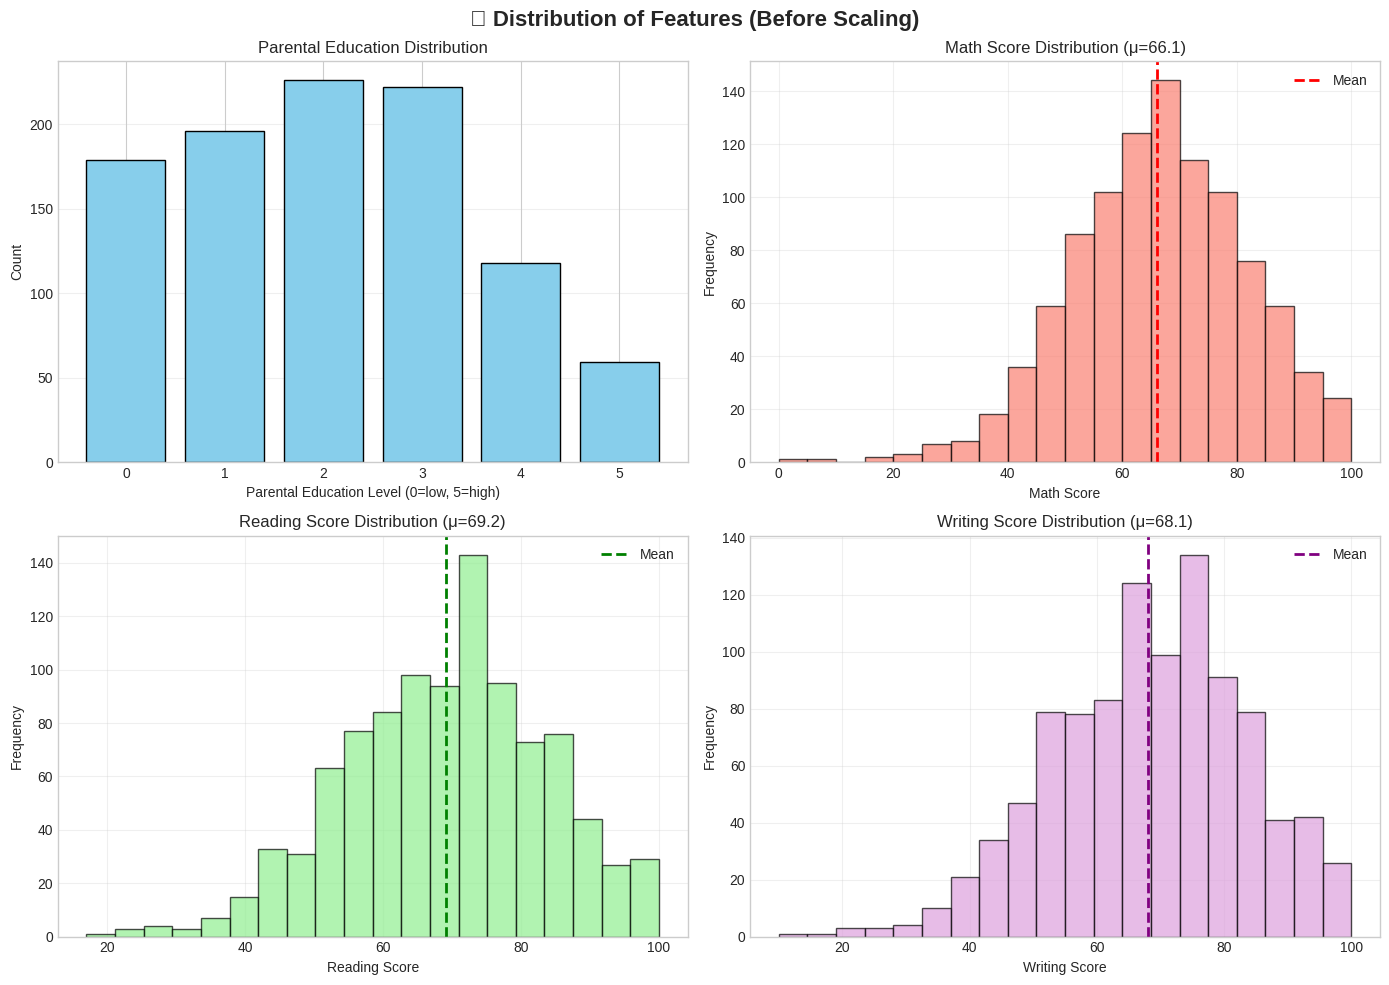

💡 Observations:
  - All three test scores (math, reading, and writing) show approximately normal distributions, centered around means of 66-69
  - Parental education levels are fairly evenly distributed across categories, with levels 2 and 3 (some college and associate's degree) being most common


In [56]:
# Create subplots for visualizing feature distributions before scaling
fig, axes = plt.subplots(2, 2, figsize=(14, 10))  # Create 2x2 grid of subplots with figure size 14x10 inches
fig.suptitle('📊 Distribution of Features (Before Scaling)', fontsize=16, fontweight='bold')  # Add main title

# Plot 1: Parental Education Distribution (categorical/ordinal)
ax = axes[0, 0]  # Select top-left subplot
education_counts = df_processed['parental_education_ordinal'].value_counts().sort_index()  # Count frequency of each education level and sort by level
ax.bar(education_counts.index, education_counts.values, color='skyblue', edgecolor='black')  # Create bar chart with blue bars and black edges
ax.set_xlabel('Parental Education Level (0=low, 5=high)')  # Label x-axis
ax.set_ylabel('Count')  # Label y-axis
ax.set_title('Parental Education Distribution')  # Add subplot title
ax.set_xticks(range(6))  # Set x-axis ticks to show all levels 0-5
ax.grid(axis='y', alpha=0.3)  # Add horizontal gridlines with 30% opacity

# Plot 2: Math Score Distribution (continuous)
ax = axes[0, 1]  # Select top-right subplot
ax.hist(df_processed['math score'], bins=20, color='salmon', edgecolor='black', alpha=0.7)  # Create histogram with 20 bins, salmon color, 70% opacity
ax.axvline(df_processed['math score'].mean(), color='red', linestyle='--', linewidth=2, label='Mean')  # Add vertical line at mean value
ax.set_xlabel('Math Score')  # Label x-axis
ax.set_ylabel('Frequency')  # Label y-axis
ax.set_title(f"Math Score Distribution (μ={df_processed['math score'].mean():.1f})")  # Add title with mean value
ax.legend()  # Show legend
ax.grid(alpha=0.3)  # Add gridlines with 30% opacity

# Plot 3: Reading Score Distribution (continuous)
ax = axes[1, 0]  # Select bottom-left subplot
ax.hist(df_processed['reading score'], bins=20, color='lightgreen', edgecolor='black', alpha=0.7)  # Create histogram with 20 bins, light green color, 70% opacity
ax.axvline(df_processed['reading score'].mean(), color='green', linestyle='--', linewidth=2, label='Mean')  # Add vertical line at mean value
ax.set_xlabel('Reading Score')  # Label x-axis
ax.set_ylabel('Frequency')  # Label y-axis
ax.set_title(f"Reading Score Distribution (μ={df_processed['reading score'].mean():.1f})")  # Add title with mean value
ax.legend()  # Show legend
ax.grid(alpha=0.3)  # Add gridlines with 30% opacity

# Plot 4: Writing Score Distribution (continuous)
ax = axes[1, 1]  # Select bottom-right subplot
ax.hist(df_processed['writing score'], bins=20, color='plum', edgecolor='black', alpha=0.7)  # Create histogram with 20 bins, plum color, 70% opacity
ax.axvline(df_processed['writing score'].mean(), color='purple', linestyle='--', linewidth=2, label='Mean')  # Add vertical line at mean value
ax.set_xlabel('Writing Score')  # Label x-axis
ax.set_ylabel('Frequency')  # Label y-axis
ax.set_title(f"Writing Score Distribution (μ={df_processed['writing score'].mean():.1f})")  # Add title with mean value
ax.legend()  # Show legend
ax.grid(alpha=0.3)  # Add gridlines with 30% opacity

plt.tight_layout()  # Automatically adjust subplot spacing to prevent overlap
plt.show()  # Display the figure

print("💡 Observations:")
print("  - All three test scores (math, reading, and writing) show approximately normal distributions, centered around means of 66-69")
print("  - Parental education levels are fairly evenly distributed across categories, with levels 2 and 3 (some college and associate's degree) being most common")


In [57]:
# Import skewness function from scipy.stats
from scipy.stats import skew  # Skewness measures the asymmetry of a probability distribution

# Calculate skewness for each standardized score feature
print("Skewness of Math Score: ", skew(X_final[:, 1]))  # Skewness of standardized math scores (column index 1)
print("Skewness of Reading Score:", skew(X_final[:, 2]))  # Skewness of standardized reading scores (column index 2)
print("Skewness of Writing Score: ", skew(X_final[:, 3]))  # Skewness of standardized writing scores (column index 3)


Skewness of Math Score:  -0.27851657191407503
Skewness of Reading Score: -0.25871569927829396
Skewness of Writing Score:  -0.2890096245211413


## Mathematical Foundation: Skewness

**Skewness** is a measure of the asymmetry of a probability distribution. It quantifies how much a distribution deviates from a symmetric (normal) distribution.

### Formula

The **sample skewness** (using Fisher-Pearson coefficient of skewness) is calculated as:

$$
\text{Skewness} = \frac{n}{(n-1)(n-2)} \sum_{i=1}^{n} \left(\frac{x_i - \bar{x}}{s}\right)^3
$$

where:
- $n$ = number of observations
- $x_i$ = $i$-th value in the dataset
- $\bar{x}$ = sample mean: $\bar{x} = \frac{1}{n}\sum_{i=1}^{n} x_i$
- $s$ = sample standard deviation: $s = \sqrt{\frac{1}{n-1}\sum_{i=1}^{n}(x_i - \bar{x})^2}$

### Mathematical Transformation Steps

1. **Compute the mean**:
   $$
   \bar{x} = \frac{1}{n}\sum_{i=1}^{n} x_i
   $$

2. **Compute the sample standard deviation**:
   $$
   s = \sqrt{\frac{1}{n-1}\sum_{i=1}^{n}(x_i - \bar{x})^2}
   $$

3. **Compute the standardized third moment**:
   $$
   m_3 = \frac{1}{n}\sum_{i=1}^{n} \left(\frac{x_i - \bar{x}}{s}\right)^3
   $$

4. **Apply bias correction** (Fisher-Pearson adjustment):
   $$
   \text{Skewness} = \frac{n}{(n-1)(n-2)} \sum_{i=1}^{n} \left(\frac{x_i - \bar{x}}{s}\right)^3 = \frac{n^2}{(n-1)(n-2)} \cdot m_3
   $$

### Interpretation

- **Skewness = 0**: Perfectly symmetric distribution (e.g., normal distribution)
- **Skewness > 0**: Right-skewed (positive skew)
  - Tail is longer on the right side
  - Mean > Median
  - Most values are concentrated on the left
  
- **Skewness < 0**: Left-skewed (negative skew)
  - Tail is longer on the left side
  - Mean < Median
  - Most values are concentrated on the right

### Rule of Thumb for Interpretation

- **|Skewness| < 0.5**: Approximately symmetric
- **0.5 ≤ |Skewness| < 1**: Moderately skewed
- **|Skewness| ≥ 1**: Highly skewed

### Why It Matters

1. **Data distribution understanding**: Helps identify if data is normally distributed or has outliers
2. **Algorithm assumptions**: Some algorithms assume normally distributed data
3. **Data transformation**: High skewness might indicate need for transformations (log, sqrt, etc.)

### In This Analysis

We calculate skewness for the **standardized exam scores** to check if they maintain approximately normal distributions after scaling.


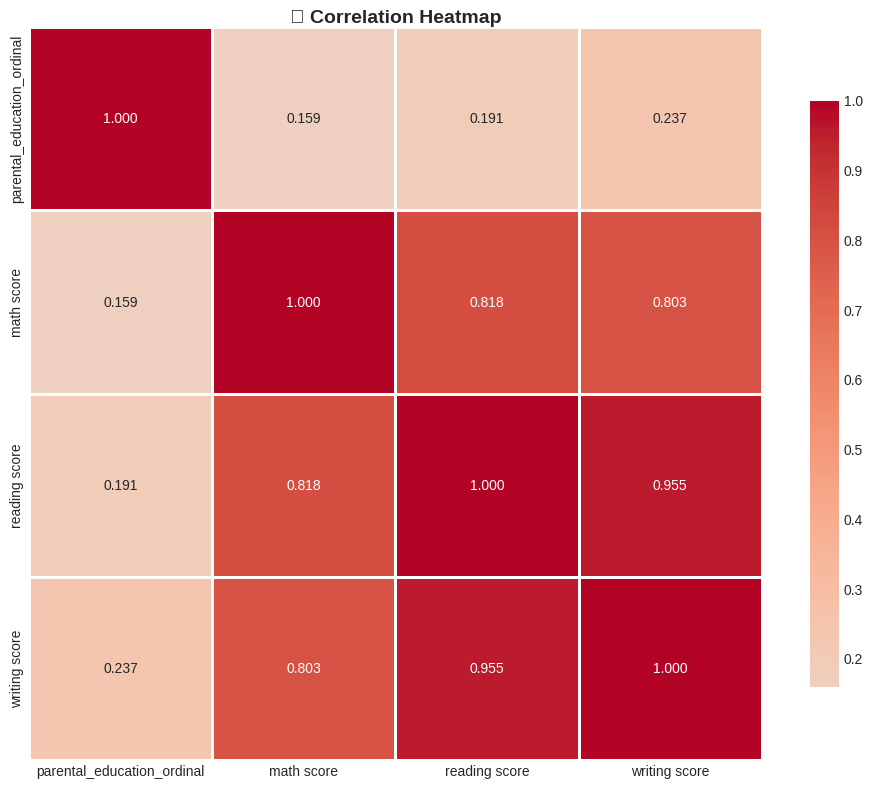


💡 Key Insights from Correlation:
  - Reading ↔ Writing: 0.955 (VERY HIGH)
  - Math ↔ Reading: 0.818 (HIGH)
  - Math ↔ Writing: 0.803 (HIGH)
  - Education ↔ Math: 0.159 (WEAK)
  - Education ↔ Reading: 0.191 (WEAK)
  - Education ↔ Writing: 0.237 (WEAK)

⚠️ Important: Exam scores are highly correlated with each other!
   This suggests students who do well in one subject tend to do well in others.


In [58]:
# Create correlation matrix to measure linear relationships between features
features_for_corr = ['parental_education_ordinal', 'math score', 'reading score', 'writing score']  # Select features for correlation analysis
corr_matrix = df_processed[features_for_corr].corr()  # Compute Pearson correlation coefficient matrix (r ranges from -1 to 1)

# Plot correlation heatmap for visualization
plt.figure(figsize=(10, 8))  # Create figure with size 10x8 inches
sns.heatmap(corr_matrix, annot=True, fmt='.3f', cmap='coolwarm', center=0,  # Create heatmap with annotations (3 decimal places)
            square=True, linewidths=1, cbar_kws={"shrink": 0.8})  # Square cells, 1-pixel borders, 80% colorbar size
plt.title('🔥 Correlation Heatmap', fontsize=14, fontweight='bold', y=0.995)  # Add title at top
plt.tight_layout()  # Adjust layout to prevent overlapping
plt.show()  # Display the plot

# Display key correlation insights
print("\n💡 Key Insights from Correlation:")
print(f"  - Reading ↔ Writing: {corr_matrix.loc['reading score', 'writing score']:.3f} (VERY HIGH)")  # Correlation between reading and writing
print(f"  - Math ↔ Reading: {corr_matrix.loc['math score', 'reading score']:.3f} (HIGH)")  # Correlation between math and reading
print(f"  - Math ↔ Writing: {corr_matrix.loc['math score', 'writing score']:.3f} (HIGH)")  # Correlation between math and writing
print(f"  - Education ↔ Math: {corr_matrix.loc['parental_education_ordinal', 'math score']:.3f} (WEAK)")  # Correlation between education and math
print(f"  - Education ↔ Reading: {corr_matrix.loc['parental_education_ordinal', 'reading score']:.3f} (WEAK)")  # Correlation between education and reading
print(f"  - Education ↔ Writing: {corr_matrix.loc['parental_education_ordinal', 'writing score']:.3f} (WEAK)")  # Correlation between education and writing
print("\n⚠️ Important: Exam scores are highly correlated with each other!")
print("   This suggests students who do well in one subject tend to do well in others.")


## Mathematical Foundation: Pearson Correlation Coefficient

The **Pearson correlation coefficient** (also called Pearson's r) measures the **linear relationship** between two variables. It quantifies both the strength and direction of the linear association.

### Formula

For two variables $X$ and $Y$ with $n$ observations, the Pearson correlation coefficient $r$ is:

$$
r_{XY} = \frac{\sum_{i=1}^{n}(x_i - \bar{x})(y_i - \bar{y})}{\sqrt{\sum_{i=1}^{n}(x_i - \bar{x})^2} \sqrt{\sum_{i=1}^{n}(y_i - \bar{y})^2}}
$$

where:
- $x_i, y_i$ = individual observations of variables $X$ and $Y$
- $\bar{x}, \bar{y}$ = means of $X$ and $Y$
- $n$ = number of observations

### Alternative Formula (Using Covariance)

The correlation coefficient can also be expressed as:

$$
r_{XY} = \frac{\text{Cov}(X, Y)}{\sigma_X \sigma_Y}
$$

where:
- $\text{Cov}(X, Y) = \frac{1}{n-1}\sum_{i=1}^{n}(x_i - \bar{x})(y_i - \bar{y})$ is the **covariance** between $X$ and $Y$
- $\sigma_X = \sqrt{\frac{1}{n-1}\sum_{i=1}^{n}(x_i - \bar{x})^2}$ is the **standard deviation** of $X$
- $\sigma_Y = \sqrt{\frac{1}{n-1}\sum_{i=1}^{n}(y_i - \bar{y})^2}$ is the **standard deviation** of $Y$

### Mathematical Transformation Steps

1. **Compute the means**:
   $$
   \bar{x} = \frac{1}{n}\sum_{i=1}^{n} x_i, \quad \bar{y} = \frac{1}{n}\sum_{i=1}^{n} y_i
   $$

2. **Compute deviations from the mean**:
   $$
   d_x^{(i)} = x_i - \bar{x}, \quad d_y^{(i)} = y_i - \bar{y}
   $$

3. **Compute the covariance (numerator)**:
   $$
   \text{Cov}(X, Y) = \frac{1}{n-1}\sum_{i=1}^{n} d_x^{(i)} \cdot d_y^{(i)} = \frac{1}{n-1}\sum_{i=1}^{n}(x_i - \bar{x})(y_i - \bar{y})
   $$

4. **Compute the standard deviations (denominator)**:
   $$
   \sigma_X = \sqrt{\frac{1}{n-1}\sum_{i=1}^{n}(x_i - \bar{x})^2}, \quad \sigma_Y = \sqrt{\frac{1}{n-1}\sum_{i=1}^{n}(y_i - \bar{y})^2}
   $$

5. **Compute the correlation**:
   $$
   r_{XY} = \frac{\text{Cov}(X, Y)}{\sigma_X \cdot \sigma_Y}
   $$

### Properties

1. **Range**: $-1 \leq r \leq 1$
   - $r = 1$: Perfect positive linear relationship
   - $r = -1$: Perfect negative linear relationship
   - $r = 0$: No linear relationship

2. **Symmetry**: $r_{XY} = r_{YX}$

3. **Scale invariant**: Correlation is not affected by linear transformations (adding/multiplying constants)

4. **Dimensionless**: Unlike covariance, correlation has no units

### Interpretation Guidelines

- **|r| ≥ 0.8**: Very strong correlation
- **0.6 ≤ |r| < 0.8**: Strong correlation
- **0.4 ≤ |r| < 0.6**: Moderate correlation
- **0.2 ≤ |r| < 0.4**: Weak correlation
- **|r| < 0.2**: Very weak or no correlation

### Important Caveats

1. **Only measures linear relationships**: Non-linear relationships may not be detected
2. **Correlation ≠ Causation**: High correlation doesn't imply one variable causes the other
3. **Sensitive to outliers**: A few extreme values can significantly affect the correlation

### Correlation Matrix

For $p$ variables, the **correlation matrix** $\mathbf{R}$ is a $p \times p$ symmetric matrix:

$$
\mathbf{R} = \begin{bmatrix}
1 & r_{12} & r_{13} & \cdots & r_{1p} \\
r_{21} & 1 & r_{23} & \cdots & r_{2p} \\
r_{31} & r_{32} & 1 & \cdots & r_{3p} \\
\vdots & \vdots & \vdots & \ddots & \vdots \\
r_{p1} & r_{p2} & r_{p3} & \cdots & 1
\end{bmatrix}
$$

where:
- Diagonal elements are always 1 (each variable perfectly correlates with itself)
- Off-diagonal element $r_{ij}$ is the correlation between variables $i$ and $j$
- The matrix is symmetric: $r_{ij} = r_{ji}$

### In This Analysis

We compute the correlation matrix for:
- Parental education (ordinal)
- Math score
- Reading score  
- Writing score

This reveals which features are strongly related and may provide redundant information.


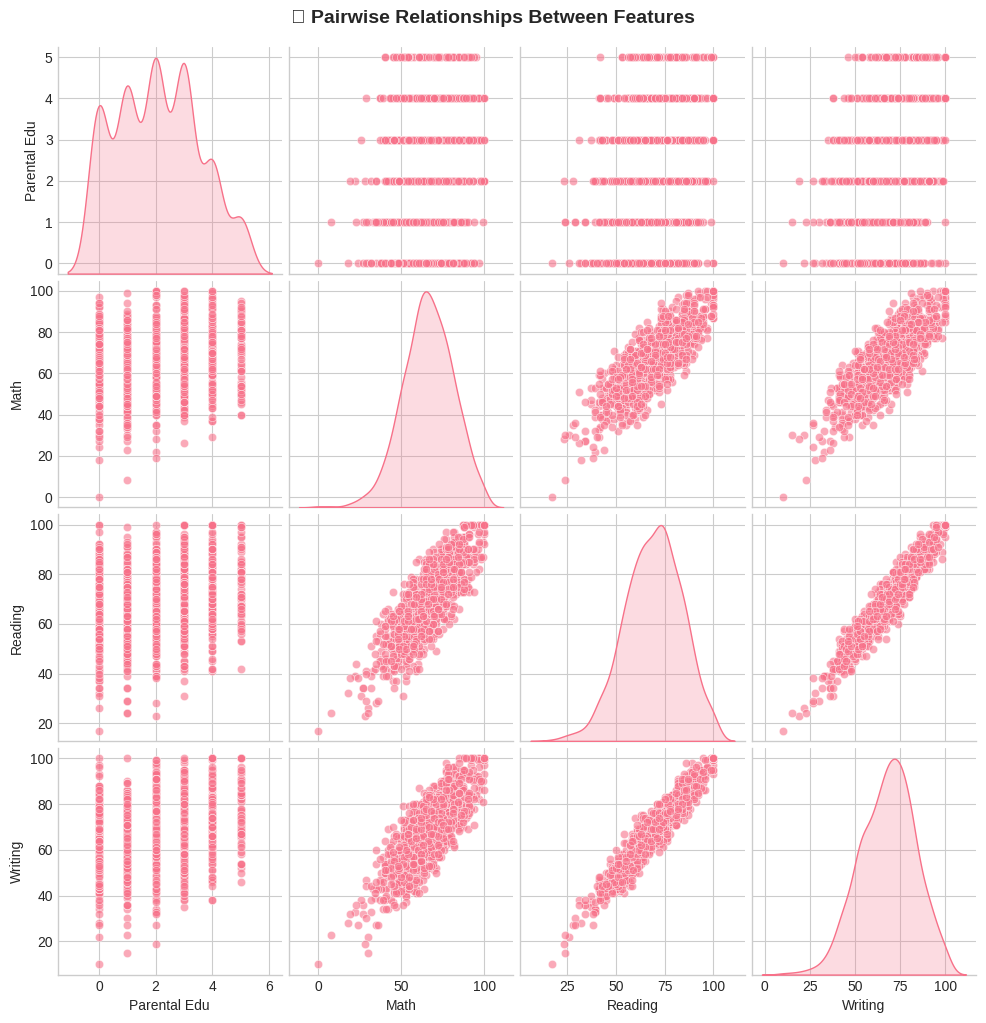

💡 What to look for in this pairplot:
  - Diagonal panels: Show the distribution shape of each individual feature
    • The three test scores display bell-shaped (normal) distributions
    • Parental education shows a discrete categorical distribution
  
  - Off-diagonal scatter plots: Reveal relationships between feature pairs
    • Math-Reading, Math-Writing, and Reading-Writing show strong positive
      linear correlations (students who score high in one tend to score high in others)
    • Parental education vs. test scores create vertical stripe patterns because
      parental education is categorical (discrete levels 0-5)
    • Tighter, more linear point clouds indicate stronger correlations
    • More dispersed clouds suggest weaker relationships


In [59]:
# Create pairplot for visual analysis of feature relationships
pairplot_data = df_processed[features_for_corr].copy()  # Create copy of selected features
pairplot_data.columns = ['Parental Edu', 'Math', 'Reading', 'Writing']  # Rename columns for better readability in plot

sns.pairplot(pairplot_data, diag_kind='kde', plot_kws={'alpha': 0.6})  # Create pairwise scatter plots with KDE on diagonal, 60% transparency
plt.suptitle('📊 Pairwise Relationships Between Features', y=1.02, fontsize=14, fontweight='bold')  # Add main title above plot
plt.show()  # Display the plot

print("💡 What to look for in this pairplot:")
print("  - Diagonal panels: Show the distribution shape of each individual feature")
print("    • The three test scores display bell-shaped (normal) distributions")
print("    • Parental education shows a discrete categorical distribution")
print("  ")
print("  - Off-diagonal scatter plots: Reveal relationships between feature pairs")
print("    • Math-Reading, Math-Writing, and Reading-Writing show strong positive")
print("      linear correlations (students who score high in one tend to score high in others)")
print("    • Parental education vs. test scores create vertical stripe patterns because")
print("      parental education is categorical (discrete levels 0-5)")
print("    • Tighter, more linear point clouds indicate stronger correlations")
print("    • More dispersed clouds suggest weaker relationships")


In [60]:
# Fit PCA with all components to analyze variance structure
pca_full = PCA()  # Initialize PCA without specifying n_components (will compute all 4 components)
X_pca_full = pca_full.fit_transform(X_final)  # Fit PCA to data and transform to principal component space

# Calculate cumulative explained variance to determine how many components are needed
explained_variance = pca_full.explained_variance_ratio_  # Get proportion of variance explained by each component
cumulative_variance = np.cumsum(explained_variance)  # Calculate cumulative sum of explained variance ratios

print("📊 PCA ANALYSIS RESULTS")
print("=" * 60)
print("\nExplained Variance by Each Component:")
for i, (var, cum_var) in enumerate(zip(explained_variance, cumulative_variance)):  # Iterate through individual and cumulative variances
    print(f"  PC{i+1}: {var:.4f} ({var*100:.2f}%) | Cumulative: {cum_var:.4f} ({cum_var*100:.2f}%)")  # Print variance for each PC

# Determine optimal number of components based on variance thresholds
n_components_90 = np.argmax(cumulative_variance >= 0.90) + 1  # Find first index where cumulative variance >= 90%, add 1 for count
n_components_95 = np.argmax(cumulative_variance >= 0.95) + 1  # Find first index where cumulative variance >= 95%, add 1 for count

print(f"\n💡 Insights:")
print(f"  - {n_components_90} components needed for 90% variance")  # Number of components to retain 90% of information
print(f"  - {n_components_95} components needed for 95% variance")  # Number of components to retain 95% of information
print(f"  - PC1 explains {explained_variance[0]*100:.1f}% - dominant component!")  # First PC captures most variance


📊 PCA ANALYSIS RESULTS

Explained Variance by Each Component:
  PC1: 0.5851 (58.51%) | Cumulative: 0.5851 (58.51%)
  PC2: 0.3606 (36.06%) | Cumulative: 0.9456 (94.56%)
  PC3: 0.0458 (4.58%) | Cumulative: 0.9914 (99.14%)
  PC4: 0.0086 (0.86%) | Cumulative: 1.0000 (100.00%)

💡 Insights:
  - 2 components needed for 90% variance
  - 3 components needed for 95% variance
  - PC1 explains 58.5% - dominant component!


## Mathematical Foundation: Principal Component Analysis (PCA)

**Principal Component Analysis (PCA)** is a dimensionality reduction technique that transforms data into a new coordinate system where the axes (principal components) capture the maximum variance in the data.

### Objective

Find orthogonal directions (principal components) that maximize the variance of the projected data.

### Mathematical Formulation

Given a data matrix $\mathbf{X} \in \mathbb{R}^{n \times p}$ with $n$ samples and $p$ features:

#### Step 1: Center the Data

Subtract the mean from each feature:

$$
\mathbf{X}_{\text{centered}} = \mathbf{X} - \mathbf{1}\boldsymbol{\mu}^T
$$

where:
- $\mathbf{1}$ is an $n \times 1$ vector of ones
- $\boldsymbol{\mu} = [\mu_1, \mu_2, \ldots, \mu_p]^T$ where $\mu_j = \frac{1}{n}\sum_{i=1}^{n} x_{ij}$

#### Step 2: Compute the Covariance Matrix

$$
\mathbf{C} = \frac{1}{n-1} \mathbf{X}_{\text{centered}}^T \mathbf{X}_{\text{centered}}
$$

The covariance matrix $\mathbf{C} \in \mathbb{R}^{p \times p}$ is symmetric and positive semi-definite:

$$
\mathbf{C} = \begin{bmatrix}
\sigma_1^2 & \text{cov}(x_1, x_2) & \cdots & \text{cov}(x_1, x_p) \\
\text{cov}(x_2, x_1) & \sigma_2^2 & \cdots & \text{cov}(x_2, x_p) \\
\vdots & \vdots & \ddots & \vdots \\
\text{cov}(x_p, x_1) & \text{cov}(x_p, x_2) & \cdots & \sigma_p^2
\end{bmatrix}
$$

where $\sigma_j^2 = \frac{1}{n-1}\sum_{i=1}^{n}(x_{ij} - \mu_j)^2$ is the variance of feature $j$.

#### Step 3: Compute Eigenvalues and Eigenvectors

Solve the eigenvalue problem:

$$
\mathbf{C}\mathbf{v}_i = \lambda_i \mathbf{v}_i
$$

where:
- $\lambda_i$ are the eigenvalues (variance explained by each PC)
- $\mathbf{v}_i$ are the eigenvectors (directions of principal components)
- Eigenvalues satisfy: $\lambda_1 \geq \lambda_2 \geq \cdots \geq \lambda_p \geq 0$
- Eigenvectors are orthonormal: $\mathbf{v}_i^T \mathbf{v}_j = \delta_{ij}$ (Kronecker delta)

This can be written as matrix decomposition:

$$
\mathbf{C} = \mathbf{V}\mathbf{\Lambda}\mathbf{V}^T
$$

where:
- $\mathbf{V} = [\mathbf{v}_1, \mathbf{v}_2, \ldots, \mathbf{v}_p]$ is the matrix of eigenvectors
- $\mathbf{\Lambda} = \text{diag}(\lambda_1, \lambda_2, \ldots, \lambda_p)$ is the diagonal matrix of eigenvalues

#### Step 4: Project Data onto Principal Components

Transform the original data to the new coordinate system:

$$
\mathbf{Z} = \mathbf{X}_{\text{centered}} \mathbf{V}
$$

where $\mathbf{Z} \in \mathbb{R}^{n \times p}$ is the transformed data (principal component scores).

For each sample $\mathbf{x}_i$:

$$
z_{ij} = (\mathbf{x}_i - \boldsymbol{\mu})^T \mathbf{v}_j = \sum_{k=1}^{p} (x_{ik} - \mu_k) v_{jk}
$$

### Explained Variance

The **explained variance ratio** for the $i$-th principal component:

$$
\text{Explained Variance Ratio}_i = \frac{\lambda_i}{\sum_{j=1}^{p} \lambda_j}
$$

This represents the proportion of total variance captured by PC$_i$.

**Cumulative explained variance** for the first $k$ components:

$$
\text{Cumulative Variance}_k = \frac{\sum_{i=1}^{k} \lambda_i}{\sum_{j=1}^{p} \lambda_j} = \sum_{i=1}^{k} \text{Explained Variance Ratio}_i
$$

### Total Variance Preservation

An important property of PCA:

$$
\sum_{i=1}^{p} \lambda_i = \sum_{j=1}^{p} \sigma_j^2 = \text{tr}(\mathbf{C})
$$

where $\text{tr}(\mathbf{C})$ is the trace of the covariance matrix (sum of diagonal elements).

This means the total variance is preserved: the sum of variances in the original space equals the sum of variances in the PC space.

### Dimensionality Reduction

To reduce to $k < p$ dimensions, keep only the first $k$ principal components:

$$
\mathbf{Z}_k = \mathbf{X}_{\text{centered}} \mathbf{V}_k
$$

where $\mathbf{V}_k = [\mathbf{v}_1, \mathbf{v}_2, \ldots, \mathbf{v}_k]$ contains only the first $k$ eigenvectors.

### Reconstruction

Data can be reconstructed (approximately) from $k$ components:

$$
\mathbf{X}_{\text{reconstructed}} = \mathbf{Z}_k \mathbf{V}_k^T + \mathbf{1}\boldsymbol{\mu}^T
$$

The **reconstruction error** is:

$$
\text{Error} = \|\mathbf{X} - \mathbf{X}_{\text{reconstructed}}\|^2_F = \sum_{i=k+1}^{p} \lambda_i
$$

where $\|\cdot\|_F$ is the Frobenius norm.

### Component Loadings

The **loadings** are the elements of the eigenvectors $\mathbf{v}_i$. They represent how each original feature contributes to each principal component:

$$
\text{Loading of feature } j \text{ on PC}_i = v_{ij}
$$

The loading can be interpreted as the correlation between the original feature and the PC:

$$
\text{Loading}_{ij} = \text{cor}(x_j, z_i) = \frac{v_{ij}\sqrt{\lambda_i}}{\sigma_j}
$$

### Why PCA Works: Variance Maximization Perspective

The first principal component $\mathbf{v}_1$ solves the optimization problem:

$$
\max_{\|\mathbf{v}\|=1} \text{Var}(\mathbf{X}_{\text{centered}}\mathbf{v}) = \max_{\|\mathbf{v}\|=1} \mathbf{v}^T\mathbf{C}\mathbf{v}
$$

Using Lagrange multipliers:

$$
\mathcal{L}(\mathbf{v}, \lambda) = \mathbf{v}^T\mathbf{C}\mathbf{v} - \lambda(\mathbf{v}^T\mathbf{v} - 1)
$$

Taking the derivative and setting to zero:

$$
\frac{\partial \mathcal{L}}{\partial \mathbf{v}} = 2\mathbf{C}\mathbf{v} - 2\lambda\mathbf{v} = 0 \quad \Rightarrow \quad \mathbf{C}\mathbf{v} = \lambda\mathbf{v}
$$

This is the eigenvalue equation! The variance is maximized when $\mathbf{v}$ is the eigenvector with the largest eigenvalue.

### Properties of PCA

1. **Orthogonality**: All principal components are uncorrelated (orthogonal):
   $$\text{Cov}(z_i, z_j) = 0 \text{ for } i \neq j$$

2. **Variance ordering**: $\text{Var}(z_1) \geq \text{Var}(z_2) \geq \cdots \geq \text{Var}(z_p)$

3. **Linear transformation**: PCA is a linear transformation (rotation)

4. **Unsupervised**: PCA doesn't use class labels

### In This Analysis

We apply PCA to our 4-dimensional feature space:
- Input: $\mathbf{X}_{1000 \times 4}$ (1000 students, 4 features)
- Output: 4 principal components (PC1, PC2, PC3, PC4)
- We analyze explained variance to understand which components are most important
- For visualization, we'll project onto 2D (PC1, PC2) or 3D (PC1, PC2, PC3)


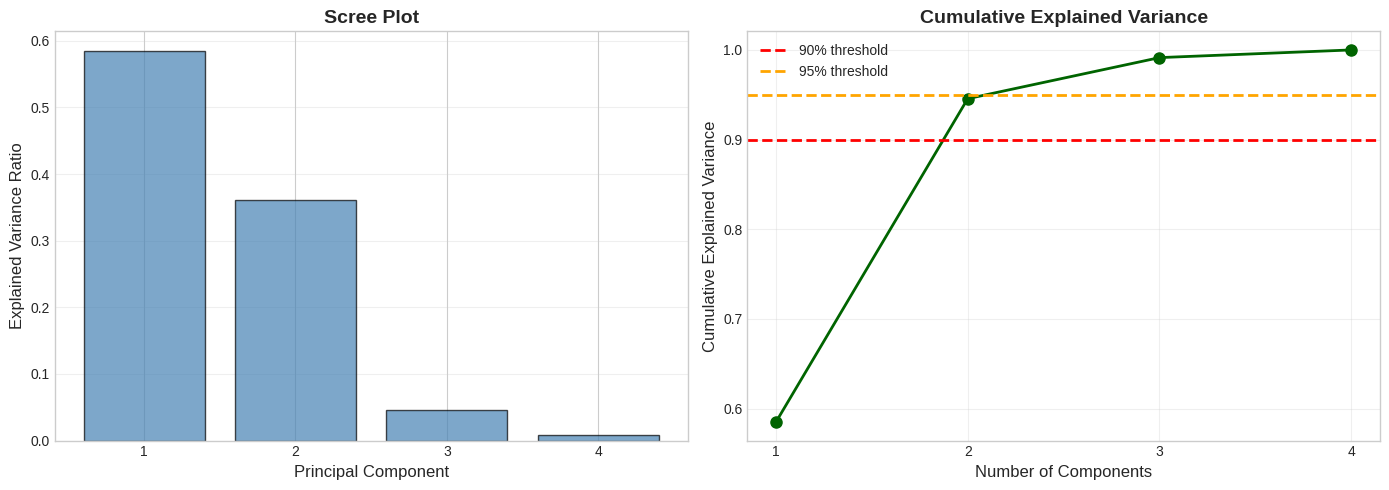

In [61]:
# Visualize explained variance using two complementary plots
fig, axes = plt.subplots(1, 2, figsize=(14, 5))  # Create 1x2 grid of subplots

# Plot 1: Scree plot (individual variance per component)
ax = axes[0]  # Select first subplot
ax.bar(range(1, len(explained_variance) + 1), explained_variance,  # Create bar chart with component numbers on x-axis
       color='steelblue', edgecolor='black', alpha=0.7)  # Blue bars with black edges, 70% opacity
ax.set_xlabel('Principal Component', fontsize=12)  # Label x-axis
ax.set_ylabel('Explained Variance Ratio', fontsize=12)  # Label y-axis
ax.set_title('Scree Plot', fontsize=14, fontweight='bold')  # Add title
ax.set_xticks(range(1, len(explained_variance) + 1))  # Set x-axis ticks to show PC1, PC2, PC3, PC4
ax.grid(axis='y', alpha=0.3)  # Add horizontal gridlines with 30% opacity

# Plot 2: Cumulative variance (total variance captured by first k components)
ax = axes[1]  # Select second subplot
ax.plot(range(1, len(cumulative_variance) + 1), cumulative_variance,  # Create line plot
        marker='o', linewidth=2, markersize=8, color='darkgreen')  # Green line with circular markers
ax.axhline(y=0.90, color='red', linestyle='--', linewidth=2, label='90% threshold')  # Add horizontal line at 90%
ax.axhline(y=0.95, color='orange', linestyle='--', linewidth=2, label='95% threshold')  # Add horizontal line at 95%
ax.set_xlabel('Number of Components', fontsize=12)  # Label x-axis
ax.set_ylabel('Cumulative Explained Variance', fontsize=12)  # Label y-axis
ax.set_title('Cumulative Explained Variance', fontsize=14, fontweight='bold')  # Add title
ax.set_xticks(range(1, len(cumulative_variance) + 1))  # Set x-axis ticks to show 1, 2, 3, 4
ax.legend()  # Display legend showing threshold lines
ax.grid(alpha=0.3)  # Add gridlines with 30% opacity

plt.tight_layout()  # Adjust spacing to prevent overlap
plt.show()  # Display the figure


In [62]:
# Get component loadings matrix showing contribution of each feature to each PC
loadings = pd.DataFrame(
    pca_full.components_.T,  # Transpose components matrix (shape: p x p) to get loadings
    columns=[f'PC{i+1}' for i in range(len(explained_variance))],  # Column names: PC1, PC2, PC3, PC4
    index=feature_names  # Row names: original feature names
)

print("📊 PCA COMPONENT LOADINGS")
print("=" * 60)
print("\nLoadings Matrix (How each feature contributes to PCs):\n")
display(loadings.style.background_gradient(cmap='RdYlGn', axis=None).format("{:.3f}"))  # Display with color gradient, 3 decimal places

# Provide interpretation guidance
print("\n💡 Interpretation Guide:")
print("  How to read the loadings:")
print("    • Each loading shows how strongly a feature contributes to that principal component")
print("    • The sign (+/-) indicates the direction of the relationship:")
print("      - Positive loading: higher feature values → higher PC scores")
print("      - Negative loading: higher feature values → lower PC scores")
print("    • The magnitude (absolute value) shows importance:")
print("      - Values near ±1.0: very strong contribution")
print("      - Values near ±0.5: moderate contribution")
print("      - Values near 0: minimal contribution")
print("  ")
print("  What each PC captures in this dataset:")
print("    • PC1 (58.51% variance): Overall academic performance & family background")
print("      All features load positively → represents general student success")
print("    • PC2 (36.06% variance): Parental education vs. test scores")
print("      Strong parental education (+0.868) but lower test performance (all negative)")
print("      This is the second most important dimension (about 62% as much variance as PC1)")
print("    • PC3 (4.58% variance): Math ability vs. verbal skills")
print("      Strong in math (+0.828) but weaker in reading/writing (both negative)")
print("    • PC4 (0.86% variance): Reading vs. writing performance")
print("      Captures minimal remaining variance between these verbal skills")


📊 PCA COMPONENT LOADINGS

Loadings Matrix (How each feature contributes to PCs):




💡 Interpretation Guide:
  How to read the loadings:
    • Each loading shows how strongly a feature contributes to that principal component
    • The sign (+/-) indicates the direction of the relationship:
      - Positive loading: higher feature values → higher PC scores
      - Negative loading: higher feature values → lower PC scores
    • The magnitude (absolute value) shows importance:
      - Values near ±1.0: very strong contribution
      - Values near ±0.5: moderate contribution
      - Values near 0: minimal contribution
  
  What each PC captures in this dataset:
    • PC1 (58.51% variance): Overall academic performance & family background
      All features load positively → represents general student success
    • PC2 (36.06% variance): Parental education vs. test scores
      Strong parental education (+0.868) but lower test performance (all negative)
      This is the second most important dimension (about 62% as much variance as PC1)
    • PC3 (4.58% variance): Math ab

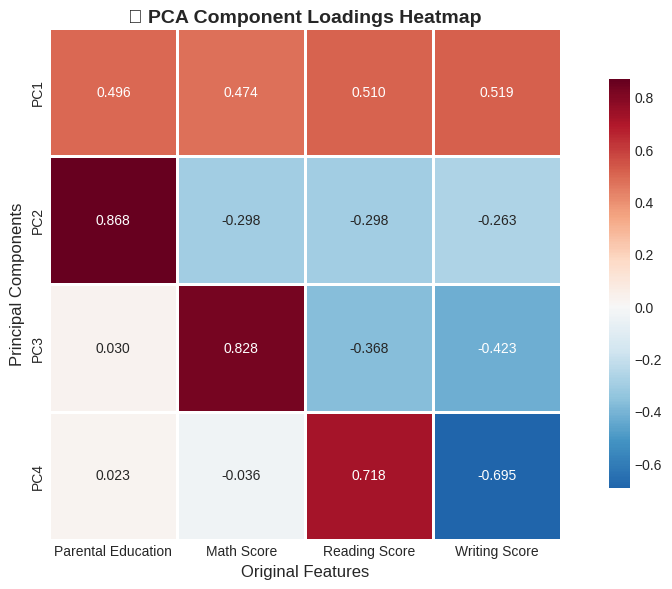


🎯 COMPONENT INTERPRETATION:

PC1 (58.5% variance):
  Dominated by: Writing Score
  Top 3 contributors:
    1. Writing Score: +0.519
    2. Reading Score: +0.510
    3. Parental Education: +0.496

PC2 (36.1% variance):
  Dominated by: Parental Education
  Top 3 contributors:
    1. Parental Education: +0.868
    2. Reading Score: -0.298
    3. Math Score: -0.298

PC3 (4.6% variance):
  Dominated by: Math Score
  Top 3 contributors:
    1. Math Score: +0.828
    2. Writing Score: -0.423
    3. Reading Score: -0.368

PC4 (0.9% variance):
  Dominated by: Reading Score
  Top 3 contributors:
    1. Reading Score: +0.718
    2. Writing Score: -0.695
    3. Math Score: -0.036


In [63]:
# Visualize loadings as heatmap for better understanding of feature-PC relationships
plt.figure(figsize=(10, 6))  # Create figure with size 10x6 inches
sns.heatmap(loadings.T, annot=True, fmt='.3f', cmap='RdBu_r', center=0,  # Create heatmap with annotations, 3 decimal places, red-blue colormap centered at 0
            square=True, linewidths=1, cbar_kws={"shrink": 0.8})  # Square cells, 1-pixel borders, 80% colorbar size
plt.title('🔥 PCA Component Loadings Heatmap', fontsize=14, fontweight='bold', y=0.995)  # Add title at top
plt.xlabel('Original Features', fontsize=12)  # Label x-axis
plt.ylabel('Principal Components', fontsize=12)  # Label y-axis
plt.tight_layout()  # Adjust layout to prevent overlapping
plt.show()  # Display the heatmap

# Interpret each PC by identifying dominant features
print("\n🎯 COMPONENT INTERPRETATION:")
print("=" * 60)
for i in range(len(explained_variance)):  # Iterate through each principal component
    pc_name = f"PC{i+1}"  # Create PC name (PC1, PC2, etc.)
    pc_loadings = loadings[pc_name].abs().sort_values(ascending=False)  # Get absolute loadings sorted from highest to lowest
    top_feature = pc_loadings.index[0]  # Get feature with highest absolute loading
    print(f"\n{pc_name} ({explained_variance[i]*100:.1f}% variance):")  # Print PC name and variance explained
    print(f"  Dominated by: {top_feature}")  # Print most influential feature
    print(f"  Top 3 contributors:")
    for j, (feat, loading) in enumerate(pc_loadings.head(3).items()):  # Get top 3 features by absolute loading
        original_loading = loadings.loc[feat, pc_name]  # Get original loading (with sign)
        print(f"    {j+1}. {feat}: {original_loading:+.3f}")  # Print rank, feature name, and signed loading


In [64]:
# Create PCA transformation for VISUALIZATION ONLY (not for clustering)
# We will NOT use this for clustering - clustering will use all 4 original dimensions
n_components_viz = 3  # Reduce to 3 dimensions for 3D visualization
pca_viz = PCA(n_components=n_components_viz)  # Initialize PCA with 3 components
X_pca_viz = pca_viz.fit_transform(X_final)  # Fit PCA and transform data to 3D space

# Also create 2D version for 2D plots
pca_2d = PCA(n_components=2)  # Initialize PCA with 2 components
X_pca_2d = pca_2d.fit_transform(X_final)  # Fit PCA and transform data to 2D space

print(f"✅ PCA TRANSFORMATIONS CREATED (FOR VISUALIZATION ONLY)")
print("=" * 60)
print(f"\n🎯 CLUSTERING WILL USE: X_final ({X_final.shape[1]} dimensions)")  # Emphasize clustering uses original 4D data
print(f"   • Preserves ALL information (100% variance)")  # No information loss in clustering
print(f"   • Features: {feature_names}")  # List of feature names
print(f"\n📊 VISUALIZATION WILL USE: PCA-transformed data")  # PCA only for display purposes
print(f"   • 2D PCA: {pca_2d.explained_variance_ratio_.sum()*100:.2f}% variance")  # Total variance captured in 2D
print(f"     - PC1: {pca_2d.explained_variance_ratio_[0]*100:.2f}%")  # Variance explained by first PC
print(f"     - PC2: {pca_2d.explained_variance_ratio_[1]*100:.2f}%")  # Variance explained by second PC
print(f"   • 3D PCA: {pca_viz.explained_variance_ratio_.sum()*100:.2f}% variance")  # Total variance captured in 3D
print(f"     - PC1: {pca_viz.explained_variance_ratio_[0]*100:.2f}%")  # Variance explained by first PC
print(f"     - PC2: {pca_viz.explained_variance_ratio_[1]*100:.2f}%")  # Variance explained by second PC
print(f"     - PC3: {pca_viz.explained_variance_ratio_[2]*100:.2f}%")  # Variance explained by third PC


✅ PCA TRANSFORMATIONS CREATED (FOR VISUALIZATION ONLY)

🎯 CLUSTERING WILL USE: X_final (4 dimensions)
   • Preserves ALL information (100% variance)
   • Features: ['Parental Education', 'Math Score', 'Reading Score', 'Writing Score']

📊 VISUALIZATION WILL USE: PCA-transformed data
   • 2D PCA: 94.56% variance
     - PC1: 58.51%
     - PC2: 36.06%
   • 3D PCA: 99.14% variance
     - PC1: 58.51%
     - PC2: 36.06%
     - PC3: 4.58%



📊 PCA VISUALIZATION - UNDERSTANDING DATA IN REDUCED DIMENSIONS

✅ Transformed data shape: (1000, 4)
   Original: 1000 students × 4 features
   After PCA: 1000 students × 4 PCs

----------------------------------------------------------------------
📊 Creating 2D visualization (PC1 vs PC2)...
----------------------------------------------------------------------


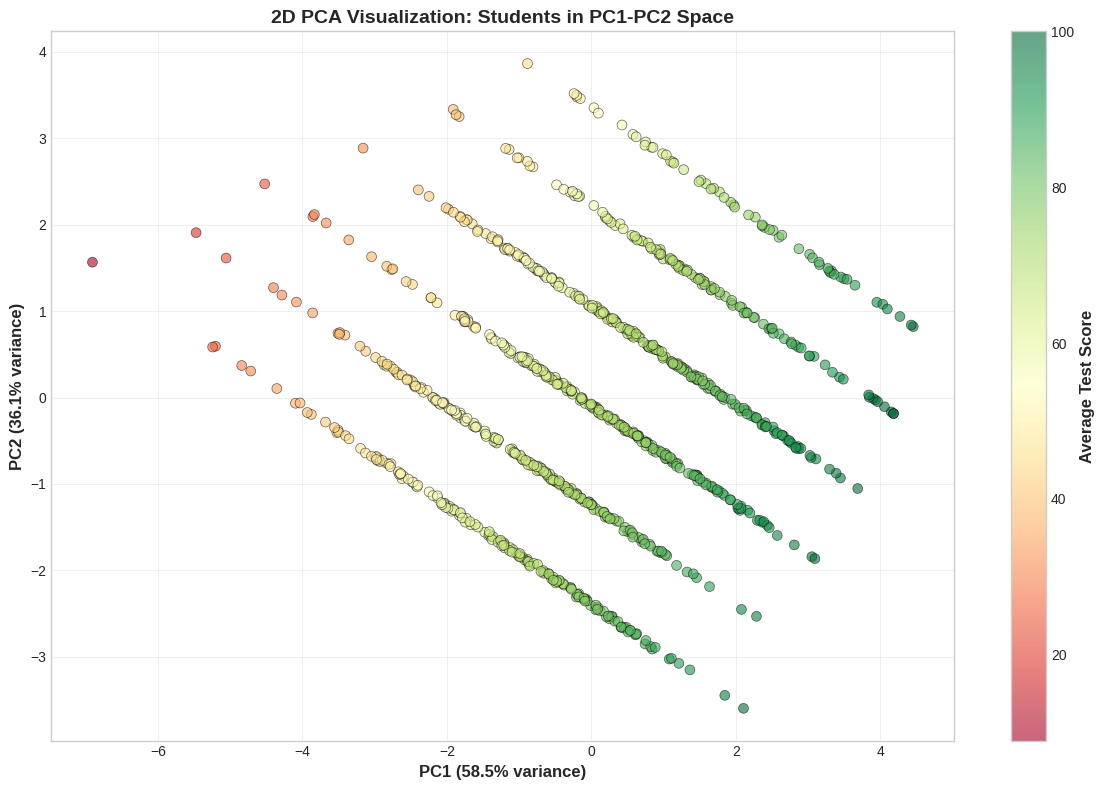


💡 Interpretation:
   • PC1 (horizontal): Represents 58.5% of variance - overall academic performance
   • PC2 (vertical): Represents 36.1% of variance - parental education vs. test scores
   • Color: Average test score (green=high, red=low)
   • Together, these 2 PCs capture 94.6% of total variance


In [65]:
# ==============================================================================
# SECTION: VISUALIZE PCA RESULTS IN 2D AND 3D
# ==============================================================================

print("\n" + "=" * 70)
print("📊 PCA VISUALIZATION - UNDERSTANDING DATA IN REDUCED DIMENSIONS")
print("=" * 70)

# ------------------------------------------------------------------------------
# Step 1: Transform original data to PCA space
# ------------------------------------------------------------------------------
# We transform our 4D standardized data into principal component space
# This gives us new coordinates for each student in the PC1, PC2, PC3, PC4 space

X_pca = pca_full.transform(X_final)  # Transform 4D data to 4D PC space using previously fitted PCA

# Create a DataFrame for easier handling and understanding
pca_df = pd.DataFrame(
    X_pca,  # PC-transformed data (1000 x 4)
    columns=[f'PC{i+1}' for i in range(X_pca.shape[1])]  # Column names: PC1, PC2, PC3, PC4
)

print(f"\n✅ Transformed data shape: {X_pca.shape}")
print(f"   Original: 1000 students × 4 features")  # Original feature space dimensions
print(f"   After PCA: 1000 students × 4 PCs")  # PC space dimensions (same number, but orthogonal)

# ------------------------------------------------------------------------------
# Step 2: Create 2D Visualization (PC1 vs PC2)
# ------------------------------------------------------------------------------
print("\n" + "-" * 70)
print("📊 Creating 2D visualization (PC1 vs PC2)...")
print("-" * 70)

# Calculate average score for color mapping
avg_score = (df_processed['math score'] + df_processed['reading score'] + df_processed['writing score']) / 3  # Compute mean of three exam scores

# Create 2D scatter plot
fig, ax = plt.subplots(figsize=(12, 8))  # Create figure with size 12x8 inches

scatter = ax.scatter(
    pca_df['PC1'],  # x-axis: first principal component
    pca_df['PC2'],  # y-axis: second principal component
    c=avg_score,  # Color points by average test score
    cmap='RdYlGn',  # Red-Yellow-Green colormap (red=low, yellow=medium, green=high)
    s=50,  # Point size = 50
    alpha=0.6,  # 60% opacity for better visibility of overlapping points
    edgecolors='black',  # Black border around each point
    linewidth=0.5  # Border width = 0.5 pixels
)

# Add colorbar to show score mapping
cbar = plt.colorbar(scatter, ax=ax)  # Create colorbar associated with the scatter plot
cbar.set_label('Average Test Score', fontsize=12, fontweight='bold')  # Label for colorbar

# Label axes with variance explained
ax.set_xlabel(f'PC1 ({explained_variance[0]*100:.1f}% variance)', fontsize=12, fontweight='bold')  # x-axis label with variance percentage
ax.set_ylabel(f'PC2 ({explained_variance[1]*100:.1f}% variance)', fontsize=12, fontweight='bold')  # y-axis label with variance percentage
ax.set_title('2D PCA Visualization: Students in PC1-PC2 Space', fontsize=14, fontweight='bold')  # Plot title
ax.grid(alpha=0.3)  # Add gridlines with 30% opacity

plt.tight_layout()  # Adjust layout to prevent overlapping
plt.show()  # Display the plot

print(f"\n💡 Interpretation:")
print(f"   • PC1 (horizontal): Represents {explained_variance[0]*100:.1f}% of variance - overall academic performance")
print(f"   • PC2 (vertical): Represents {explained_variance[1]*100:.1f}% of variance - parental education vs. test scores")
print(f"   • Color: Average test score (green=high, red=low)")
print(f"   • Together, these 2 PCs capture {(explained_variance[0]+explained_variance[1])*100:.1f}% of total variance")



----------------------------------------------------------------------
📊 Creating 3D visualization (PC1, PC2, PC3)...
----------------------------------------------------------------------


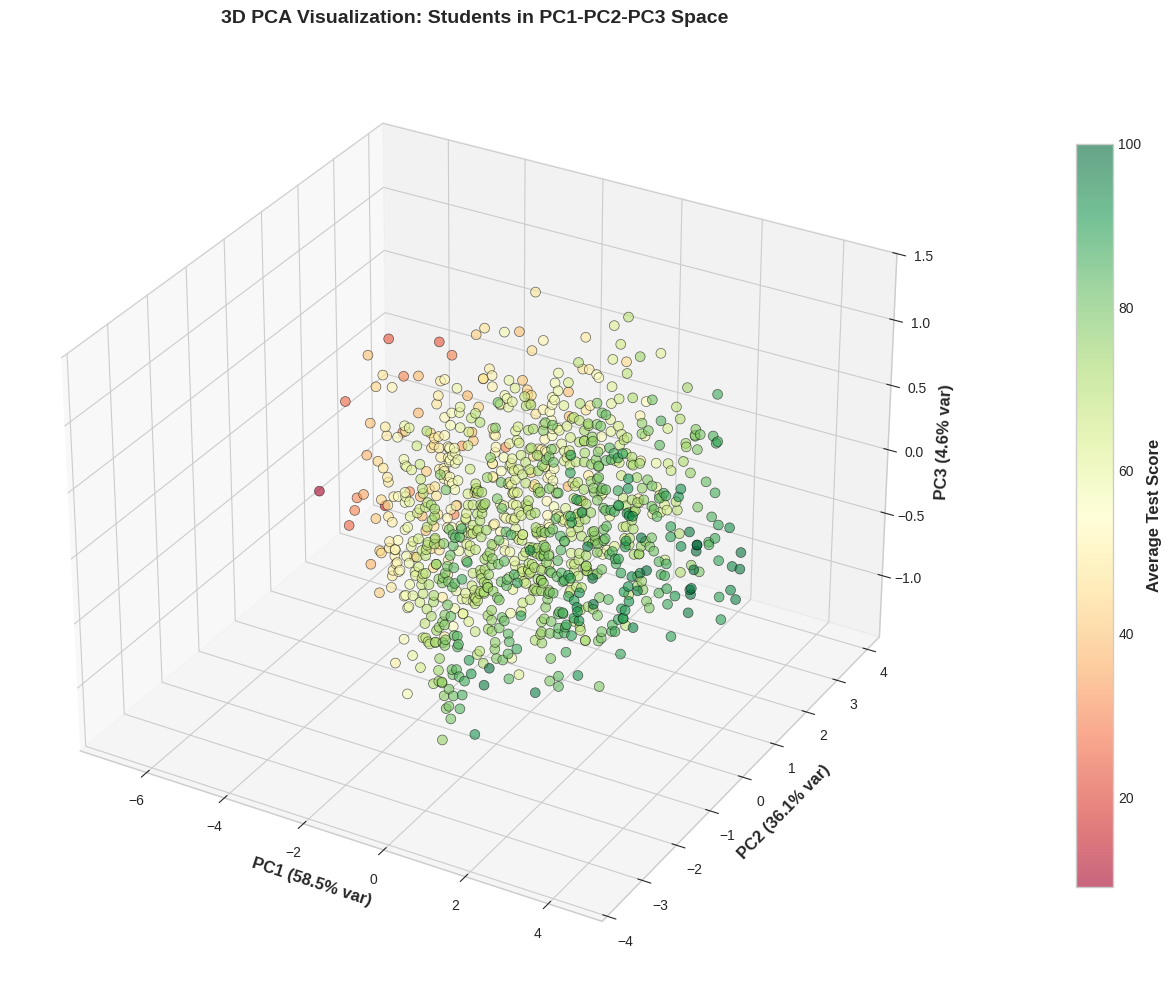


💡 Interpretation:
   • PC1: 58.5% variance - overall academic performance
   • PC2: 36.1% variance - parental education vs. test scores
   • PC3: 4.6% variance - math vs. verbal skills
   • Together, these 3 PCs capture 99.1% of total variance


In [66]:
# ------------------------------------------------------------------------------
# Step 3: Create 3D Visualization (PC1, PC2, PC3)
# ------------------------------------------------------------------------------
print("\n" + "-" * 70)
print("📊 Creating 3D visualization (PC1, PC2, PC3)...")
print("-" * 70)

# Create 3D plot
fig = plt.figure(figsize=(14, 10))  # Create figure with size 14x10 inches
ax = fig.add_subplot(111, projection='3d')  # Add 3D subplot to figure

# Create 3D scatter plot with same coloring scheme as 2D plot
scatter_3d = ax.scatter(
    pca_df['PC1'],  # x-axis: first principal component
    pca_df['PC2'],  # y-axis: second principal component
    pca_df['PC3'],  # z-axis: third principal component
    c=avg_score,  # Color by average test score
    cmap='RdYlGn',  # Red-Yellow-Green colormap (consistent with 2D)
    s=50,  # Point size = 50
    alpha=0.6,  # 60% opacity for visibility
    edgecolors='black',  # Black border around points
    linewidth=0.5  # Border width = 0.5 pixels
)

# Add colorbar to show average score mapping
cbar = plt.colorbar(scatter_3d, ax=ax, pad=0.1, shrink=0.8)  # Create colorbar with padding and 80% size
cbar.set_label('Average Test Score', fontsize=12, fontweight='bold')  # Label for colorbar

# Add labels for all three axes with variance explained
ax.set_xlabel(f'PC1 ({explained_variance[0]*100:.1f}% var)', fontsize=12, fontweight='bold')  # x-axis label
ax.set_ylabel(f'PC2 ({explained_variance[1]*100:.1f}% var)', fontsize=12, fontweight='bold')  # y-axis label
ax.set_zlabel(f'PC3 ({explained_variance[2]*100:.1f}% var)', fontsize=12, fontweight='bold')  # z-axis label
ax.set_title('3D PCA Visualization: Students in PC1-PC2-PC3 Space', fontsize=14, fontweight='bold', pad=20)  # Title with padding

plt.tight_layout()  # Adjust layout
plt.show()  # Display the 3D plot

print(f"\n💡 Interpretation:")
print(f"   • PC1: {explained_variance[0]*100:.1f}% variance - overall academic performance")
print(f"   • PC2: {explained_variance[1]*100:.1f}% variance - parental education vs. test scores")
print(f"   • PC3: {explained_variance[2]*100:.1f}% variance - math vs. verbal skills")
print(f"   • Together, these 3 PCs capture {sum(explained_variance[:3])*100:.1f}% of total variance")


In [67]:
# Create interactive 3D visualization using plotly for better exploration
import plotly.graph_objects as go  # Import plotly for interactive plots

fig = go.Figure(data=[go.Scatter3d(  # Create 3D scatter plot object
    x=pca_df['PC1'],  # x-axis: first principal component
    y=pca_df['PC2'],  # y-axis: second principal component
    z=pca_df['PC3'],  # z-axis: third principal component
    mode='markers',  # Display as markers (points)
    marker=dict(  # Configure marker appearance
        size=6,  # Marker size = 6
        color=avg_score,  # Color by average test score
        colorscale='RdYlGn',  # Red-Yellow-Green color scale
        opacity=0.8,  # 80% opacity
        colorbar=dict(title='Average Test Score')  # Colorbar title
    )
)])

# Configure plot layout
fig.update_layout(
    title='Interactive 3D PCA Visualization (PC1, PC2, PC3)',  # Plot title
    scene=dict(  # 3D scene configuration
        xaxis_title=f'PC1 ({explained_variance[0]*100:.1f}% var)',  # x-axis title with variance
        yaxis_title=f'PC2 ({explained_variance[1]*100:.1f}% var)',  # y-axis title with variance
        zaxis_title=f'PC3 ({explained_variance[2]*100:.1f}% var)'  # z-axis title with variance
    ),
    width=900, height=700  # Figure dimensions in pixels
)

fig.show()  # Display interactive plot (can rotate, zoom, pan)


In [68]:
# ------------------------------------------------------------------------------
# Step 4: Additional Analysis - Show extreme points
# ------------------------------------------------------------------------------
print("\n" + "-" * 70)
print("🔍 IDENTIFYING EXTREME STUDENTS IN PCA SPACE")
print("-" * 70)

# Find students at extremes of each principal component
extreme_indices = {
    'Highest PC1': pca_df['PC1'].idxmax(),  # Student with maximum PC1 score (highest overall performance)
    'Lowest PC1': pca_df['PC1'].idxmin(),  # Student with minimum PC1 score (lowest overall performance)
    'Highest PC2': pca_df['PC2'].idxmax(),  # Student with maximum PC2 score
    'Lowest PC2': pca_df['PC2'].idxmin()  # Student with minimum PC2 score
}

print("\n📊 Extreme Students in Principal Component Space:")
print("=" * 70)

for label, idx in extreme_indices.items():  # Iterate through extreme students
    print(f"\n{label} (Student #{idx}):")  # Print label and student index
    print(f"  PC1: {pca_df.loc[idx, 'PC1']:.2f}")  # Print PC1 score (2 decimal places)
    print(f"  PC2: {pca_df.loc[idx, 'PC2']:.2f}")  # Print PC2 score (2 decimal places)
    print(f"  Original Features:")  # Show original feature values for context
    print(f"    • Parental Education: {df_processed.loc[idx, 'parental_education_ordinal']}")  # Education level (0-5)
    print(f"    • Math Score: {df_processed.loc[idx, 'math score']}")  # Math exam score
    print(f"    • Reading Score: {df_processed.loc[idx, 'reading score']}")  # Reading exam score
    print(f"    • Writing Score: {df_processed.loc[idx, 'writing score']}")  # Writing exam score



----------------------------------------------------------------------
🔍 IDENTIFYING EXTREME STUDENTS IN PCA SPACE
----------------------------------------------------------------------

📊 Extreme Students in Principal Component Space:

Highest PC1 (Student #685):
  PC1: 4.45
  PC2: 0.82
  Original Features:
    • Parental Education: 5
    • Math Score: 94
    • Reading Score: 99
    • Writing Score: 100

Lowest PC1 (Student #59):
  PC1: -6.91
  PC2: 1.57
  Original Features:
    • Parental Education: 0
    • Math Score: 0
    • Reading Score: 17
    • Writing Score: 10

Highest PC2 (Student #18):
  PC1: -0.89
  PC2: 3.87
  Original Features:
    • Parental Education: 5
    • Math Score: 46
    • Reading Score: 42
    • Writing Score: 46

Lowest PC2 (Student #179):
  PC1: 2.10
  PC2: -3.60
  Original Features:
    • Parental Education: 0
    • Math Score: 97
    • Reading Score: 100
    • Writing Score: 100


In [69]:
# Find optimal number of clusters using multiple evaluation metrics
print("🔍 FINDING OPTIMAL NUMBER OF CLUSTERS")
print("=" * 60)
print("⚠️  REVISION: Clustering on X_scaled (4D original), NOT PCA components")
print("Testing K from 2 to 10...\n")

K_range = range(2, 11)  # Test cluster counts from 2 to 10
metrics = {  # Dictionary to store evaluation metrics for each K
    'inertia': [],  # Within-cluster sum of squares (lower is better)
    'silhouette': [],  # Average silhouette score (higher is better, range -1 to 1)
    'davies_bouldin': [],  # Davies-Bouldin index (lower is better)
    'calinski_harabasz': []  # Calinski-Harabasz score (higher is better)
}

for k in K_range:  # Iterate through each value of K
    # Fit K-Means on ORIGINAL 4D data (X_final), NOT PCA-reduced data
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)  # Initialize K-Means with k clusters, 10 random initializations
    labels = kmeans.fit_predict(X_final)  # Fit K-Means and predict cluster labels for all points

    # Calculate all evaluation metrics on ORIGINAL 4D data
    metrics['inertia'].append(kmeans.inertia_)  # Sum of squared distances to nearest cluster center
    metrics['silhouette'].append(silhouette_score(X_final, labels))  # Mean silhouette coefficient over all samples
    metrics['davies_bouldin'].append(davies_bouldin_score(X_final, labels))  # Average similarity ratio of each cluster with its most similar cluster
    metrics['calinski_harabasz'].append(calinski_harabasz_score(X_final, labels))  # Ratio of between-cluster to within-cluster variance

    # Print metrics for current K value
    print(f"K={k}: Silhouette={metrics['silhouette'][-1]:.3f}, "  # Display silhouette score (3 decimals)
          f"Davies-Bouldin={metrics['davies_bouldin'][-1]:.3f}, "  # Display DB index (3 decimals)
          f"Calinski-Harabasz={metrics['calinski_harabasz'][-1]:.1f}")  # Display CH score (1 decimal)

# Analyze the metrics more comprehensively to find optimal K
print("\n" + "=" * 60)
print("📊 COMPREHENSIVE METRIC ANALYSIS")
print("=" * 60)

# Find candidate optimal K values based on different metrics
optimal_silhouette = list(K_range)[metrics['silhouette'].index(max(metrics['silhouette']))]  # K with highest silhouette score
optimal_davies_bouldin = list(K_range)[metrics['davies_bouldin'].index(min(metrics['davies_bouldin']))]  # K with lowest DB index
optimal_calinski = list(K_range)[metrics['calinski_harabasz'].index(max(metrics['calinski_harabasz']))]  # K with highest CH score

print(f"\n🎯 Metric-based recommendations:")
print(f"  • Silhouette Score suggests: K={optimal_silhouette} (score={max(metrics['silhouette']):.3f})")  # Best K by silhouette
print(f"  • Davies-Bouldin Index suggests: K={optimal_davies_bouldin} (score={min(metrics['davies_bouldin']):.3f})")  # Best K by DB
print(f"  • Calinski-Harabasz Score suggests: K={optimal_calinski} (score={max(metrics['calinski_harabasz']):.1f})")  # Best K by CH

# Use consensus or pick based on silhouette (most commonly used metric)
optimal_k = optimal_silhouette  # Choose K based on silhouette score

print(f"\n✅ FINAL DECISION: K={optimal_k}")
print(f"   Reason: Highest silhouette score indicates best-defined clusters")


🔍 FINDING OPTIMAL NUMBER OF CLUSTERS
⚠️  REVISION: Clustering on X_scaled (4D original), NOT PCA components
Testing K from 2 to 10...

K=2: Silhouette=0.323, Davies-Bouldin=1.185, Calinski-Harabasz=584.5
K=3: Silhouette=0.323, Davies-Bouldin=1.031, Calinski-Harabasz=628.9
K=4: Silhouette=0.323, Davies-Bouldin=0.937, Calinski-Harabasz=635.4
K=5: Silhouette=0.303, Davies-Bouldin=1.048, Calinski-Harabasz=585.3
K=6: Silhouette=0.305, Davies-Bouldin=0.993, Calinski-Harabasz=568.0
K=7: Silhouette=0.300, Davies-Bouldin=0.987, Calinski-Harabasz=565.3
K=8: Silhouette=0.292, Davies-Bouldin=1.016, Calinski-Harabasz=552.8
K=9: Silhouette=0.292, Davies-Bouldin=1.019, Calinski-Harabasz=551.6
K=10: Silhouette=0.289, Davies-Bouldin=1.062, Calinski-Harabasz=543.1

📊 COMPREHENSIVE METRIC ANALYSIS

🎯 Metric-based recommendations:
  • Silhouette Score suggests: K=2 (score=0.323)
  • Davies-Bouldin Index suggests: K=4 (score=0.937)
  • Calinski-Harabasz Score suggests: K=4 (score=635.4)

✅ FINAL DECISION: 

## Mathematical Foundation: K-Means Clustering & Evaluation Metrics

### Part 1: K-Means Clustering Algorithm

**K-Means** is a partition-based clustering algorithm that divides $n$ data points into $k$ clusters by minimizing within-cluster variance.

#### Objective Function

Minimize the **Within-Cluster Sum of Squares (WCSS)**, also called **inertia**:

$$
J = \sum_{i=1}^{k} \sum_{\mathbf{x} \in C_i} \|\mathbf{x} - \boldsymbol{\mu}_i\|^2
$$

where:
- $k$ = number of clusters
- $C_i$ = set of points in cluster $i$
- $\boldsymbol{\mu}_i = \frac{1}{|C_i|}\sum_{\mathbf{x} \in C_i} \mathbf{x}$ = centroid (mean) of cluster $i$
- $\|\mathbf{x} - \boldsymbol{\mu}_i\|^2$ = squared Euclidean distance from point $\mathbf{x}$ to centroid $\boldsymbol{\mu}_i$

#### Algorithm Steps

1. **Initialize**: Randomly select $k$ points as initial centroids $\boldsymbol{\mu}_1, \boldsymbol{\mu}_2, \ldots, \boldsymbol{\mu}_k$

2. **Assignment Step**: Assign each point to the nearest centroid
   $$
   C_i = \{\mathbf{x}_j : \|\mathbf{x}_j - \boldsymbol{\mu}_i\| \leq \|\mathbf{x}_j - \boldsymbol{\mu}_l\| \text{ for all } l = 1, \ldots, k\}
   $$

3. **Update Step**: Recalculate centroids as the mean of assigned points
   $$
   \boldsymbol{\mu}_i = \frac{1}{|C_i|} \sum_{\mathbf{x} \in C_i} \mathbf{x}
   $$

4. **Repeat** steps 2-3 until convergence (centroids no longer change or maximum iterations reached)

#### Convergence Criterion

The algorithm converges when:
$$
\sum_{i=1}^{k} \|\boldsymbol{\mu}_i^{(t)} - \boldsymbol{\mu}_i^{(t-1)}\| < \epsilon
$$
where $\epsilon$ is a small threshold (e.g., $10^{-4}$) and $t$ is the iteration number.

---

### Part 2: Inertia (Within-Cluster Sum of Squares)

**Inertia** measures how internally coherent clusters are (lower is better).

$$
\text{Inertia} = \sum_{i=1}^{k} \sum_{\mathbf{x} \in C_i} \|\mathbf{x} - \boldsymbol{\mu}_i\|^2
$$

Expanding the Euclidean distance:
$$
\|\mathbf{x} - \boldsymbol{\mu}_i\|^2 = \sum_{j=1}^{d} (x_j - \mu_{ij})^2
$$

where $d$ is the number of dimensions (features).

**Interpretation**:
- Lower inertia → tighter clusters
- Always decreases as $k$ increases (minimum = 0 when $k = n$)
- Used in **Elbow Method**: plot inertia vs. $k$, choose $k$ at the "elbow" (point of diminishing returns)

---

### Part 3: Silhouette Score

The **Silhouette coefficient** measures how similar a point is to its own cluster compared to other clusters.

#### For a Single Point

For point $\mathbf{x}_i$ in cluster $C_I$:

$$
s(i) = \frac{b(i) - a(i)}{\max(a(i), b(i))}
$$

where:

- **$a(i)$ = average intra-cluster distance** (how close $\mathbf{x}_i$ is to points in its own cluster):
  $$
  a(i) = \frac{1}{|C_I| - 1} \sum_{\mathbf{x}_j \in C_I, j \neq i} \|\mathbf{x}_i - \mathbf{x}_j\|
  $$

- **$b(i)$ = average nearest-cluster distance** (smallest average distance to any other cluster):
  $$
  b(i) = \min_{J \neq I} \frac{1}{|C_J|} \sum_{\mathbf{x}_j \in C_J} \|\mathbf{x}_i - \mathbf{x}_j\|
  $$

#### Overall Silhouette Score

Average over all points:
$$
\text{Silhouette Score} = \frac{1}{n} \sum_{i=1}^{n} s(i)
$$

**Interpretation**:
- **$s(i) \approx 1$**: Point is well-matched to its cluster and poorly-matched to neighboring clusters (good)
- **$s(i) \approx 0$**: Point is on or very close to the decision boundary between clusters (ambiguous)
- **$s(i) \approx -1$**: Point might be assigned to the wrong cluster (bad)

**Range**: $-1 \leq s(i) \leq 1$ (higher is better)

---

### Part 4: Davies-Bouldin Index

The **Davies-Bouldin Index** measures the average similarity ratio of each cluster with its most similar cluster (lower is better).

#### Formula

$$
\text{DB} = \frac{1}{k} \sum_{i=1}^{k} \max_{j \neq i} R_{ij}
$$

where $R_{ij}$ is the similarity ratio between clusters $i$ and $j$:

$$
R_{ij} = \frac{S_i + S_j}{M_{ij}}
$$

**Components**:

- **$S_i$ = average within-cluster distance** (cluster scatter):
  $$
  S_i = \frac{1}{|C_i|} \sum_{\mathbf{x} \in C_i} \|\mathbf{x} - \boldsymbol{\mu}_i\|
  $$

- **$M_{ij}$ = between-cluster distance** (separation):
  $$
  M_{ij} = \|\boldsymbol{\mu}_i - \boldsymbol{\mu}_j\|
  $$

#### Mathematical Interpretation

$R_{ij}$ compares:
- **Numerator** $S_i + S_j$: Sum of within-cluster spreads (larger → more scattered clusters)
- **Denominator** $M_{ij}$: Distance between centroids (larger → well-separated clusters)

$$
R_{ij} = \frac{\text{within-cluster spread}}{\text{between-cluster separation}}
$$

**Interpretation**:
- **Lower DB** → clusters are compact (small $S_i$) and well-separated (large $M_{ij}$)
- **Higher DB** → clusters are scattered or poorly separated
- **Range**: $[0, \infty)$ (lower is better)

---

### Part 5: Calinski-Harabasz Score (Variance Ratio Criterion)

The **Calinski-Harabasz Index** is the ratio of between-cluster dispersion to within-cluster dispersion (higher is better).

#### Formula

$$
\text{CH} = \frac{\text{SS}_B / (k-1)}{\text{SS}_W / (n-k)} = \frac{n-k}{k-1} \cdot \frac{\text{SS}_B}{\text{SS}_W}
$$

where:
- $n$ = total number of points
- $k$ = number of clusters

**Components**:

1. **Between-cluster sum of squares** ($\text{SS}_B$):
   $$
   \text{SS}_B = \sum_{i=1}^{k} |C_i| \|\boldsymbol{\mu}_i - \boldsymbol{\mu}\|^2
   $$
   where $\boldsymbol{\mu} = \frac{1}{n}\sum_{j=1}^{n} \mathbf{x}_j$ is the global centroid (mean of all points).

2. **Within-cluster sum of squares** ($\text{SS}_W$):
   $$
   \text{SS}_W = \sum_{i=1}^{k} \sum_{\mathbf{x} \in C_i} \|\mathbf{x} - \boldsymbol{\mu}_i\|^2
   $$
   (This is the same as Inertia!)

#### Total Sum of Squares

Total variance in the data:
$$
\text{SS}_T = \sum_{i=1}^{n} \|\mathbf{x}_i - \boldsymbol{\mu}\|^2 = \text{SS}_B + \text{SS}_W
$$

#### Mathematical Derivation

The CH score can be understood through ANOVA (Analysis of Variance):

1. **Between-cluster variance**:
   $$
   \sigma_B^2 = \frac{\text{SS}_B}{k-1}
   $$

2. **Within-cluster variance**:
   $$
   \sigma_W^2 = \frac{\text{SS}_W}{n-k}
   $$

3. **F-statistic analogy**:
   $$
   \text{CH} = \frac{\sigma_B^2}{\sigma_W^2}
   $$

**Interpretation**:
- **Higher CH** → large between-cluster variance (clusters far apart) and small within-cluster variance (tight clusters)
- **Lower CH** → clusters are not well-defined
- **Range**: $[0, \infty)$ (higher is better)

#### Relationship to R²

The clustering quality can be measured as:
$$
R^2 = \frac{\text{SS}_B}{\text{SS}_T} = 1 - \frac{\text{SS}_W}{\text{SS}_T}
$$

Higher CH correlates with higher $R^2$ (proportion of variance explained by clustering).

---

### Comparison of Metrics

| Metric | Range | Better | Considers | Pros | Cons |
|--------|-------|--------|-----------|------|------|
| **Inertia** | $[0, \infty)$ | Lower | Within-cluster distance | Simple, fast | Always decreases with $k$; no separation measure |
| **Silhouette** | $[-1, 1]$ | Higher | Both cohesion & separation | Intuitive, balanced | Computationally expensive for large datasets |
| **Davies-Bouldin** | $[0, \infty)$ | Lower | Both cohesion & separation | Considers worst-case cluster pair | Sensitive to outliers |
| **Calinski-Harabasz** | $[0, \infty)$ | Higher | Both cohesion & separation | Fast to compute, based on variance ratio | Biased toward convex clusters |

---

### In This Analysis

We test $k \in \{2, 3, \ldots, 10\}$ and compute all four metrics on the **original 4D feature space** (not PCA-reduced). The optimal $k$ is chosen based on many score, which provides the best balance between cluster cohesion and separation.


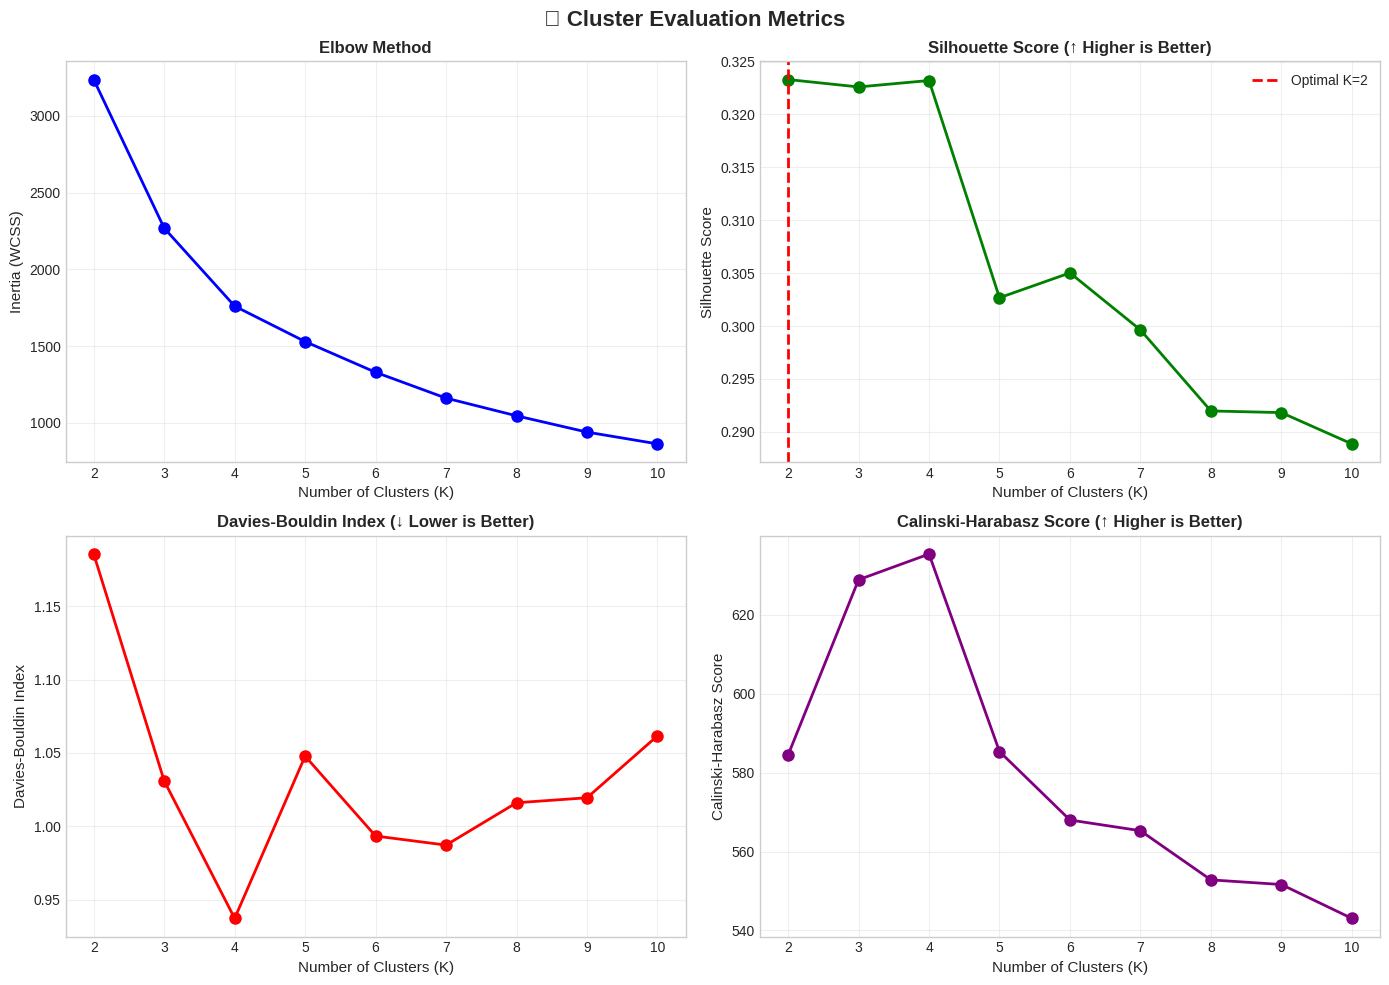


💡 How to interpret:
  - Elbow: Look for the 'elbow' point where inertia starts decreasing slowly
  - Silhouette: Pick K with highest score (good separation & cohesion)
  - Davies-Bouldin: Pick K with lowest score (well-separated clusters)
  - Calinski-Harabasz: Pick K with highest score (dense, well-separated clusters)


In [70]:
# Visualize all cluster evaluation metrics to help choose optimal K
fig, axes = plt.subplots(2, 2, figsize=(14, 10))  # Create 2x2 grid of subplots
fig.suptitle('📊 Cluster Evaluation Metrics', fontsize=16, fontweight='bold')  # Main title

# Plot 1: Elbow Method (Inertia/WCSS)
ax = axes[0, 0]  # Top-left subplot
ax.plot(K_range, metrics['inertia'], marker='o', linewidth=2, markersize=8, color='blue')  # Line plot with circular markers
ax.set_xlabel('Number of Clusters (K)', fontsize=11)  # x-axis label
ax.set_ylabel('Inertia (WCSS)', fontsize=11)  # y-axis label (Within-Cluster Sum of Squares)
ax.set_title('Elbow Method', fontsize=12, fontweight='bold')  # Subplot title
ax.grid(alpha=0.3)  # Add gridlines with 30% opacity
ax.set_xticks(K_range)  # Show all K values on x-axis

# Plot 2: Silhouette Score (higher is better)
ax = axes[0, 1]  # Top-right subplot
ax.plot(K_range, metrics['silhouette'], marker='o', linewidth=2, markersize=8, color='green')  # Green line plot
ax.axvline(x=optimal_k, color='red', linestyle='--', linewidth=2, label=f'Optimal K={optimal_k}')  # Vertical line at optimal K
ax.set_xlabel('Number of Clusters (K)', fontsize=11)  # x-axis label
ax.set_ylabel('Silhouette Score', fontsize=11)  # y-axis label
ax.set_title('Silhouette Score (↑ Higher is Better)', fontsize=12, fontweight='bold')  # Subplot title
ax.legend()  # Show legend for optimal K line
ax.grid(alpha=0.3)  # Add gridlines
ax.set_xticks(K_range)  # Show all K values

# Plot 3: Davies-Bouldin Index (lower is better)
ax = axes[1, 0]  # Bottom-left subplot
ax.plot(K_range, metrics['davies_bouldin'], marker='o', linewidth=2, markersize=8, color='red')  # Red line plot
ax.set_xlabel('Number of Clusters (K)', fontsize=11)  # x-axis label
ax.set_ylabel('Davies-Bouldin Index', fontsize=11)  # y-axis label
ax.set_title('Davies-Bouldin Index (↓ Lower is Better)', fontsize=12, fontweight='bold')  # Subplot title
ax.grid(alpha=0.3)  # Add gridlines
ax.set_xticks(K_range)  # Show all K values

# Plot 4: Calinski-Harabasz Score (higher is better)
ax = axes[1, 1]  # Bottom-right subplot
ax.plot(K_range, metrics['calinski_harabasz'], marker='o', linewidth=2, markersize=8, color='purple')  # Purple line plot
ax.set_xlabel('Number of Clusters (K)', fontsize=11)  # x-axis label
ax.set_ylabel('Calinski-Harabasz Score', fontsize=11)  # y-axis label
ax.set_title('Calinski-Harabasz Score (↑ Higher is Better)', fontsize=12, fontweight='bold')  # Subplot title
ax.grid(alpha=0.3)  # Add gridlines
ax.set_xticks(K_range)  # Show all K values

plt.tight_layout()  # Adjust spacing to prevent overlap
plt.show()  # Display the figure

print("\n💡 How to interpret:")
print("  - Elbow: Look for the 'elbow' point where inertia starts decreasing slowly")  # Diminishing returns point
print("  - Silhouette: Pick K with highest score (good separation & cohesion)")  # Best overall cluster quality
print("  - Davies-Bouldin: Pick K with lowest score (well-separated clusters)")  # Minimizes cluster similarity
print("  - Calinski-Harabasz: Pick K with highest score (dense, well-separated clusters)")  # Maximizes variance ratio


In [71]:
# Apply K-Means clustering with the optimal number of clusters
print("🎯 K-MEANS CLUSTERING")
print("=" * 60)
print("⚠️  REVISION: Clustering on X_scaled (4D), then project to PCA for visualization\n")

optimal_k = 4  # Set optimal number of clusters determined earlier

# Track computational performance
import tracemalloc
tracemalloc.start()
process = psutil.Process()
mem_before = process.memory_info().rss / 1024 / 1024  # MB

# Training time
start_train = time.perf_counter()

# Fit K-Means with optimal K on ORIGINAL 4D data (not PCA-reduced)
kmeans = KMeans(n_clusters=optimal_k, random_state=42, n_init=20, max_iter=300)  # Initialize: 20 random starts, max 300 iterations
kmeans_labels = kmeans.fit_predict(X_final)  # Fit K-Means and predict cluster labels for all points

end_train = time.perf_counter()
training_time = end_train - start_train

# Memory usage
mem_after = process.memory_info().rss / 1024 / 1024  # MB
memory_used = mem_after - mem_before
current, peak = tracemalloc.get_traced_memory()
tracemalloc.stop()
peak_memory = peak / 1024 / 1024  # MB

# Inference time (predict on sample data for measurement)
start_infer = time.perf_counter()
_ = kmeans.predict(X_final[:100])  # Predict on first 100 samples
end_infer = time.perf_counter()
inference_time = (end_infer - start_infer) / 100 * 1000  # ms per sample

# Store metrics for comparison
kmeans_train_time = training_time
kmeans_infer_time = inference_time
kmeans_memory = peak_memory

# Store cluster labels in dataframe for later analysis
df_processed['kmeans_cluster'] = kmeans_labels  # Add cluster assignments as new column

# Calculate evaluation metrics on ORIGINAL 4D data
silhouette_kmeans = silhouette_score(X_final, kmeans_labels)  # Compute silhouette score
davies_bouldin_kmeans = davies_bouldin_score(X_final, kmeans_labels)  # Compute Davies-Bouldin index
calinski_harabasz_kmeans = calinski_harabasz_score(X_final, kmeans_labels)  # Compute Calinski-Harabasz score

print(f"✅ Clustering completed with K={optimal_k}")
print(f"   • Clustered on: X_scaled (4D original features)")  # Emphasize we used full 4D space
print(f"   • Features: {feature_names}")  # List feature names
print(f"\n📊 Evaluation Metrics (on original 4D space):")
print(f"  • Silhouette Score: {silhouette_kmeans:.4f}")  # Higher is better (max 1)
print(f"  • Davies-Bouldin Index: {davies_bouldin_kmeans:.4f}")  # Lower is better (min 0)
print(f"  • Calinski-Harabasz Score: {calinski_harabasz_kmeans:.2f}")  # Higher is better
print(f"  • Inertia (WCSS): {kmeans.inertia_:.2f}")  # Within-cluster sum of squares

print(f"\n📊 Computational Performance:")
print(f"  • Training Time: {training_time:.4f} seconds")
print(f"  • Inference Time: {inference_time:.4f} ms/sample")
print(f"  • Memory Usage: {peak_memory:.2f} MB")

# Cluster size distribution
print(f"\n📊 Cluster Size Distribution:")
for i in range(optimal_k):  # Iterate through each cluster
    count = (kmeans_labels == i).sum()  # Count points in cluster i
    percentage = (count / len(kmeans_labels)) * 100  # Calculate percentage
    print(f"  Cluster {i}: {count} students ({percentage:.1f}%)")  # Display cluster size


🎯 K-MEANS CLUSTERING
⚠️  REVISION: Clustering on X_scaled (4D), then project to PCA for visualization

✅ Clustering completed with K=4
   • Clustered on: X_scaled (4D original features)
   • Features: ['Parental Education', 'Math Score', 'Reading Score', 'Writing Score']

📊 Evaluation Metrics (on original 4D space):
  • Silhouette Score: 0.3232
  • Davies-Bouldin Index: 0.9372
  • Calinski-Harabasz Score: 635.38
  • Inertia (WCSS): 1760.76

📊 Computational Performance:
  • Training Time: 0.1453 seconds
  • Inference Time: 0.0034 ms/sample
  • Memory Usage: 0.16 MB

📊 Cluster Size Distribution:
  Cluster 0: 277 students (27.7%)
  Cluster 1: 188 students (18.8%)
  Cluster 2: 225 students (22.5%)
  Cluster 3: 310 students (31.0%)


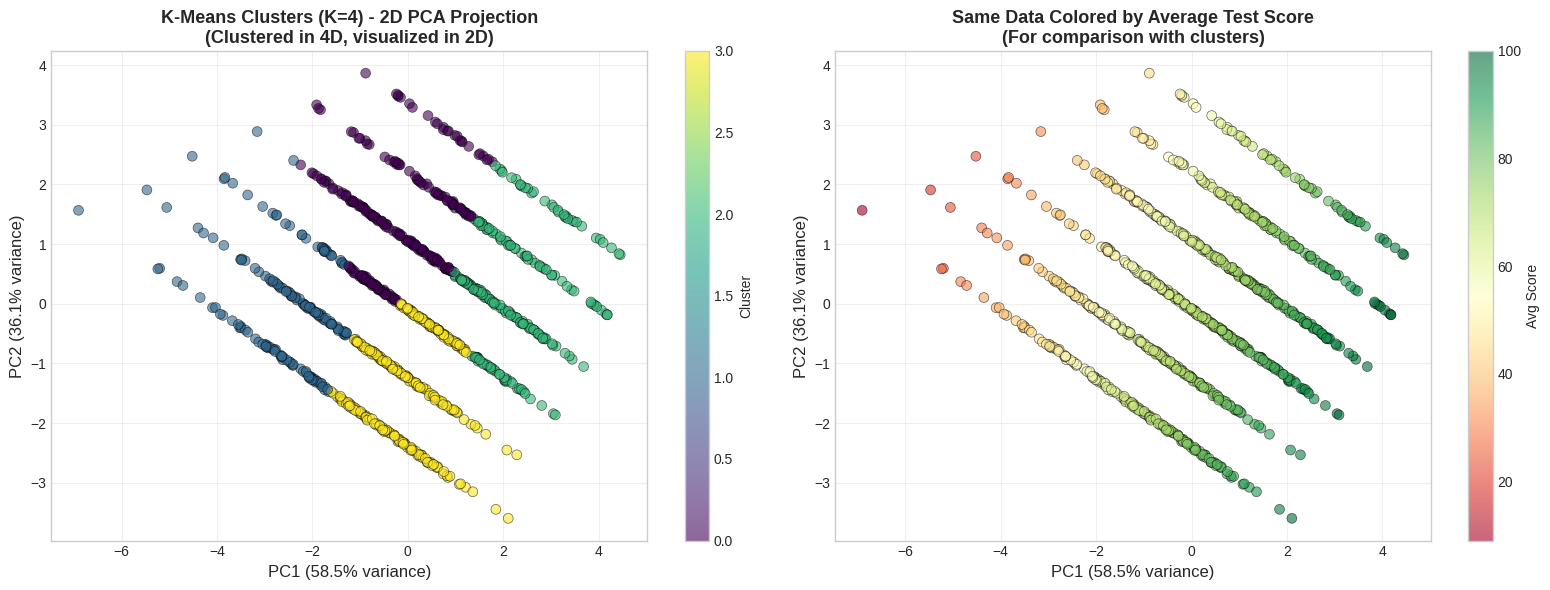

In [72]:
# Visualize K-Means clusters in 2D PCA space
# NOTE: Clusters were formed in 4D, but we project to 2D for visualization
fig, axes = plt.subplots(1, 2, figsize=(16, 6))  # Create 1x2 grid of subplots

# Plot 1: PC1 vs PC2
ax = axes[0]  # Select first subplot
scatter = ax.scatter(X_pca_2d[:, 0], X_pca_2d[:, 1], c=kmeans_labels,  # Scatter plot with cluster colors
                     cmap='viridis', s=50, alpha=0.6, edgecolors='black', linewidth=0.5)  # Viridis colormap, 60% opacity
ax.set_xlabel(f'PC1 ({pca_2d.explained_variance_ratio_[0]*100:.1f}% variance)', fontsize=12)  # x-axis label with variance
ax.set_ylabel(f'PC2 ({pca_2d.explained_variance_ratio_[1]*100:.1f}% variance)', fontsize=12)  # y-axis label with variance
ax.set_title(f'K-Means Clusters (K={optimal_k}) - 2D PCA Projection\n(Clustered in 4D, visualized in 2D)',  # Title
             fontsize=13, fontweight='bold')  # Bold title
ax.grid(alpha=0.3)  # Add gridlines with 30% opacity
plt.colorbar(scatter, ax=ax, label='Cluster')  # Add colorbar showing cluster numbers

# Plot 2: PC1 vs PC2 colored by average test score for comparison
ax = axes[1]  # Select second subplot
scatter2 = ax.scatter(X_pca_2d[:, 0], X_pca_2d[:, 1], c=avg_score,  # Scatter plot colored by average score
                      cmap='RdYlGn', s=50, alpha=0.6, edgecolors='black', linewidth=0.5)  # Red-Yellow-Green colormap
ax.set_xlabel(f'PC1 ({pca_2d.explained_variance_ratio_[0]*100:.1f}% variance)', fontsize=12)  # x-axis label
ax.set_ylabel(f'PC2 ({pca_2d.explained_variance_ratio_[1]*100:.1f}% variance)', fontsize=12)  # y-axis label
ax.set_title('Same Data Colored by Average Test Score\n(For comparison with clusters)',  # Title
             fontsize=13, fontweight='bold')  # Bold title
ax.grid(alpha=0.3)  # Add gridlines
plt.colorbar(scatter2, ax=ax, label='Avg Score')  # Add colorbar showing average scores

plt.tight_layout()  # Adjust spacing
plt.show()  # Display figure


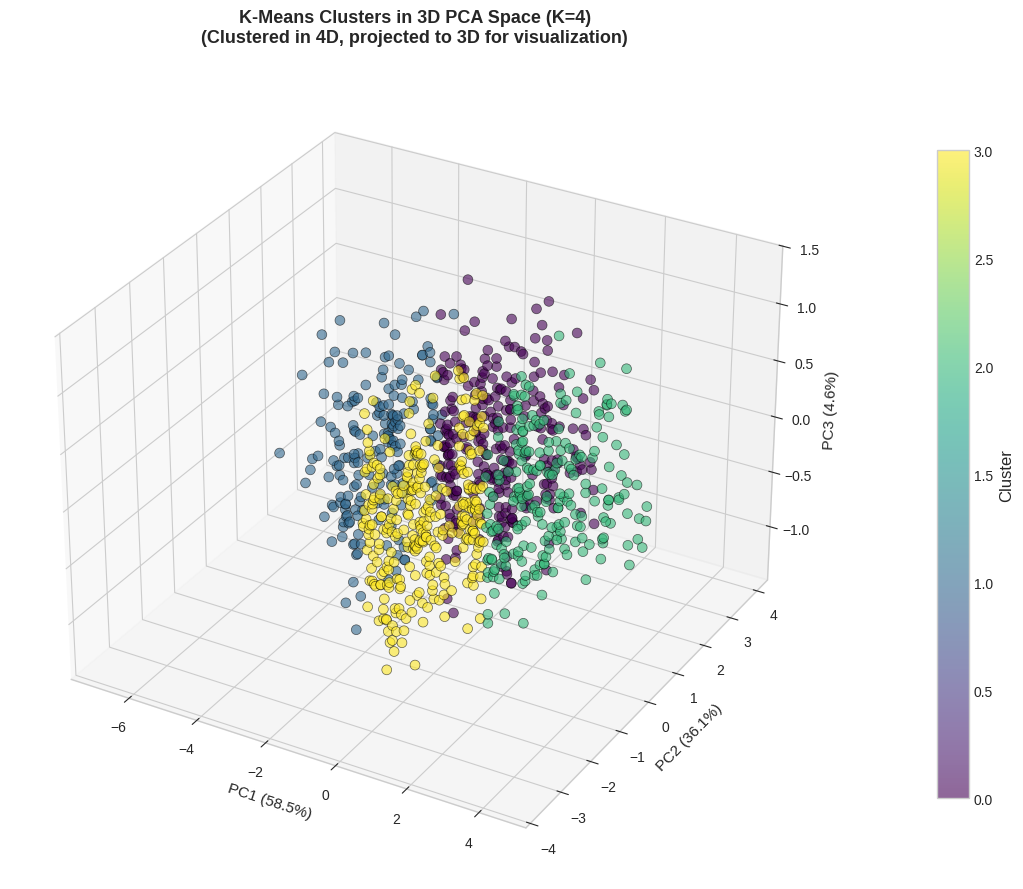

In [73]:
# Visualize K-Means clusters in 3D PCA space
fig = plt.figure(figsize=(12, 9))  # Create figure with size 12x9 inches
ax = fig.add_subplot(111, projection='3d')  # Add 3D subplot

# Plot points (clusters formed in 4D, projected to 3D PCA for visualization)
scatter = ax.scatter(X_pca_viz[:, 0], X_pca_viz[:, 1], X_pca_viz[:, 2],  # 3D scatter plot (PC1, PC2, PC3)
                     c=kmeans_labels, cmap='viridis', s=50, alpha=0.6,  # Color by cluster, viridis colormap
                     edgecolors='black', linewidth=0.5)  # Black edges, 0.5 pixel width

# Label axes with variance explained
ax.set_xlabel(f'PC1 ({pca_viz.explained_variance_ratio_[0]*100:.1f}%)', fontsize=11)  # x-axis label
ax.set_ylabel(f'PC2 ({pca_viz.explained_variance_ratio_[1]*100:.1f}%)', fontsize=11)  # y-axis label
ax.set_zlabel(f'PC3 ({pca_viz.explained_variance_ratio_[2]*100:.1f}%)', fontsize=11)  # z-axis label
ax.set_title(f'K-Means Clusters in 3D PCA Space (K={optimal_k})\n(Clustered in 4D, projected to 3D for visualization)',  # Title
             fontsize=13, fontweight='bold', pad=20)  # Bold title with padding

# Add colorbar
cbar = plt.colorbar(scatter, ax=ax, pad=0.1, shrink=0.8)  # Colorbar with 10% padding, 80% size
cbar.set_label('Cluster', fontsize=12)  # Colorbar label

plt.tight_layout()  # Adjust layout
plt.show()  # Display 3D plot


In [74]:
# Analyze detailed profile of each K-Means cluster
print("\n" + "=" * 70)
print("📊 DETAILED CLUSTER PROFILE ANALYSIS (K-MEANS)")
print("=" * 70)

for cluster in range(optimal_k):  # Iterate through each cluster
    print(f"\n{'='*70}")
    print(f"🎯 CLUSTER {cluster}")  # Cluster header
    print(f"{'='*70}")

    # Filter data for current cluster
    cluster_data = df_processed[df_processed['kmeans_cluster'] == cluster]  # Select students in this cluster
    n_students = len(cluster_data)  # Count students in cluster
    percentage = (n_students / len(df_processed)) * 100  # Calculate percentage of total

    print(f"\n👥 Size: {n_students} students ({percentage:.1f}% of total)")  # Display cluster size

    # Parental Education Statistics
    print(f"\n📚 PARENTAL EDUCATION BACKGROUND:")
    edu_mean = cluster_data['parental_education_ordinal'].mean()  # Calculate mean education level
    edu_mode = cluster_data['parental_education_ordinal'].mode()[0]  # Find most common education level
    edu_mode_name = education_order[int(edu_mode)]  # Convert ordinal to education name
    print(f"  • Average level: {edu_mean:.2f} / 5.0")  # Display mean education level (0-5 scale)
    print(f"  • Most common: {edu_mode_name} (level {int(edu_mode)})")  # Display mode

    # Education distribution within cluster
    edu_dist = cluster_data['parental level of education'].value_counts()  # Count each education level
    print(f"  • Distribution:")
    for edu, count in edu_dist.items():  # Iterate through education levels
        pct = (count / n_students) * 100  # Calculate percentage within cluster
        print(f"      - {edu}: {count} ({pct:.1f}%)")  # Display count and percentage

    # Exam Score Statistics
    print(f"\n📊 EXAM PERFORMANCE:")
    math_mean = cluster_data['math score'].mean()  # Calculate mean math score
    reading_mean = cluster_data['reading score'].mean()  # Calculate mean reading score
    writing_mean = cluster_data['writing score'].mean()  # Calculate mean writing score
    overall_mean = (math_mean + reading_mean + writing_mean) / 3  # Calculate overall average

    # Display mean ± standard deviation for each subject
    print(f"  • Math:    {math_mean:.1f} ± {cluster_data['math score'].std():.1f}")  # Math: mean ± std
    print(f"  • Reading: {reading_mean:.1f} ± {cluster_data['reading score'].std():.1f}")  # Reading: mean ± std
    print(f"  • Writing: {writing_mean:.1f} ± {cluster_data['writing score'].std():.1f}")  # Writing: mean ± std
    print(f"  • Overall: {overall_mean:.1f}")  # Overall average across three subjects



📊 DETAILED CLUSTER PROFILE ANALYSIS (K-MEANS)

🎯 CLUSTER 0

👥 Size: 277 students (27.7% of total)

📚 PARENTAL EDUCATION BACKGROUND:
  • Average level: 3.18 / 5.0
  • Most common: associate's degree (level 3)
  • Distribution:
      - associate's degree: 127 (45.8%)
      - some college: 63 (22.7%)
      - bachelor's degree: 61 (22.0%)
      - master's degree: 26 (9.4%)

📊 EXAM PERFORMANCE:
  • Math:    58.5 ± 9.2
  • Reading: 62.4 ± 8.1
  • Writing: 61.8 ± 8.9
  • Overall: 60.9

🎯 CLUSTER 1

👥 Size: 188 students (18.8% of total)

📚 PARENTAL EDUCATION BACKGROUND:
  • Average level: 0.82 / 5.0
  • Most common: high school (level 1)
  • Distribution:
      - high school: 81 (43.1%)
      - some high school: 71 (37.8%)
      - some college: 34 (18.1%)
      - associate's degree: 2 (1.1%)

📊 EXAM PERFORMANCE:
  • Math:    48.9 ± 11.8
  • Reading: 50.5 ± 9.5
  • Writing: 48.2 ± 9.7
  • Overall: 49.2

🎯 CLUSTER 2

👥 Size: 225 students (22.5% of total)

📚 PARENTAL EDUCATION BACKGROUND:
  • Av

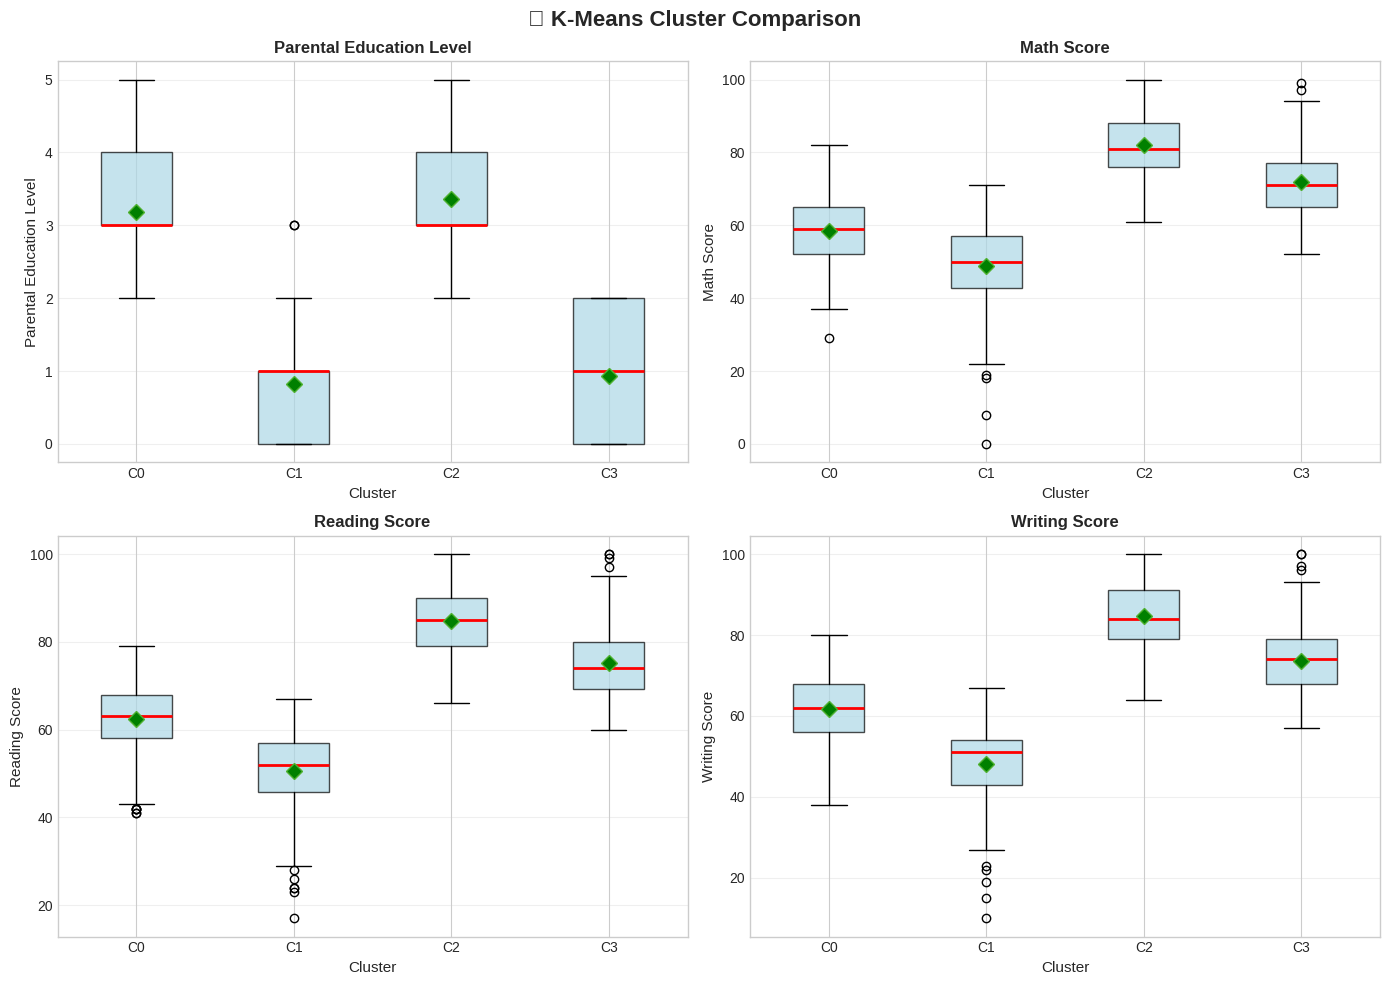

💡 Legend: Red line = median, Green diamond = mean


In [75]:
# Create box plots to compare feature distributions across K-Means clusters
fig, axes = plt.subplots(2, 2, figsize=(14, 10))  # Create 2x2 grid of subplots
fig.suptitle('📊 K-Means Cluster Comparison', fontsize=16, fontweight='bold')  # Main title

# Define features to plot with display names
features_to_plot = [
    ('parental_education_ordinal', 'Parental Education Level'),  # Ordinal feature (0-5)
    ('math score', 'Math Score'),  # Math exam score (0-100)
    ('reading score', 'Reading Score'),  # Reading exam score (0-100)
    ('writing score', 'Writing Score')  # Writing exam score (0-100)
]

for idx, (col, title) in enumerate(features_to_plot):  # Iterate through each feature
    ax = axes[idx // 2, idx % 2]  # Select subplot position (row, column)

    # Prepare data for boxplot: create list of arrays, one per cluster
    data_to_plot = [df_processed[df_processed['kmeans_cluster'] == i][col].values  # Extract feature values for cluster i
                    for i in range(optimal_k)]  # For each cluster

    # Create box plot
    bp = ax.boxplot(data_to_plot, labels=[f'C{i}' for i in range(optimal_k)],  # Label clusters as C0, C1, ...
                    patch_artist=True, showmeans=True,  # Fill boxes, show both median and mean
                    boxprops=dict(facecolor='lightblue', alpha=0.7),  # Light blue boxes with 70% opacity
                    medianprops=dict(color='red', linewidth=2),  # Red line for median
                    meanprops=dict(marker='D', markerfacecolor='green', markersize=8))  # Green diamond for mean

    ax.set_xlabel('Cluster', fontsize=11)  # x-axis label
    ax.set_ylabel(title, fontsize=11)  # y-axis label (feature name)
    ax.set_title(title, fontsize=12, fontweight='bold')  # Subplot title
    ax.grid(axis='y', alpha=0.3)  # Add horizontal gridlines with 30% opacity

plt.tight_layout()  # Adjust spacing to prevent overlap
plt.show()  # Display the figure

print("💡 Legend: Red line = median, Green diamond = mean")  # Explain box plot symbols



🔍 FINDING OPTIMAL K AND LINKAGE FOR HIERARCHICAL CLUSTERING

⏳ Testing different combinations...

✅ Optimal Configuration Found:
   • Optimal K: 2
   • Optimal Linkage: single
   • Silhouette Score: 0.5740
   • Davies-Bouldin: 0.2889
   • Calinski-Harabasz: 9.98

📊 Top 5 Configurations (by Silhouette Score):
 K Linkage  Silhouette  Davies_Bouldin  Calinski_Harabasz
 2  single    0.574034        0.288922           9.978321
 3  single    0.483156        0.329796           8.412743
 4  single    0.326828        0.396661           6.859962
 2 average    0.317021        0.914855         116.559920
 2    ward    0.307670        1.280135         491.503513


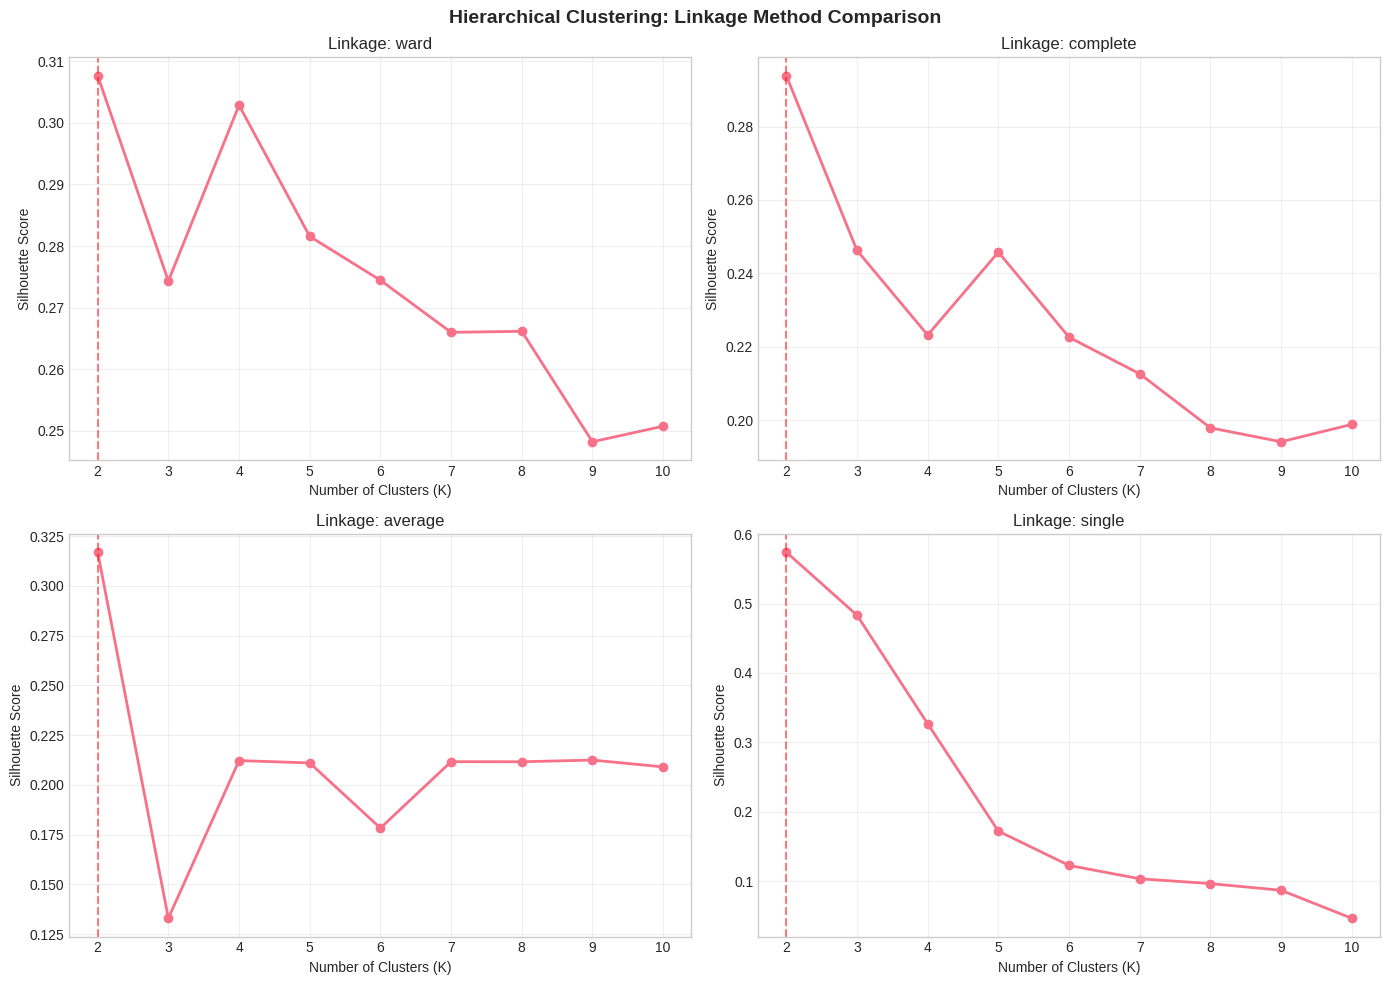

In [76]:
# Find optimal number of clusters and linkage method for Hierarchical Clustering
print("\n" + "=" * 70)
print("🔍 FINDING OPTIMAL K AND LINKAGE FOR HIERARCHICAL CLUSTERING")
print("=" * 70)

# Parameters to test: cluster counts and linkage methods
K_range = range(2, 11)  # Test K from 2 to 10
linkage_methods = ['ward', 'complete', 'average', 'single']  # Four different linkage methods

# Store results for all combinations
hierarchical_results = []  # List to store results for each (K, linkage) combination

print("\n⏳ Testing different combinations...")
for linkage_method in linkage_methods:  # Iterate through each linkage method
    for k in K_range:  # Iterate through each K value
        # Fit hierarchical clustering with current K and linkage method
        hier_model = AgglomerativeClustering(n_clusters=k, linkage=linkage_method)  # Initialize agglomerative clustering
        labels = hier_model.fit_predict(X_final)  # Fit and predict cluster labels on 4D data

        # Calculate evaluation metrics on ORIGINAL 4D data
        sil = silhouette_score(X_final, labels)  # Compute silhouette score
        db = davies_bouldin_score(X_final, labels)  # Compute Davies-Bouldin index
        ch = calinski_harabasz_score(X_final, labels)  # Compute Calinski-Harabasz score

        # Store results for this configuration
        hierarchical_results.append({
            'K': k,  # Number of clusters
            'Linkage': linkage_method,  # Linkage method used
            'Silhouette': sil,  # Silhouette score (higher is better)
            'Davies_Bouldin': db,  # Davies-Bouldin index (lower is better)
            'Calinski_Harabasz': ch  # Calinski-Harabasz score (higher is better)
        })

# Create DataFrame from results for easier analysis
hier_df = pd.DataFrame(hierarchical_results)  # Convert list of dicts to DataFrame

# Find optimal configuration based on highest Silhouette Score
best_hier = hier_df.loc[hier_df['Silhouette'].idxmax()]  # Get row with maximum silhouette score
optimal_k_hier = int(best_hier['K'])  # Extract optimal K
optimal_linkage = best_hier['Linkage']  # Extract optimal linkage method

print(f"\n✅ Optimal Configuration Found:")
print(f"   • Optimal K: {optimal_k_hier}")  # Display optimal number of clusters
print(f"   • Optimal Linkage: {optimal_linkage}")  # Display optimal linkage method
print(f"   • Silhouette Score: {best_hier['Silhouette']:.4f}")  # Display silhouette score
print(f"   • Davies-Bouldin: {best_hier['Davies_Bouldin']:.4f}")  # Display DB index
print(f"   • Calinski-Harabasz: {best_hier['Calinski_Harabasz']:.2f}")  # Display CH score

# Show top 5 configurations ranked by silhouette score
print("\n📊 Top 5 Configurations (by Silhouette Score):")
print(hier_df.sort_values('Silhouette', ascending=False).head(5).to_string(index=False))  # Print top 5 sorted by silhouette

# Visualize how silhouette score varies with K for each linkage method
fig, axes = plt.subplots(2, 2, figsize=(14, 10))  # Create 2x2 grid of subplots
fig.suptitle('Hierarchical Clustering: Linkage Method Comparison', fontsize=14, fontweight='bold')  # Main title

for idx, linkage_method in enumerate(linkage_methods):  # Iterate through each linkage method
    ax = axes[idx // 2, idx % 2]  # Select subplot position
    linkage_data = hier_df[hier_df['Linkage'] == linkage_method]  # Filter data for current linkage method

    # Plot silhouette score vs K
    ax.plot(linkage_data['K'], linkage_data['Silhouette'], marker='o', label='Silhouette', linewidth=2)  # Line plot with markers
    ax.set_xlabel('Number of Clusters (K)')  # x-axis label
    ax.set_ylabel('Silhouette Score')  # y-axis label
    ax.set_title(f'Linkage: {linkage_method}')  # Subplot title showing linkage method
    ax.grid(alpha=0.3)  # Add gridlines
    ax.set_xticks(K_range)  # Show all K values on x-axis

    # Mark optimal K for this linkage method
    best_k_for_linkage = linkage_data.loc[linkage_data['Silhouette'].idxmax(), 'K']  # Find K with highest silhouette for this linkage
    ax.axvline(x=best_k_for_linkage, color='red', linestyle='--', alpha=0.5)  # Add vertical line at optimal K

plt.tight_layout()  # Adjust spacing
plt.show()  # Display figure


## Mathematical Foundation: Hierarchical Agglomerative Clustering

**Hierarchical Agglomerative Clustering** is a bottom-up clustering approach that builds a tree-like structure (dendrogram) by successively merging clusters.

### Algorithm Overview

1. **Initialize**: Start with each point as its own cluster (n clusters)
2. **Merge**: Repeatedly merge the two closest clusters
3. **Repeat**: Continue until all points are in one cluster (or desired k clusters remain)
4. **Cut**: Cut the dendrogram at height corresponding to k clusters

---

### Part 1: Distance Between Clusters (Linkage Methods)

The key decision is: **How do we measure distance between clusters?**

Given two clusters $C_i$ and $C_j$, different **linkage methods** define cluster distance differently:

#### 1. Single Linkage (Minimum Linkage)

Distance = **minimum** distance between any two points in different clusters:

$$
d_{\text{single}}(C_i, C_j) = \min_{\mathbf{x} \in C_i, \mathbf{y} \in C_j} \|\mathbf{x} - \mathbf{y}\|
$$

**Properties**:
- Tends to create **long, chain-like clusters** (chaining effect)
- Sensitive to outliers and noise
- Can handle non-elliptical cluster shapes

**Visual intuition**: Clusters are "touching" if their nearest points are close.

#### 2. Complete Linkage (Maximum Linkage)

Distance = **maximum** distance between any two points in different clusters:

$$
d_{\text{complete}}(C_i, C_j) = \max_{\mathbf{x} \in C_i, \mathbf{y} \in C_j} \|\mathbf{x} - \mathbf{y}\|
$$

**Properties**:
- Tends to create **compact, spherical clusters** of similar diameter
- Less sensitive to outliers than single linkage
- Prefers clusters with small maximum diameter

**Visual intuition**: All points in both clusters must be close.

#### 3. Average Linkage (UPGMA)

Distance = **average** of all pairwise distances between clusters:

$$
d_{\text{average}}(C_i, C_j) = \frac{1}{|C_i| \cdot |C_j|} \sum_{\mathbf{x} \in C_i} \sum_{\mathbf{y} \in C_j} \|\mathbf{x} - \mathbf{y}\|
$$

**Properties**:
- Compromise between single and complete linkage
- More robust to outliers
- Considers all pairs of points

**Visual intuition**: Clusters are close if their centers are close on average.

#### 4. Ward's Linkage (Minimum Variance)

Merge clusters that **minimize the increase in total within-cluster variance**.

For clusters $C_i$ and $C_j$ with centroids $\boldsymbol{\mu}_i$ and $\boldsymbol{\mu}_j$:

$$
d_{\text{ward}}(C_i, C_j) = \frac{|C_i| \cdot |C_j|}{|C_i| + |C_j|} \|\boldsymbol{\mu}_i - \boldsymbol{\mu}_j\|^2
$$

This is equivalent to minimizing the **increase in sum of squared errors (SSE)**:

$$
\Delta \text{SSE}(C_i, C_j) = \sum_{\mathbf{x} \in C_i \cup C_j} \|\mathbf{x} - \boldsymbol{\mu}_{i \cup j}\|^2 - \sum_{\mathbf{x} \in C_i} \|\mathbf{x} - \boldsymbol{\mu}_i\|^2 - \sum_{\mathbf{x} \in C_j} \|\mathbf{x} - \boldsymbol{\mu}_j\|^2
$$

where $\boldsymbol{\mu}_{i \cup j}$ is the centroid of the merged cluster.

**Mathematical derivation of Ward's formula**:

The increase in SSE when merging $C_i$ and $C_j$ can be shown to equal:

$$
\Delta \text{SSE} = \frac{|C_i| \cdot |C_j|}{|C_i| + |C_j|} \|\boldsymbol{\mu}_i - \boldsymbol{\mu}_j\|^2
$$

*Proof sketch*:

Using the parallel axis theorem (decomposition of variance):

$$
\sum_{\mathbf{x} \in C_i \cup C_j} \|\mathbf{x} - \boldsymbol{\mu}_{i \cup j}\|^2 = \sum_{\mathbf{x} \in C_i} \|\mathbf{x} - \boldsymbol{\mu}_{i \cup j}\|^2 + \sum_{\mathbf{x} \in C_j} \|\mathbf{x} - \boldsymbol{\mu}_{i \cup j}\|^2
$$

For each cluster, we can decompose:

$$
\sum_{\mathbf{x} \in C_i} \|\mathbf{x} - \boldsymbol{\mu}_{i \cup j}\|^2 = \sum_{\mathbf{x} \in C_i} \|\mathbf{x} - \boldsymbol{\mu}_i\|^2 + |C_i| \|\boldsymbol{\mu}_i - \boldsymbol{\mu}_{i \cup j}\|^2
$$

The merged centroid is:

$$
\boldsymbol{\mu}_{i \cup j} = \frac{|C_i| \boldsymbol{\mu}_i + |C_j| \boldsymbol{\mu}_j}{|C_i| + |C_j|}
$$

After algebraic manipulation, the increase simplifies to Ward's formula.

**Properties**:
- Tends to create **compact, equally-sized clusters**
- Minimizes within-cluster variance (similar objective to K-Means)
- Most widely used linkage method
- Only works with Euclidean distance

---

### Part 2: Agglomerative Clustering Algorithm

**Input**:
- Dataset $\mathbf{X} = \{\mathbf{x}_1, \mathbf{x}_2, \ldots, \mathbf{x}_n\}$
- Linkage method $d(C_i, C_j)$
- Desired number of clusters $k$ (or cut height)

**Algorithm**:

1. **Initialize**:
   $$
   \mathcal{C} = \{\{\mathbf{x}_1\}, \{\mathbf{x}_2\}, \ldots, \{\mathbf{x}_n\}\}
   $$
   Start with $n$ clusters, each containing one point.

2. **Compute distance matrix** $\mathbf{D}$ where:
   $$
   D_{ij} = d(C_i, C_j)
   $$

3. **While** $|\mathcal{C}| > k$:
   
   a. **Find closest pair**:
      $$
      (i^*, j^*) = \arg\min_{i < j} D_{ij}
      $$
   
   b. **Merge** clusters $C_{i^*}$ and $C_{j^*}$:
      $$
      C_{\text{new}} = C_{i^*} \cup C_{j^*}
      $$
   
   c. **Update** $\mathcal{C}$:
      $$
      \mathcal{C} \leftarrow (\mathcal{C} \setminus \{C_{i^*}, C_{j^*}\}) \cup \{C_{\text{new}}\}
      $$
   
   d. **Update distance matrix**: For each remaining cluster $C_k$:
      $$
      D_{\text{new},k} = d(C_{\text{new}}, C_k)
      $$

4. **Return**: Final clustering $\mathcal{C}$

**Time Complexity**: $O(n^3)$ for general linkage, $O(n^2 \log n)$ for single/complete linkage with optimizations

**Space Complexity**: $O(n^2)$ for distance matrix

---

### Part 3: Dendrogram

A **dendrogram** is a tree diagram showing the hierarchical clustering structure.

- **y-axis**: Distance (or variance increase for Ward's method) at which clusters merge
- **x-axis**: Individual data points (leaves)
- **Branches**: Represent clusters at different levels
- **Cutting height**: Horizontal line determines number of clusters

**Interpreting dendrograms**:
- Height of merge = dissimilarity between merged clusters
- Longer branches = more distinct clusters
- Optimal $k$ often chosen where vertical gaps are large

---

### Comparison of Linkage Methods

| Linkage | Formula | Cluster Shape | Outlier Sensitivity | Best Use Case |
|---------|---------|---------------|---------------------|---------------|
| **Single** | $\min$ distance | Elongated, irregular | Very high (chaining) | Non-convex clusters |
| **Complete** | $\max$ distance | Compact, spherical | Low | Well-separated, globular clusters |
| **Average** | Mean distance | Moderately compact | Medium | Balanced approach |
| **Ward** | Variance increase | Compact, equal-sized | Medium | Most general purpose; similar to K-Means |

---

### Hierarchical vs. K-Means

| Aspect | K-Means | Hierarchical (Ward) |
|--------|---------|---------------------|
| **Objective** | Minimize WCSS | Minimize variance increase |
| **Algorithm** | Iterative partitioning | Agglomerative merging |
| **K selection** | Must specify beforehand | Can choose after via dendrogram |
| **Deterministic** | No (random init) | Yes |
| **Complexity** | $O(nkd \cdot i)$ | $O(n^2 \log n)$ to $O(n^3)$ |
| **Scalability** | Better for large $n$ | Limited by $O(n^2)$ memory |
| **Structure** | Flat partitioning | Hierarchical tree |

---

### In This Analysis

We test **4 linkage methods** × **9 values of K** (2-10) = **36 configurations**, evaluating each with:
- Silhouette score
- Davies-Bouldin index
- Calinski-Harabasz score

We select the configuration with the **highest silhouette score**, which balances cluster cohesion and separation.


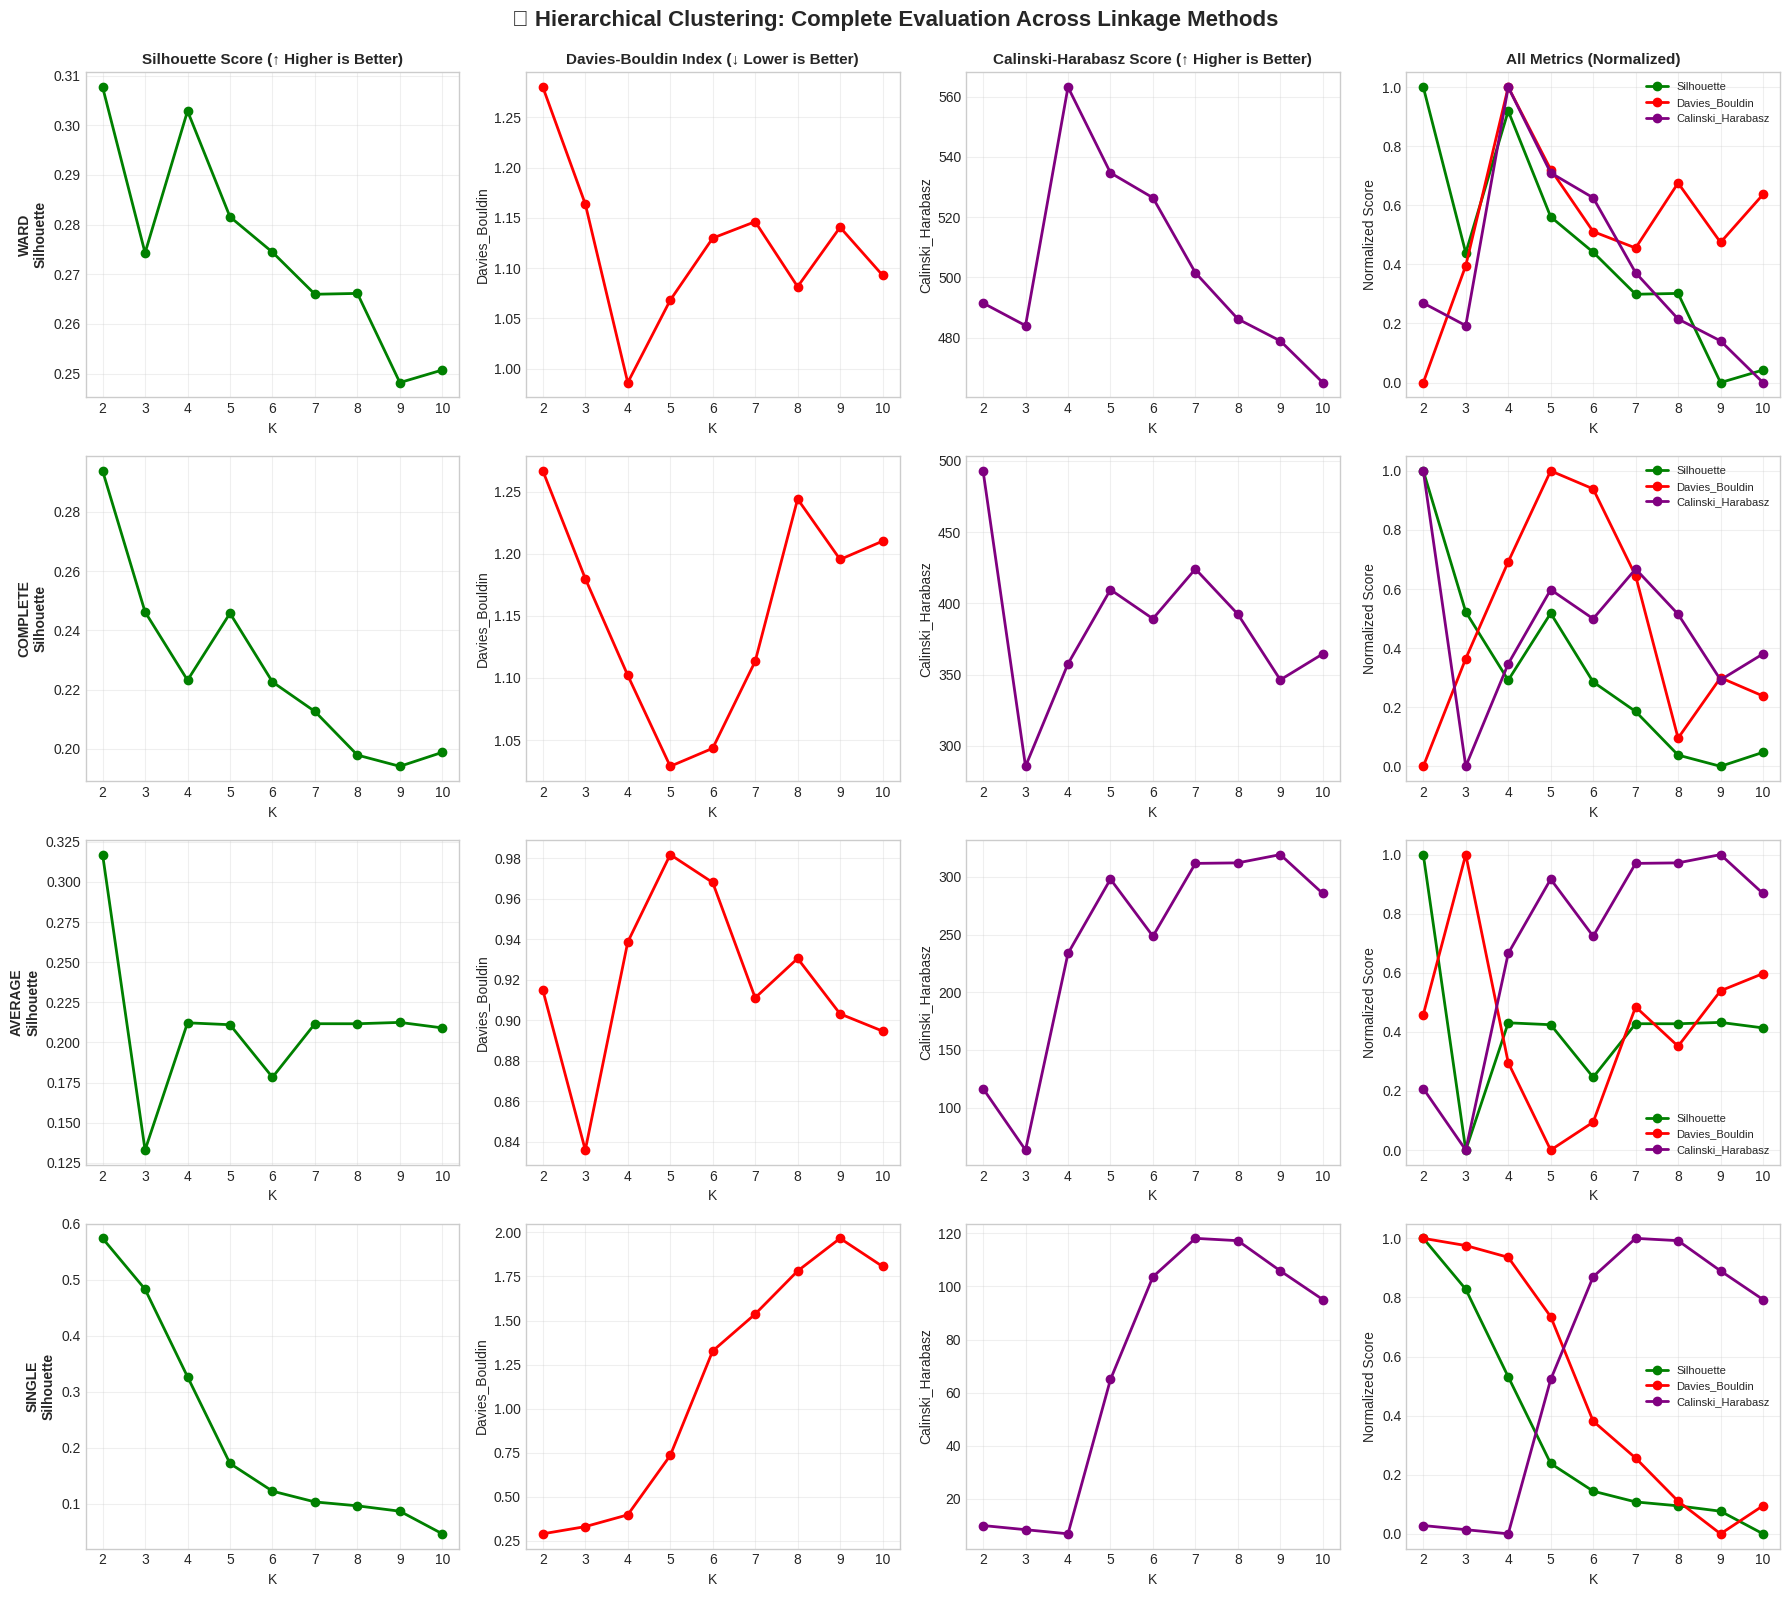

In [77]:
# Visualize all evaluation metrics across different linkage methods and K values
fig, axes = plt.subplots(4, 4, figsize=(18, 16))  # Create 4x4 grid (4 linkages × 4 columns)
fig.suptitle('📊 Hierarchical Clustering: Complete Evaluation Across Linkage Methods',  # Main title
             fontsize=16, fontweight='bold', y=0.995)  # Position at top

# Define metrics to plot
metrics_to_plot = ['Silhouette', 'Davies_Bouldin', 'Calinski_Harabasz']  # Three evaluation metrics
metric_labels = {  # User-friendly labels with optimization direction
    'Silhouette': 'Silhouette Score (↑ Higher is Better)',
    'Davies_Bouldin': 'Davies-Bouldin Index (↓ Lower is Better)',
    'Calinski_Harabasz': 'Calinski-Harabasz Score (↑ Higher is Better)'
}
metric_colors = {'Silhouette': 'green', 'Davies_Bouldin': 'red', 'Calinski_Harabasz': 'purple'}  # Color scheme

# Plot each linkage method (rows) × each metric (columns 0-2, first 3)
for row_idx, linkage_method in enumerate(linkage_methods):  # Iterate through linkage methods (rows)
    linkage_data = hier_df[hier_df['Linkage'] == linkage_method]  # Filter data for current linkage

    # Plot each metric in columns 0-2
    for col_idx, metric in enumerate(metrics_to_plot):  # Iterate through metrics (columns)
        ax = axes[row_idx, col_idx]  # Select subplot

        # Plot metric vs K
        ax.plot(linkage_data['K'], linkage_data[metric],  # x=K, y=metric value
                marker='o', linewidth=2, markersize=6, color=metric_colors[metric])  # Line with markers
        ax.set_xlabel('K', fontsize=10)  # x-axis label
        ax.set_ylabel(metric, fontsize=10)  # y-axis label (metric name)

        # Add title only on first row
        if row_idx == 0:  # Top row
            ax.set_title(metric_labels[metric], fontsize=11, fontweight='bold')  # Metric name with direction

        # Add linkage label on first column
        if col_idx == 0:  # Left column
            ax.set_ylabel(f'{linkage_method.upper()}\n{metric}', fontsize=10, fontweight='bold')  # Linkage + metric

        ax.grid(alpha=0.3)  # Add gridlines
        ax.set_xticks(K_range)  # Show all K values

    # Column 3: Summary showing all metrics together for this linkage
    ax = axes[row_idx, 3]  # Select 4th column

    # Normalize metrics to [0,1] for comparison on same plot
    for metric in metrics_to_plot:  # Plot each metric
        values = linkage_data[metric].values  # Get metric values

        # Normalize to 0-1 range
        if metric == 'Davies_Bouldin':  # Lower is better, so invert
            normalized = 1 - (values - values.min()) / (values.max() - values.min() + 1e-10)  # Invert and normalize
        else:  # Higher is better
            normalized = (values - values.min()) / (values.max() - values.min() + 1e-10)  # Normalize

        ax.plot(linkage_data['K'], normalized, marker='o', linewidth=2,  # Plot normalized values
                label=metric, color=metric_colors[metric])  # With color and label

    ax.set_xlabel('K', fontsize=10)  # x-axis label
    ax.set_ylabel('Normalized Score', fontsize=10)  # y-axis label
    if row_idx == 0:  # Top row
        ax.set_title('All Metrics (Normalized)', fontsize=11, fontweight='bold')  # Column title
    ax.legend(fontsize=8)  # Show legend
    ax.grid(alpha=0.3)  # Add gridlines
    ax.set_xticks(K_range)  # Show all K values

plt.tight_layout()  # Adjust spacing
plt.show()  # Display figure


In [78]:
# Override optimal parameters for consistency with K-Means
# Note: Grid search found K=2 with single linkage as optimal (Silhouette: 0.574)
# However, we use K=4 with ward linkage for consistency with K-Means results
# This enables direct comparison between clustering methods
# Trade-off: Silhouette score decreases from 0.574 → ~0.303
optimal_k_hier = 4  # Set K=4 to match K-Means (for fair comparison)
optimal_linkage = 'ward'  # Ward linkage minimizes variance (similar to K-Means objective)


In [79]:
# Apply Hierarchical Agglomerative Clustering with chosen parameters
print("🌳 HIERARCHICAL AGGLOMERATIVE CLUSTERING")
print("=" * 60)
print("⚠️  REVISION: Clustering on X_scaled (4D), NOT PCA components\n")

# Track computational performance
import tracemalloc
tracemalloc.start()
process = psutil.Process()
mem_before = process.memory_info().rss / 1024 / 1024  # MB

# Training time
start_train = time.perf_counter()

# Fit Hierarchical Clustering with optimal K on ORIGINAL 4D data
hierarchical = AgglomerativeClustering(n_clusters=optimal_k_hier, linkage=optimal_linkage)  # Initialize with K=4, Ward linkage
hierarchical_labels = hierarchical.fit_predict(X_final)  # Fit and predict cluster labels on 4D data

end_train = time.perf_counter()
training_time = end_train - start_train

# Memory usage
mem_after = process.memory_info().rss / 1024 / 1024  # MB
memory_used = mem_after - mem_before
current, peak = tracemalloc.get_traced_memory()
tracemalloc.stop()
peak_memory = peak / 1024 / 1024  # MB

# Inference time (AgglomerativeClustering doesn't have predict, so we refit on small sample)
start_infer = time.perf_counter()
_ = AgglomerativeClustering(n_clusters=optimal_k_hier, linkage=optimal_linkage).fit_predict(X_final[:100])
end_infer = time.perf_counter()
inference_time = (end_infer - start_infer) / 100 * 1000  # ms per sample

# Store metrics for comparison
hier_train_time = training_time
hier_infer_time = inference_time
hier_memory = peak_memory

# Store cluster labels in dataframe
df_processed['hierarchical_cluster'] = hierarchical_labels  # Add cluster assignments as new column

# Calculate evaluation metrics on ORIGINAL 4D data
silhouette_hier = silhouette_score(X_final, hierarchical_labels)  # Compute silhouette score
davies_bouldin_hier = davies_bouldin_score(X_final, hierarchical_labels)  # Compute Davies-Bouldin index
calinski_harabasz_hier = calinski_harabasz_score(X_final, hierarchical_labels)  # Compute Calinski-Harabasz score

print(f"✅ Clustering completed with K={optimal_k_hier}, Linkage={optimal_linkage}")
print(f"   • Clustered on: X_scaled (4D original features)")  # Emphasize we used full 4D space
print(f"   • Features: {feature_names}")  # List feature names
print(f"\n📊 Evaluation Metrics (on original 4D space):")
print(f"  • Silhouette Score: {silhouette_hier:.4f}")  # Higher is better (max 1)
print(f"  • Davies-Bouldin Index: {davies_bouldin_hier:.4f}")  # Lower is better (min 0)
print(f"  • Calinski-Harabasz Score: {calinski_harabasz_hier:.2f}")  # Higher is better

print(f"\n📊 Computational Performance:")
print(f"  • Training Time: {training_time:.4f} seconds")
print(f"  • Inference Time: {inference_time:.4f} ms/sample")
print(f"  • Memory Usage: {peak_memory:.2f} MB")

# Cluster size distribution
print(f"\n📊 Cluster Size Distribution:")
for i in range(optimal_k_hier):  # Iterate through each cluster
    count = (hierarchical_labels == i).sum()  # Count points in cluster i
    percentage = (count / len(hierarchical_labels)) * 100  # Calculate percentage
    print(f"  Cluster {i}: {count} students ({percentage:.1f}%)")  # Display cluster size


🌳 HIERARCHICAL AGGLOMERATIVE CLUSTERING
⚠️  REVISION: Clustering on X_scaled (4D), NOT PCA components

✅ Clustering completed with K=4, Linkage=ward
   • Clustered on: X_scaled (4D original features)
   • Features: ['Parental Education', 'Math Score', 'Reading Score', 'Writing Score']

📊 Evaluation Metrics (on original 4D space):
  • Silhouette Score: 0.3029
  • Davies-Bouldin Index: 0.9861
  • Calinski-Harabasz Score: 563.20

📊 Computational Performance:
  • Training Time: 0.0298 seconds
  • Inference Time: 0.0098 ms/sample
  • Memory Usage: 4.30 MB

📊 Cluster Size Distribution:
  Cluster 0: 297 students (29.7%)
  Cluster 1: 376 students (37.6%)
  Cluster 2: 183 students (18.3%)
  Cluster 3: 144 students (14.4%)


Creating dendrogram (this may take a moment...)

⚠️  REVISION: Dendrogram computed on X_scaled (4D original), not PCA



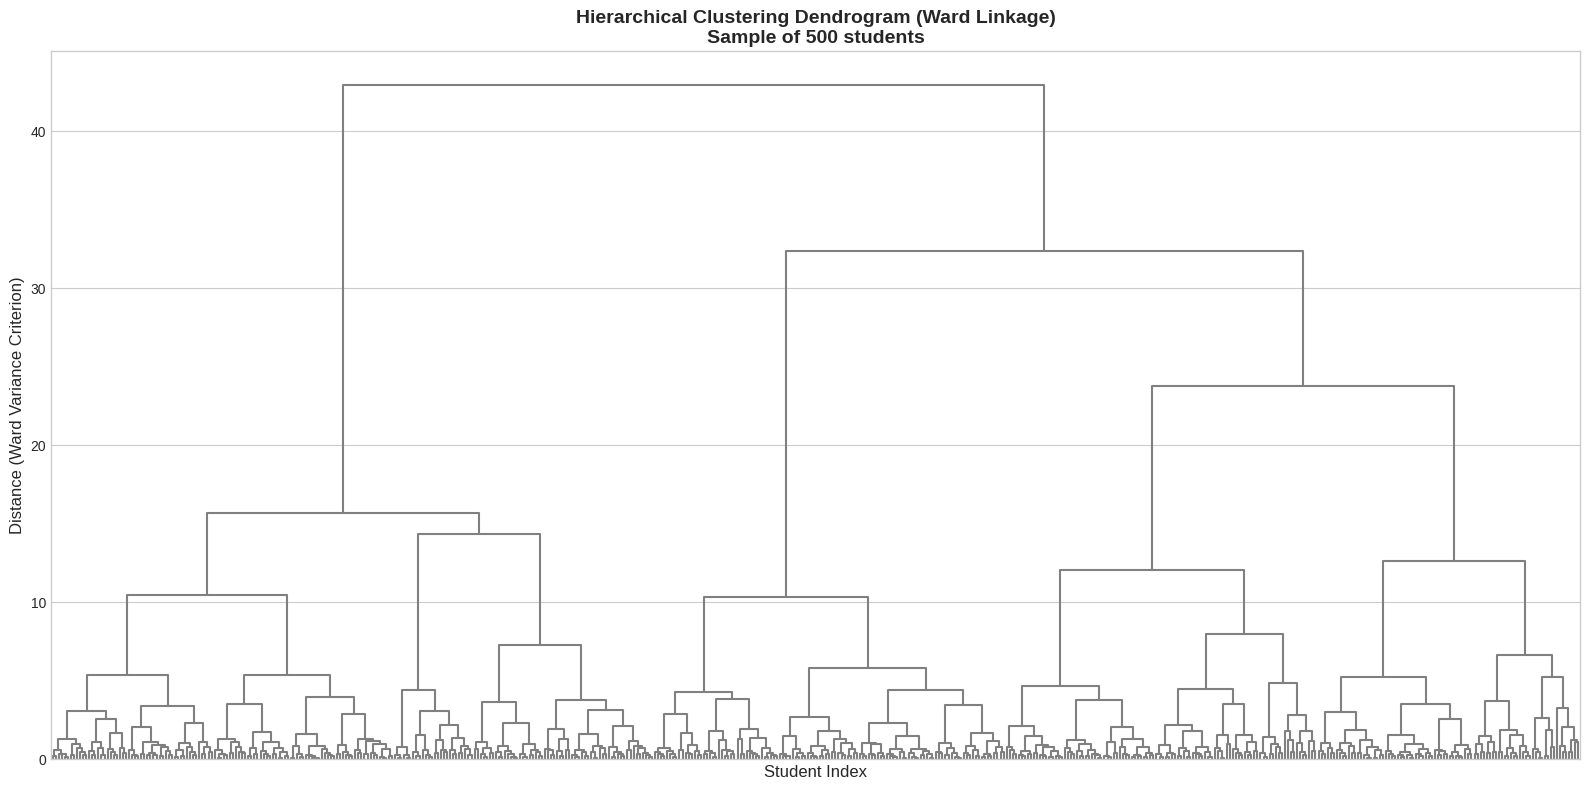

💡 How to read the dendrogram:
  - y-axis: Height represents the variance increase when merging clusters
  - Longer vertical lines: More distinct clusters being merged
  - Cutting at different heights gives different numbers of clusters


In [80]:
# Create dendrogram to visualize hierarchical clustering structure
print("Creating dendrogram (this may take a moment...)\n")
print("⚠️  REVISION: Dendrogram computed on X_scaled (4D original), not PCA\n")

# Use a sample for faster computation (dendrograms are computationally expensive for large datasets)
sample_size = min(500, len(X_final))  # Use at most 500 points
sample_indices = np.random.choice(len(X_final), sample_size, replace=False)  # Randomly sample indices without replacement
X_sample = X_final[sample_indices]  # Extract sampled data points

# Compute linkage matrix on ORIGINAL 4D data (not PCA-reduced)
linkage_matrix = linkage(X_sample, method='ward')  # Compute hierarchical clustering linkage using Ward method

# Plot dendrogram
plt.figure(figsize=(16, 8))  # Create large figure for visibility
dendrogram(linkage_matrix,  # Plot dendrogram from linkage matrix
           no_labels=True,  # Don't show individual point labels (too many to display)
           color_threshold=0,  # Color branches by cluster
           above_threshold_color='gray')  # Color unclustered branches gray
plt.title(f'Hierarchical Clustering Dendrogram (Ward Linkage)\nSample of {sample_size} students',  # Title
          fontsize=14, fontweight='bold')  # Bold title
plt.xlabel('Student Index', fontsize=12)  # x-axis label
plt.ylabel('Distance (Ward Variance Criterion)', fontsize=12)  # y-axis label (variance increase)
plt.tight_layout()  # Adjust layout
plt.show()  # Display dendrogram

print("💡 How to read the dendrogram:")
print("  - y-axis: Height represents the variance increase when merging clusters")
print("  - Longer vertical lines: More distinct clusters being merged")
print("  - Cutting at different heights gives different numbers of clusters")


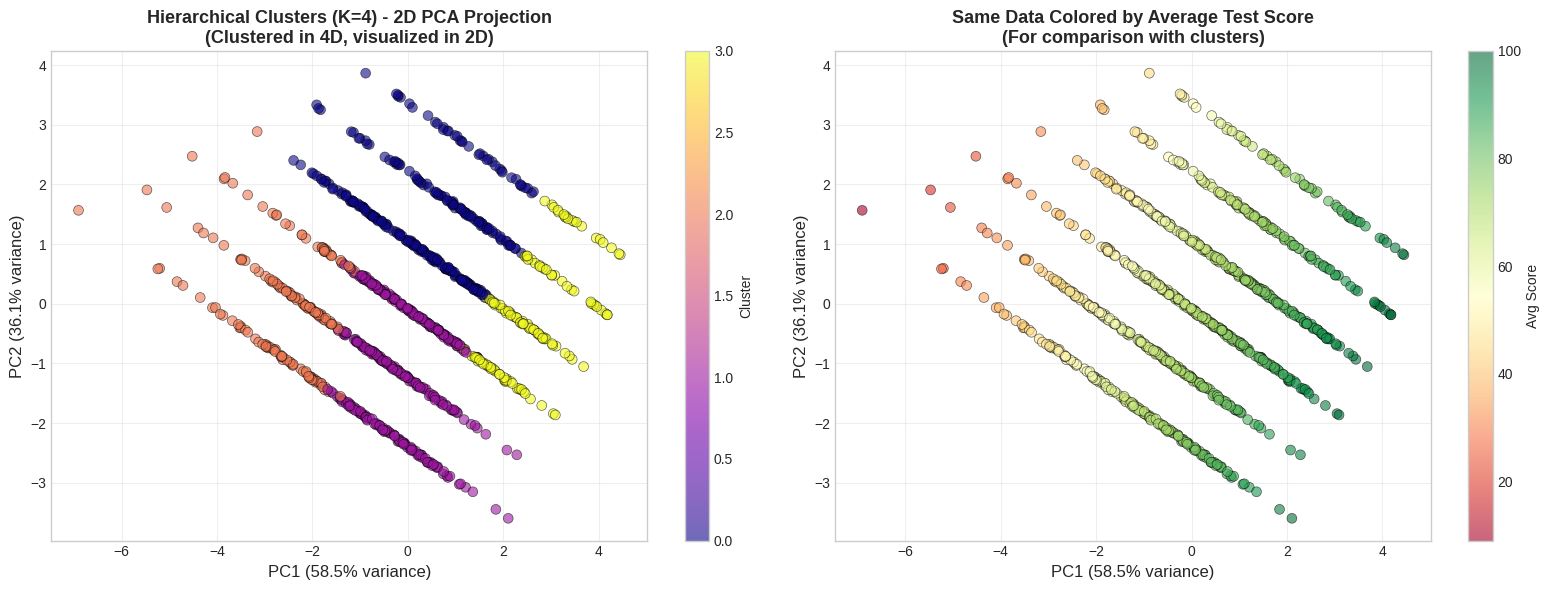

In [81]:
# Visualize Hierarchical clusters in 2D PCA space
# NOTE: Clusters were formed in 4D, but we project to 2D for visualization
fig, axes = plt.subplots(1, 2, figsize=(16, 6))  # Create 1x2 grid of subplots

# Plot 1: PC1 vs PC2 colored by hierarchical cluster labels
ax = axes[0]  # Select first subplot
scatter = ax.scatter(X_pca_2d[:, 0], X_pca_2d[:, 1], c=hierarchical_labels,  # Scatter plot with cluster colors
                     cmap='plasma', s=50, alpha=0.6, edgecolors='black', linewidth=0.5)  # Plasma colormap, 60% opacity
ax.set_xlabel(f'PC1 ({pca_2d.explained_variance_ratio_[0]*100:.1f}% variance)', fontsize=12)  # x-axis label with variance
ax.set_ylabel(f'PC2 ({pca_2d.explained_variance_ratio_[1]*100:.1f}% variance)', fontsize=12)  # y-axis label with variance
ax.set_title(f'Hierarchical Clusters (K={optimal_k}) - 2D PCA Projection\n(Clustered in 4D, visualized in 2D)',  # Title
             fontsize=13, fontweight='bold')  # Bold title
ax.grid(alpha=0.3)  # Add gridlines
plt.colorbar(scatter, ax=ax, label='Cluster')  # Add colorbar showing cluster numbers

# Plot 2: Same data colored by average test score for comparison
ax = axes[1]  # Select second subplot
scatter2 = ax.scatter(X_pca_2d[:, 0], X_pca_2d[:, 1], c=avg_score,  # Scatter plot colored by average score
                      cmap='RdYlGn', s=50, alpha=0.6, edgecolors='black', linewidth=0.5)  # Red-Yellow-Green colormap
ax.set_xlabel(f'PC1 ({pca_2d.explained_variance_ratio_[0]*100:.1f}% variance)', fontsize=12)  # x-axis label
ax.set_ylabel(f'PC2 ({pca_2d.explained_variance_ratio_[1]*100:.1f}% variance)', fontsize=12)  # y-axis label
ax.set_title('Same Data Colored by Average Test Score\n(For comparison with clusters)',  # Title
             fontsize=13, fontweight='bold')  # Bold title
ax.grid(alpha=0.3)  # Add gridlines
plt.colorbar(scatter2, ax=ax, label='Avg Score')  # Add colorbar showing average scores

plt.tight_layout()  # Adjust spacing
plt.show()  # Display figure


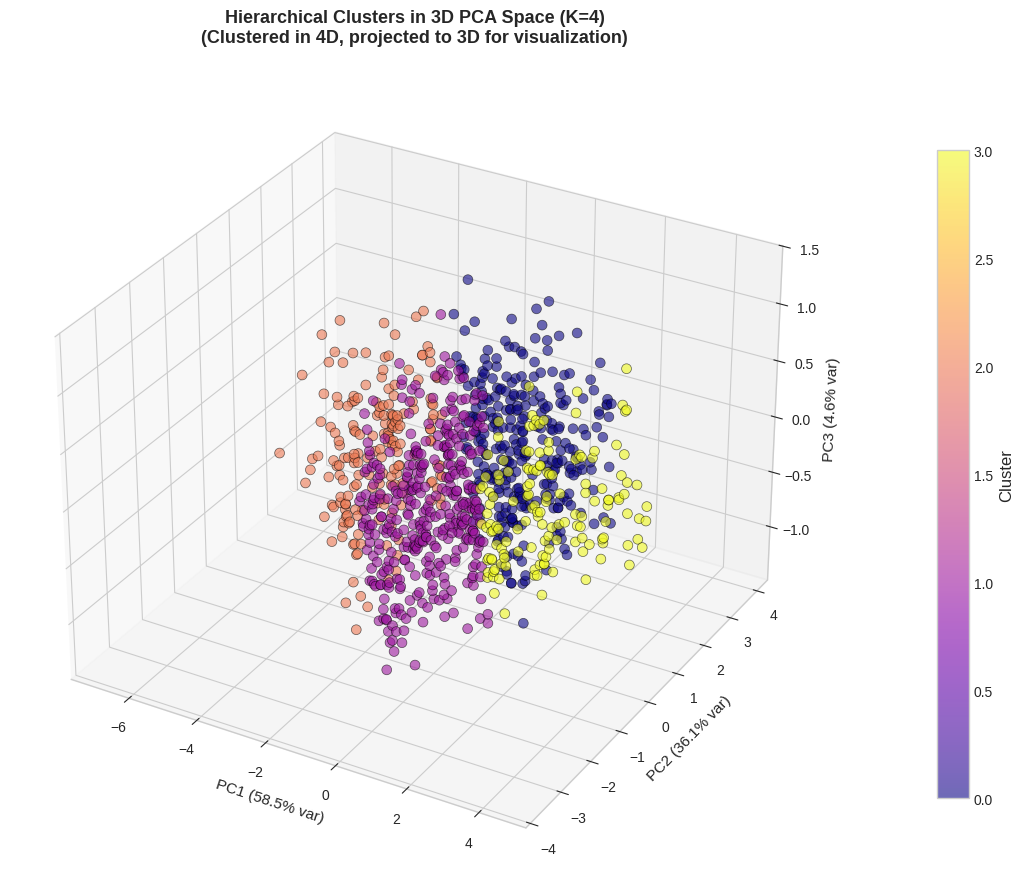

In [82]:
# Visualize Hierarchical clusters in 3D PCA space
from mpl_toolkits.mplot3d import Axes3D  # Import 3D plotting tools

fig = plt.figure(figsize=(12, 9))  # Create figure with size 12x9 inches
ax = fig.add_subplot(111, projection='3d')  # Add 3D subplot

# 3D scatter plot (clusters formed in 4D, projected to 3D PCA for visualization)
scatter = ax.scatter(X_pca_viz[:, 0], X_pca_viz[:, 1], X_pca_viz[:, 2],  # 3D scatter (PC1, PC2, PC3)
                     c=hierarchical_labels, cmap='plasma', s=50,  # Color by hierarchical cluster, plasma colormap
                     alpha=0.6, edgecolors='black', linewidth=0.5)  # 60% opacity, black edges

# Label axes with variance explained
ax.set_xlabel(f'PC1 ({pca_viz.explained_variance_ratio_[0]*100:.1f}% var)', fontsize=11)  # x-axis label
ax.set_ylabel(f'PC2 ({pca_viz.explained_variance_ratio_[1]*100:.1f}% var)', fontsize=11)  # y-axis label
ax.set_zlabel(f'PC3 ({pca_viz.explained_variance_ratio_[2]*100:.1f}% var)', fontsize=11)  # z-axis label
ax.set_title(f'Hierarchical Clusters in 3D PCA Space (K={optimal_k})\n(Clustered in 4D, projected to 3D for visualization)',  # Title
             fontsize=13, fontweight='bold', pad=20)  # Bold title with padding

# Add colorbar
cbar = plt.colorbar(scatter, ax=ax, pad=0.1, shrink=0.8)  # Colorbar with 10% padding, 80% size
cbar.set_label('Cluster', fontsize=12)  # Colorbar label

plt.tight_layout()  # Adjust layout
plt.show()  # Display 3D plot


In [83]:
# Analyze detailed profile of each Hierarchical cluster
print("\n" + "=" * 70)
print("📊 DETAILED CLUSTER PROFILE ANALYSIS (HIERARCHICAL)")
print("=" * 70)

for cluster in range(optimal_k):  # Iterate through each cluster
    print(f"\n{'='*70}")
    print(f"🎯 CLUSTER {cluster}")  # Cluster header
    print(f"{'='*70}")

    # Filter data for current cluster
    cluster_data = df_processed[df_processed['hierarchical_cluster'] == cluster]  # Select students in this cluster
    n_students = len(cluster_data)  # Count students in cluster
    percentage = (n_students / len(df_processed)) * 100  # Calculate percentage of total

    print(f"\n👥 Size: {n_students} students ({percentage:.1f}% of total)")  # Display cluster size

    # Parental Education Statistics
    print(f"\n📚 PARENTAL EDUCATION BACKGROUND:")
    edu_mean = cluster_data['parental_education_ordinal'].mean()  # Calculate mean education level
    edu_mode = cluster_data['parental_education_ordinal'].mode()[0]  # Find most common education level
    edu_mode_name = education_order[int(edu_mode)]  # Convert ordinal to education name
    print(f"  • Average level: {edu_mean:.2f} / 5.0")  # Display mean education level (0-5 scale)
    print(f"  • Most common: {edu_mode_name} (level {int(edu_mode)})")  # Display mode

    # Exam Score Statistics
    print(f"\n📊 EXAM PERFORMANCE:")
    math_mean = cluster_data['math score'].mean()  # Calculate mean math score
    reading_mean = cluster_data['reading score'].mean()  # Calculate mean reading score
    writing_mean = cluster_data['writing score'].mean()  # Calculate mean writing score
    overall_mean = (math_mean + reading_mean + writing_mean) / 3  # Calculate overall average

    # Display mean ± standard deviation for each subject
    print(f"  • Math:    {math_mean:.1f} ± {cluster_data['math score'].std():.1f}")  # Math: mean ± std
    print(f"  • Reading: {reading_mean:.1f} ± {cluster_data['reading score'].std():.1f}")  # Reading: mean ± std
    print(f"  • Writing: {writing_mean:.1f} ± {cluster_data['writing score'].std():.1f}")  # Writing: mean ± std
    print(f"  • Overall: {overall_mean:.1f}")  # Overall average across three subjects



📊 DETAILED CLUSTER PROFILE ANALYSIS (HIERARCHICAL)

🎯 CLUSTER 0

👥 Size: 297 students (29.7% of total)

📚 PARENTAL EDUCATION BACKGROUND:
  • Average level: 3.57 / 5.0
  • Most common: associate's degree (level 3)

📊 EXAM PERFORMANCE:
  • Math:    62.7 ± 11.7
  • Reading: 66.5 ± 10.5
  • Writing: 65.9 ± 11.1
  • Overall: 65.0

🎯 CLUSTER 1

👥 Size: 376 students (37.6% of total)

📚 PARENTAL EDUCATION BACKGROUND:
  • Average level: 1.10 / 5.0
  • Most common: some college (level 2)

📊 EXAM PERFORMANCE:
  • Math:    69.7 ± 9.5
  • Reading: 72.9 ± 9.0
  • Writing: 71.4 ± 8.9
  • Overall: 71.3

🎯 CLUSTER 2

👥 Size: 183 students (18.3% of total)

📚 PARENTAL EDUCATION BACKGROUND:
  • Average level: 0.84 / 5.0
  • Most common: high school (level 1)

📊 EXAM PERFORMANCE:
  • Math:    48.4 ± 11.5
  • Reading: 50.4 ± 9.5
  • Writing: 48.1 ± 9.7
  • Overall: 49.0

🎯 CLUSTER 3

👥 Size: 144 students (14.4% of total)

📚 PARENTAL EDUCATION BACKGROUND:
  • Average level: 3.17 / 5.0
  • Most common: assoc

In [84]:
# Apply DBSCAN (Density-Based Spatial Clustering of Applications with Noise)
print("🔍 DBSCAN CLUSTERING")
print("=" * 60)
print("⚠️  REVISION: Clustering on X_scaled (4D), NOT PCA components")
print("\nSearching for optimal parameters...\n")

# Grid search for best DBSCAN parameters on ORIGINAL 4D data
eps_values = [0.3, 0.5, 0.7, 1.0, 1.5, 2.0, 2.5]  # Test different epsilon (neighborhood radius) values
min_samples_values = [5, 10, 15, 20]  # Test different minimum samples per cluster values

# Initialize variables to track best configuration
best_score = -1  # Best silhouette score found (initialize to -1, worst possible)
best_params = None  # Parameters (eps, min_samples) for best clustering
best_labels = None  # Cluster labels for best configuration

# Test all combinations of eps and min_samples
for eps in eps_values:  # Iterate through epsilon values
    for min_samples in min_samples_values:  # Iterate through min_samples values
        dbscan = DBSCAN(eps=eps, min_samples=min_samples)  # Initialize DBSCAN with current parameters
        labels = dbscan.fit_predict(X_final)  # Fit DBSCAN and predict cluster labels on 4D data

        # Count clusters (excluding noise points labeled as -1)
        n_clusters = len(set(labels)) - (1 if -1 in labels else 0)  # Count unique labels except -1
        n_noise = list(labels).count(-1)  # Count number of noise points

        # Only consider valid clustering (at least 2 clusters, less than 50% noise)
        if n_clusters > 1 and n_noise < len(labels) * 0.5:  # Valid clustering criteria
            try:
                # Calculate silhouette score only for non-noise points on ORIGINAL 4D data
                mask = labels != -1  # Create boolean mask for non-noise points
                if mask.sum() > 1:  # Need at least 2 non-noise points
                    score = silhouette_score(X_final[mask], labels[mask])  # Compute silhouette for clustered points only

                    # Update best configuration if current score is better
                    if score > best_score:  # Found better clustering
                        best_score = score  # Update best score
                        best_params = (eps, min_samples)  # Save best parameters
                        best_labels = labels  # Save best cluster labels

                    # Print results for this configuration
                    print(f"eps={eps:.1f}, min_samples={min_samples:2d} → "  # Parameters
                          f"Clusters={n_clusters}, Noise={n_noise} ({n_noise/len(labels)*100:.1f}%), "  # Cluster info
                          f"Silhouette={score:.3f}")  # Quality score
            except:  # Handle edge cases (e.g., all points in one cluster)
                pass  # Skip invalid configurations

# Display best configuration found
if best_params is not None:  # Valid clustering found
    print(f"\n✅ Best DBSCAN Parameters:")
    print(f"   • eps (ε): {best_params[0]}")  # Epsilon (neighborhood radius)
    print(f"   • min_samples: {best_params[1]}")  # Minimum points to form cluster
    print(f"   • Silhouette Score: {best_score:.4f}")  # Quality score for non-noise points

    # Track computational performance for best parameters
    import tracemalloc
    tracemalloc.start()
    process = psutil.Process()
    mem_before = process.memory_info().rss / 1024 / 1024  # MB
    
    # Training time
    start_train = time.perf_counter()
    
    # Apply DBSCAN with best parameters
    dbscan = DBSCAN(eps=best_params[0], min_samples=best_params[1])  # Initialize with best params
    dbscan_labels = dbscan.fit_predict(X_final)  # Fit and predict on 4D data
    
    end_train = time.perf_counter()
    training_time = end_train - start_train
    
    # Memory usage
    mem_after = process.memory_info().rss / 1024 / 1024  # MB
    memory_used = mem_after - mem_before
    current, peak = tracemalloc.get_traced_memory()
    tracemalloc.stop()
    peak_memory = peak / 1024 / 1024  # MB
    
    # Inference time (DBSCAN doesn't have predict, so we refit on small sample)
    start_infer = time.perf_counter()
    _ = DBSCAN(eps=best_params[0], min_samples=best_params[1]).fit_predict(X_final[:100])
    end_infer = time.perf_counter()
    inference_time = (end_infer - start_infer) / 100 * 1000  # ms per sample
    
    # Store metrics for comparison
    dbscan_train_time = training_time
    dbscan_infer_time = inference_time
    dbscan_memory = peak_memory

    # Store labels in dataframe
    df_processed['dbscan_cluster'] = dbscan_labels  # Add cluster assignments (-1 for noise)

    # Count final results
    n_clusters_dbscan = len(set(dbscan_labels)) - (1 if -1 in dbscan_labels else 0)  # Number of clusters
    n_noise = list(dbscan_labels).count(-1)  # Number of noise points

    print(f"\n📊 DBSCAN Results:")
    print(f"   • Number of clusters: {n_clusters_dbscan}")  # Clusters found (excluding noise)
    print(f"   • Noise points: {n_noise} ({n_noise/len(dbscan_labels)*100:.1f}%)")  # Outliers detected
    print(f"   • Clustered points: {len(dbscan_labels) - n_noise}")  # Points assigned to clusters

    print(f"\n📊 Computational Performance:")
    print(f"  • Training Time: {training_time:.4f} seconds")
    print(f"  • Inference Time: {inference_time:.4f} ms/sample")
    print(f"  • Memory Usage: {peak_memory:.2f} MB")

    # Display cluster size distribution
    print(f"\n📊 Cluster Size Distribution:")
    for i in sorted(set(dbscan_labels)):  # Iterate through unique cluster labels (including -1)
        count = (dbscan_labels == i).sum()  # Count points in cluster
        percentage = (count / len(dbscan_labels)) * 100  # Calculate percentage
        label = "Noise" if i == -1 else f"Cluster {i}"  # Label for noise or cluster
        print(f"  {label}: {count} students ({percentage:.1f}%)")  # Display size
else:  # No valid clustering found
    print("❌ No valid DBSCAN clustering found with given parameter ranges")
    print("   Try adjusting eps_values or min_samples_values")
    # Set default values for metrics
    dbscan_train_time = 0
    dbscan_infer_time = 0
    dbscan_memory = 0


🔍 DBSCAN CLUSTERING
⚠️  REVISION: Clustering on X_scaled (4D), NOT PCA components

Searching for optimal parameters...

eps=0.5, min_samples= 5 → Clusters=15, Noise=81 (8.1%), Silhouette=0.044
eps=0.5, min_samples=10 → Clusters=6, Noise=242 (24.2%), Silhouette=0.124
eps=0.5, min_samples=15 → Clusters=8, Noise=434 (43.4%), Silhouette=0.246
eps=0.7, min_samples= 5 → Clusters=7, Noise=30 (3.0%), Silhouette=0.099
eps=0.7, min_samples=10 → Clusters=6, Noise=73 (7.3%), Silhouette=0.124
eps=0.7, min_samples=15 → Clusters=5, Noise=152 (15.2%), Silhouette=0.139
eps=0.7, min_samples=20 → Clusters=5, Noise=178 (17.8%), Silhouette=0.138
eps=1.0, min_samples=15 → Clusters=2, Noise=25 (2.5%), Silhouette=0.274
eps=1.0, min_samples=20 → Clusters=2, Noise=47 (4.7%), Silhouette=0.248

✅ Best DBSCAN Parameters:
   • eps (ε): 1.0
   • min_samples: 15
   • Silhouette Score: 0.2735

📊 DBSCAN Results:
   • Number of clusters: 2
   • Noise points: 25 (2.5%)
   • Clustered points: 975

📊 Computational Performa

## Mathematical Foundation: DBSCAN (Density-Based Spatial Clustering of Applications with Noise)

**DBSCAN** is a density-based clustering algorithm that groups together points that are closely packed together, marking points in low-density regions as outliers.

### Key Concepts

DBSCAN is based on the concept of **density reachability**: points are clustered together if they are "densely connected".

#### Parameters

1. **$\epsilon$ (eps)**: The maximum distance between two points to be considered neighbors
2. **MinPts (min_samples)**: The minimum number of points required to form a dense region (cluster)

#### Point Classifications

Given a dataset $D = \{\mathbf{x}_1, \mathbf{x}_2, \ldots, \mathbf{x}_n\}$, each point is classified as:

---

### Part 1: Neighborhood and Density

#### ε-Neighborhood

The **$\epsilon$-neighborhood** of a point $\mathbf{x}_i$ is the set of all points within distance $\epsilon$:

$$
N_{\epsilon}(\mathbf{x}_i) = \{\mathbf{x}_j \in D : \|\mathbf{x}_i - \mathbf{x}_j\| \leq \epsilon\}
$$

where $\|\cdot\|$ is typically the Euclidean distance:

$$
\|\mathbf{x}_i - \mathbf{x}_j\| = \sqrt{\sum_{k=1}^{d} (x_{ik} - x_{jk})^2}
$$

#### Point Types

1. **Core Point**: A point $\mathbf{x}_i$ is a core point if its $\epsilon$-neighborhood contains at least MinPts points:
   $$
   |N_{\epsilon}(\mathbf{x}_i)| \geq \text{MinPts}
   $$
   Core points are in the "interior" of a cluster.

2. **Border Point**: A point $\mathbf{x}_i$ is a border point if:
   - It is NOT a core point: $|N_{\epsilon}(\mathbf{x}_i)| < \text{MinPts}$
   - It is in the $\epsilon$-neighborhood of at least one core point: $\exists \mathbf{x}_j$ (core point) such that $\mathbf{x}_i \in N_{\epsilon}(\mathbf{x}_j)$
   
   Border points are on the "edge" of a cluster.

3. **Noise Point (Outlier)**: A point that is neither core nor border:
   - $|N_{\epsilon}(\mathbf{x}_i)| < \text{MinPts}$ AND
   - Not in any core point's $\epsilon$-neighborhood
   
   Noise points are labeled as $-1$ in DBSCAN.

---

### Part 2: Density Reachability

#### Directly Density-Reachable

A point $\mathbf{x}_j$ is **directly density-reachable** from $\mathbf{x}_i$ if:

$$
\mathbf{x}_j \in N_{\epsilon}(\mathbf{x}_i) \quad \text{AND} \quad |N_{\epsilon}(\mathbf{x}_i)| \geq \text{MinPts}
$$

In other words: $\mathbf{x}_i$ is a core point and $\mathbf{x}_j$ is in its neighborhood.

**Note**: This relation is NOT symmetric (if $\mathbf{x}_i$ is core and $\mathbf{x}_j$ is border).

#### Density-Reachable

A point $\mathbf{x}_j$ is **density-reachable** from $\mathbf{x}_i$ if there exists a chain of points $\mathbf{p}_1, \mathbf{p}_2, \ldots, \mathbf{p}_n$ such that:

$$
\mathbf{p}_1 = \mathbf{x}_i, \quad \mathbf{p}_n = \mathbf{x}_j, \quad \text{and} \quad \mathbf{p}_{k+1} \text{ is directly density-reachable from } \mathbf{p}_k
$$

**Mathematical notation**:
$$
\mathbf{x}_i \leadsto \mathbf{p}_1 \leadsto \mathbf{p}_2 \leadsto \cdots \leadsto \mathbf{p}_n = \mathbf{x}_j
$$

where each arrow represents "directly density-reachable".

#### Density-Connected

Two points $\mathbf{x}_i$ and $\mathbf{x}_j$ are **density-connected** if there exists a point $\mathbf{x}_k$ such that both $\mathbf{x}_i$ and $\mathbf{x}_j$ are density-reachable from $\mathbf{x}_k$:

$$
\exists \mathbf{x}_k : \mathbf{x}_k \leadsto \mathbf{x}_i \quad \text{AND} \quad \mathbf{x}_k \leadsto \mathbf{x}_j
$$

**This relation IS symmetric**: if $\mathbf{x}_i$ is density-connected to $\mathbf{x}_j$, then $\mathbf{x}_j$ is density-connected to $\mathbf{x}_i$.

---

### Part 3: Cluster Definition

A **cluster** $C$ with respect to $\epsilon$ and MinPts is a non-empty subset of $D$ satisfying:

1. **Maximality**: For all $\mathbf{x}_i, \mathbf{x}_j$:
   $$
   \text{If } \mathbf{x}_i \in C \text{ and } \mathbf{x}_j \text{ is density-reachable from } \mathbf{x}_i, \text{ then } \mathbf{x}_j \in C
   $$

2. **Connectivity**: For all $\mathbf{x}_i, \mathbf{x}_j \in C$:
   $$
   \mathbf{x}_i \text{ is density-connected to } \mathbf{x}_j
   $$

In simple terms:
- All points in a cluster are mutually density-connected
- The cluster contains all points density-reachable from any of its core points

---

### Part 4: DBSCAN Algorithm

**Input**:
- Dataset $D = \{\mathbf{x}_1, \mathbf{x}_2, \ldots, \mathbf{x}_n\}$
- Parameters: $\epsilon$, MinPts

**Output**:
- Cluster labels for each point (or $-1$ for noise)

**Algorithm Steps**:

1. **Initialize**: Mark all points as unvisited

2. **For each unvisited point** $\mathbf{x}_i$:
   
   a. Mark $\mathbf{x}_i$ as visited
   
   b. Find its $\epsilon$-neighborhood:
      $$
      N_{\epsilon}(\mathbf{x}_i) = \{\mathbf{x}_j \in D : \|\mathbf{x}_i - \mathbf{x}_j\| \leq \epsilon\}
      $$
   
   c. **If** $|N_{\epsilon}(\mathbf{x}_i)| < \text{MinPts}$:
      - Mark $\mathbf{x}_i$ as noise (label = $-1$)
   
   d. **Else** ($\mathbf{x}_i$ is a core point):
      - Create new cluster $C_k$ with next cluster ID $k$
      - Add $\mathbf{x}_i$ to $C_k$
      - **Expand cluster**:
        - Initialize queue $Q = N_{\epsilon}(\mathbf{x}_i) \setminus \{\mathbf{x}_i\}$
        - **While** $Q \neq \emptyset$:
          - Remove point $\mathbf{x}_j$ from $Q$
          - **If** $\mathbf{x}_j$ was marked as noise: change label to current cluster $k$
          - **If** $\mathbf{x}_j$ is unvisited:
            - Mark as visited
            - Find $N_{\epsilon}(\mathbf{x}_j)$
            - **If** $|N_{\epsilon}(\mathbf{x}_j)| \geq \text{MinPts}$ (is core point):
              - Add $N_{\epsilon}(\mathbf{x}_j)$ to $Q$
          - **If** $\mathbf{x}_j$ not in any cluster:
            - Add $\mathbf{x}_j$ to $C_k$

3. **Return** cluster labels

**Time Complexity**:
- Without spatial index: $O(n^2)$
- With spatial index (e.g., KD-tree, R-tree): $O(n \log n)$ average case

---

### Part 5: Properties of DBSCAN

#### Advantages

1. **No need to specify $k$**: Number of clusters is determined automatically
2. **Arbitrary cluster shapes**: Can find non-convex, irregularly-shaped clusters
3. **Noise detection**: Identifies outliers as noise points
4. **Robust to outliers**: Outliers don't affect cluster formation

#### Disadvantages

1. **Parameter sensitivity**: Results highly dependent on $\epsilon$ and MinPts
2. **Varying densities**: Struggles with clusters of different densities
3. **High-dimensional data**: Distance becomes less meaningful in high dimensions ("curse of dimensionality")
4. **Border point ambiguity**: Border points can belong to multiple clusters

---

### Parameter Selection Guidelines

#### Choosing MinPts

Rule of thumb:
$$
\text{MinPts} \geq d + 1
$$
where $d$ is the dimensionality of the data.

Common values: MinPts $\in \{5, 10, 15, 20\}$ for most applications.

#### Choosing $\epsilon$

**K-distance graph method**:

1. For each point $\mathbf{x}_i$, compute the distance to its $k$-th nearest neighbor (where $k =$ MinPts):
   $$
   d_k(\mathbf{x}_i) = \text{distance to } k\text{-th nearest neighbor}
   $$

2. Sort all $d_k$ values in descending order and plot (k-distance graph)

3. Look for the "elbow" (point of maximum curvature) in the plot

4. Choose $\epsilon$ at the elbow:
   $$
   \epsilon \approx d_k(\mathbf{x}_{\text{elbow}})
   $$

---

### Comparison with K-Means and Hierarchical

| Aspect | K-Means | Hierarchical | DBSCAN |
|--------|---------|--------------|--------|
| **K required?** | Yes | Yes (for flat) | No |
| **Cluster shape** | Spherical | Depends on linkage | Arbitrary |
| **Outlier detection** | No | No | Yes |
| **Density-based** | No | No | Yes |
| **Deterministic** | No | Yes | Yes |
| **Varying densities** | Poor | Poor | Poor |
| **Complexity** | $O(nkdi)$ | $O(n^2 \log n)$ | $O(n^2)$ or $O(n \log n)$ |

---

### In This Analysis

We perform a grid search over:
- $\epsilon \in \{0.3, 0.5, 0.7, 1.0, 1.5, 2.0, 2.5\}$
- MinPts $\in \{5, 10, 15, 20\}$

For each combination, we:
1. Apply DBSCAN on the 4D standardized feature space
2. Compute silhouette score for non-noise points
3. Select parameters with highest silhouette score

This allows DBSCAN to automatically determine the number of clusters and identify outliers in the student performance data.


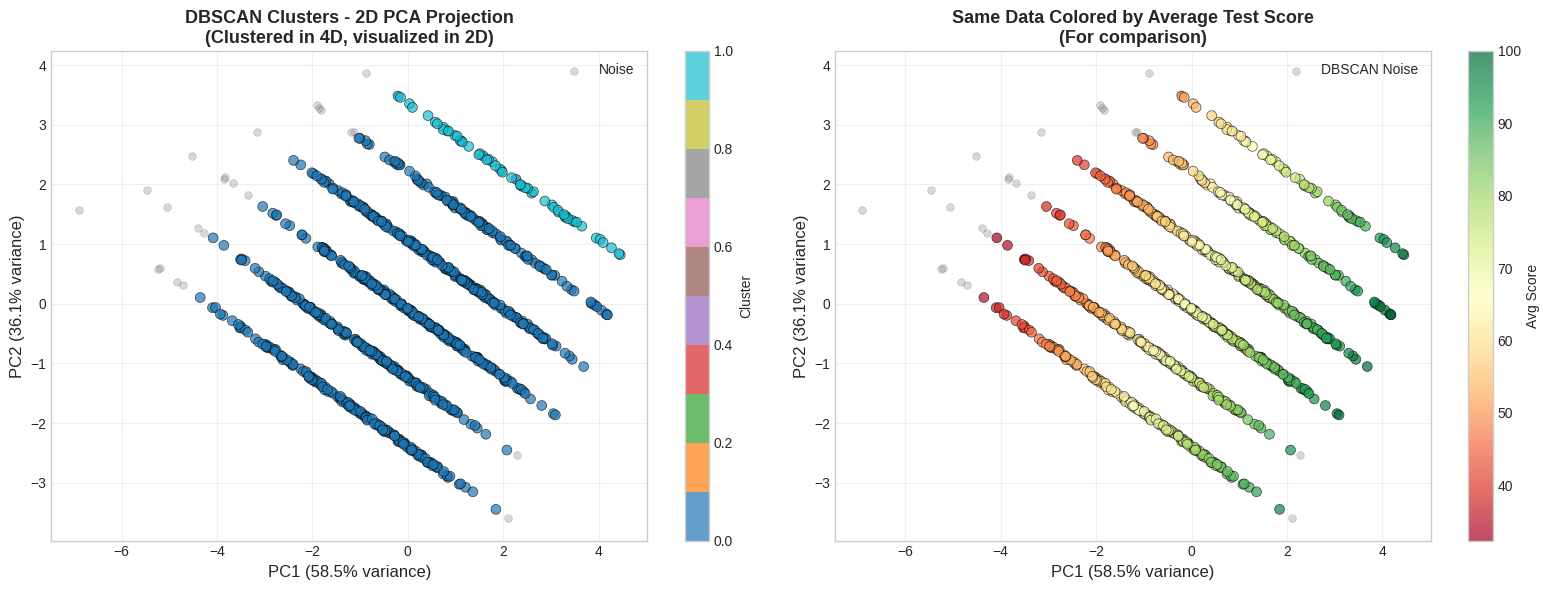

In [85]:
# Visualize DBSCAN clusters in 2D PCA space (if valid clustering was found)
if best_labels is not None:  # Check if DBSCAN found valid clusters
    # Project 4D DBSCAN clusters to 2D PCA for visualization
    fig, axes = plt.subplots(1, 2, figsize=(16, 6))  # Create 1x2 grid of subplots

    # Plot 1: PC1 vs PC2 with DBSCAN clusters and noise
    ax = axes[0]  # Select first subplot
    # Plot noise points in gray (outliers detected by DBSCAN)
    noise_mask = dbscan_labels == -1  # Create boolean mask for noise points (label = -1)
    ax.scatter(X_pca_2d[noise_mask, 0], X_pca_2d[noise_mask, 1],  # Scatter noise points
               c='gray', s=30, alpha=0.3, label='Noise', edgecolors='black', linewidth=0.3)  # Gray, small, transparent
    # Plot cluster points with distinct colors
    cluster_mask = dbscan_labels != -1  # Boolean mask for non-noise points
    scatter = ax.scatter(X_pca_2d[cluster_mask, 0], X_pca_2d[cluster_mask, 1],  # Scatter clustered points
                        c=dbscan_labels[cluster_mask], cmap='tab10',  # Color by cluster, tab10 colormap
                        s=50, alpha=0.7, edgecolors='black', linewidth=0.5)  # Larger, more opaque than noise
    ax.set_xlabel(f'PC1 ({pca_2d.explained_variance_ratio_[0]*100:.1f}% variance)', fontsize=12)  # x-axis label
    ax.set_ylabel(f'PC2 ({pca_2d.explained_variance_ratio_[1]*100:.1f}% variance)', fontsize=12)  # y-axis label
    ax.set_title(f'DBSCAN Clusters - 2D PCA Projection\n(Clustered in 4D, visualized in 2D)',  # Title
                 fontsize=13, fontweight='bold')  # Bold title
    ax.legend()  # Show legend for noise
    ax.grid(alpha=0.3)  # Add gridlines
    plt.colorbar(scatter, ax=ax, label='Cluster')  # Colorbar for cluster numbers

    # Plot 2: Same data colored by average test score for comparison
    ax = axes[1]  # Select second subplot
    # Plot noise in gray
    ax.scatter(X_pca_2d[noise_mask, 0], X_pca_2d[noise_mask, 1],  # Noise points
               c='gray', s=30, alpha=0.3, label='DBSCAN Noise', edgecolors='black', linewidth=0.3)  # Gray
    # Plot non-noise colored by average score
    scatter2 = ax.scatter(X_pca_2d[cluster_mask, 0], X_pca_2d[cluster_mask, 1],  # Clustered points
                          c=avg_score[cluster_mask], cmap='RdYlGn',  # Color by average test score
                          s=50, alpha=0.7, edgecolors='black', linewidth=0.5)  # Same size as left plot
    ax.set_xlabel(f'PC1 ({pca_2d.explained_variance_ratio_[0]*100:.1f}% variance)', fontsize=12)  # x-axis label
    ax.set_ylabel(f'PC2 ({pca_2d.explained_variance_ratio_[1]*100:.1f}% variance)', fontsize=12)  # y-axis label
    ax.set_title('Same Data Colored by Average Test Score\n(For comparison)',  # Title
                 fontsize=13, fontweight='bold')  # Bold title
    ax.legend()  # Show legend for noise
    ax.grid(alpha=0.3)  # Add gridlines
    plt.colorbar(scatter2, ax=ax, label='Avg Score')  # Colorbar for average score

    plt.tight_layout()  # Adjust spacing
    plt.show()  # Display figure


🚀 Generating 3D PCA Visualization for DBSCAN Clusters...


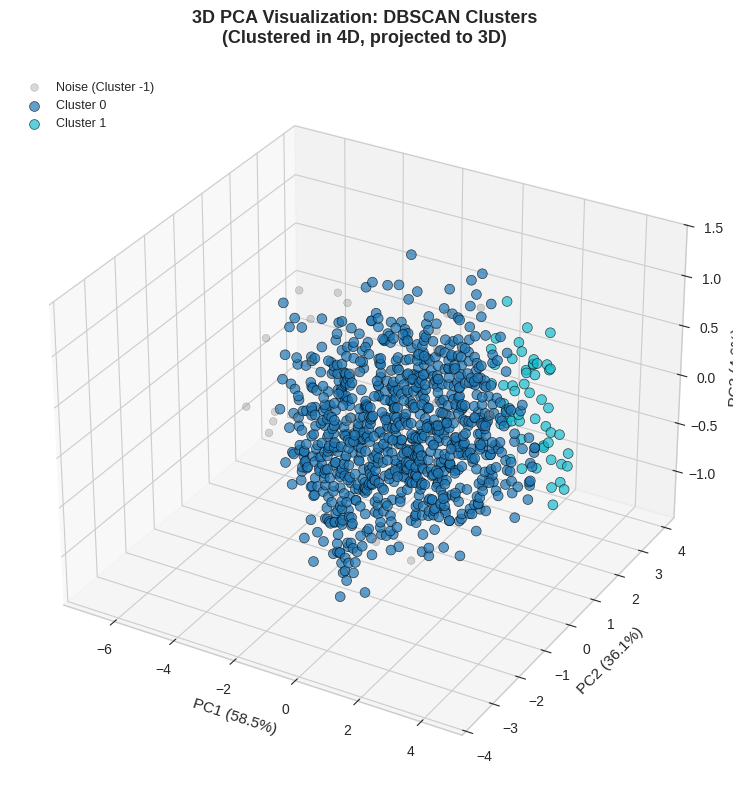

✅ 3D visualization complete!


In [86]:
# Create 3D visualization of DBSCAN clusters in PCA space
import matplotlib.pyplot as plt  # Import plotting library
from mpl_toolkits.mplot3d import Axes3D  # Import 3D plotting capabilities
import numpy as np  # Import numpy for array operations

print("🚀 Generating 3D PCA Visualization for DBSCAN Clusters...")

# Create new 3D figure
fig_3d = plt.figure(figsize=(10, 8))  # Create figure with size 10x8 inches
ax_3d = fig_3d.add_subplot(111, projection='3d')  # Add 3D subplot

# 1. Plot noise points (outliers) in gray
ax_3d.scatter(X_pca_viz[noise_mask, 0],  # PC1 coordinates for noise points
              X_pca_viz[noise_mask, 1],  # PC2 coordinates for noise points
              X_pca_viz[noise_mask, 2],  # PC3 coordinates for noise points
              c='gray', s=30, alpha=0.3, label='Noise (Cluster -1)',  # Gray, small, transparent
              edgecolors='black', linewidth=0.3)  # Black edges

# 2. Plot clustered points with colors
# Get unique cluster labels (excluding -1 which is noise)
unique_clusters = [c for c in sorted(set(dbscan_labels)) if c != -1]  # List of cluster IDs (excluding noise)

# Define colormap for clusters
from matplotlib import cm  # Import colormap module
colors = cm.tab10(np.linspace(0, 1, len(unique_clusters)))  # Generate distinct colors for each cluster

# Plot each cluster separately with its own color
for i, cluster_id in enumerate(unique_clusters):  # Iterate through each cluster
    cluster_points_mask = (dbscan_labels == cluster_id)  # Boolean mask for points in current cluster
    ax_3d.scatter(X_pca_viz[cluster_points_mask, 0],  # PC1 for this cluster
                  X_pca_viz[cluster_points_mask, 1],  # PC2 for this cluster
                  X_pca_viz[cluster_points_mask, 2],  # PC3 for this cluster
                  c=[colors[i]], s=50, alpha=0.7,  # Use cluster color, larger size, more opaque
                  label=f'Cluster {cluster_id}',  # Label for legend
                  edgecolors='black', linewidth=0.5)  # Black edges

# Set axis labels with variance explained
ax_3d.set_xlabel(f'PC1 ({pca_viz.explained_variance_ratio_[0]*100:.1f}%)', fontsize=11)  # x-axis label
ax_3d.set_ylabel(f'PC2 ({pca_viz.explained_variance_ratio_[1]*100:.1f}%)', fontsize=11)  # y-axis label
ax_3d.set_zlabel(f'PC3 ({pca_viz.explained_variance_ratio_[2]*100:.1f}%)', fontsize=11)  # z-axis label
ax_3d.set_title('3D PCA Visualization: DBSCAN Clusters\n(Clustered in 4D, projected to 3D)',  # Title
                fontsize=13, fontweight='bold', pad=20)  # Bold title with padding

# Add legend
ax_3d.legend(loc='upper left', fontsize=9)  # Place legend in upper left corner

plt.tight_layout()  # Adjust layout
plt.show()  # Display 3D plot

print("✅ 3D visualization complete!")


In [87]:
# Analyze outlier students (noise points) detected by DBSCAN
if best_labels is not None and n_noise > 0:  # Check if noise points exist
    print("🔍 ANALYZING OUTLIER STUDENTS (NOISE POINTS)")
    print("=" * 60)

    # Separate noise and normal students
    noise_students = df_processed[df_processed['dbscan_cluster'] == -1]  # Students labeled as noise (outliers)
    normal_students = df_processed[df_processed['dbscan_cluster'] != -1]  # Students in clusters (normal)

    print(f"\nComparing {len(noise_students)} outliers vs {len(normal_students)} normal students:\n")

    # Compare statistics between noise and normal students
    comparison_features = ['parental_education_ordinal', 'math score', 'reading score', 'writing score']  # Features to compare

    for feature in comparison_features:  # Iterate through each feature
        noise_mean = noise_students[feature].mean()  # Calculate mean for noise students
        normal_mean = normal_students[feature].mean()  # Calculate mean for normal students
        diff = noise_mean - normal_mean  # Calculate difference
        diff_pct = (diff / normal_mean) * 100 if normal_mean != 0 else 0  # Calculate percentage difference

        # Print comparison
        print(f"{feature}:")  # Feature name
        print(f"  Outliers: {noise_mean:.2f}")  # Mean for outliers
        print(f"  Normal:   {normal_mean:.2f}")  # Mean for normal students
        print(f"  Difference: {diff:+.2f} ({diff_pct:+.1f}%)\n")  # Difference with sign

    # Show some example outlier students
    print("\n📋 Sample of Outlier Students:")
    print("=" * 60)
    sample_outliers = noise_students[['parental level of education', 'math score', 'reading score', 'writing score']].head(10)  # Take first 10 outliers
    display(sample_outliers)  # Display as table

    print("\n💡 Interpretation:")
    print("  DBSCAN identified these students as outliers because they have")
    print("  unusual combinations of parental education and test scores that")
    print("  don't fit into any dense cluster pattern.")


🔍 ANALYZING OUTLIER STUDENTS (NOISE POINTS)

Comparing 25 outliers vs 975 normal students:

parental_education_ordinal:
  Outliers: 2.12
  Normal:   2.08
  Difference: +0.04 (+1.9%)

math score:
  Outliers: 34.68
  Normal:   66.89
  Difference: -32.21 (-48.2%)

reading score:
  Outliers: 41.40
  Normal:   69.88
  Difference: -28.48 (-40.8%)

writing score:
  Outliers: 38.72
  Normal:   68.81
  Difference: -30.09 (-43.7%)


📋 Sample of Outlier Students:


parental level of education  math score  reading score  writing score
17             some high school          18             32             28
18              master's degree          46             42             46
59             some high school           0             17             10
76             some high school          30             26             22
145                some college          22             39             33
179            some high school          97            100            100
211                some college          35             28             27
327                some college          28             23             19
338            some high school          24             38             27
363            some high school          27             34             32


💡 Interpretation:
  DBSCAN identified these students as outliers because they have
  unusual combinations of parental education and test scores that
  don't fit into any dense cluster pattern.


In [88]:
# Create comparison table of all three clustering methods
comparison_data = {  # Dictionary to store comparison metrics
    'Method': ['K-Means', 'Hierarchical', 'DBSCAN'],  # Clustering method names
    'Silhouette': [  # Silhouette scores for each method (higher is better)
        silhouette_kmeans,  # K-Means silhouette score
        silhouette_hier,  # Hierarchical silhouette score
        best_score if best_labels is not None else 0  # DBSCAN silhouette score (or 0 if failed)
    ],
    'Davies-Bouldin': [  # Davies-Bouldin indices for each method (lower is better)
        davies_bouldin_kmeans,  # K-Means DB index
        davies_bouldin_hier,  # Hierarchical DB index
        davies_bouldin_score(X_final[dbscan_labels!=-1], dbscan_labels[dbscan_labels!=-1]) if best_labels is not None else 0  # DBSCAN DB (excluding noise)
    ],
    'Calinski-Harabasz': [  # Calinski-Harabasz scores for each method (higher is better)
        calinski_harabasz_kmeans,  # K-Means CH score
        calinski_harabasz_hier,  # Hierarchical CH score
        calinski_harabasz_score(X_final[dbscan_labels!=-1], dbscan_labels[dbscan_labels!=-1]) if best_labels is not None else 0  # DBSCAN CH (excluding noise)
    ],
    'N_Clusters': [  # Number of clusters found by each method
        optimal_k,  # K-Means: 4 clusters (predetermined)
        optimal_k_hier,  # Hierarchical: 4 clusters (predetermined)
        n_clusters_dbscan if best_labels is not None else 0  # DBSCAN: automatically determined
    ],
    'Training Time (s)': [  # Training time in seconds
        kmeans_train_time,
        hier_train_time,
        dbscan_train_time
    ],
    'Inference Time (ms)': [  # Inference time in milliseconds per sample
        kmeans_infer_time,
        hier_infer_time,
        dbscan_infer_time
    ],
    'Memory Usage (MB)': [  # Peak memory usage in megabytes
        kmeans_memory,
        hier_memory,
        dbscan_memory
    ]
}

# Create and display comparison DataFrame
comparison_df = pd.DataFrame(comparison_data)  # Convert dictionary to DataFrame

print("\n" + "=" * 70)
print("📊 QUANTITATIVE COMPARISON OF CLUSTERING METHODS")
print("=" * 70)
print("\n✅ All methods clustered on ORIGINAL 4D standardized features")
print("   (parental education + 3 exam scores)\n")

# Display table with styled formatting
display(comparison_df.style.highlight_max(subset=['Silhouette', 'Calinski-Harabasz'], color='lightgreen')  # Highlight best (highest)
                           .highlight_min(subset=['Davies-Bouldin', 'Training Time (s)', 'Inference Time (ms)', 'Memory Usage (MB)'], color='lightgreen')  # Highlight best (lowest)
                           .format({'Silhouette': '{:.4f}',  # Format silhouette to 4 decimals
                                   'Davies-Bouldin': '{:.4f}',  # Format DB to 4 decimals
                                   'Calinski-Harabasz': '{:.2f}',  # Format CH to 2 decimals
                                   'Training Time (s)': '{:.4f}',  # Format training time to 4 decimals
                                   'Inference Time (ms)': '{:.4f}',  # Format inference time to 4 decimals
                                   'Memory Usage (MB)': '{:.2f}'}))  # Format memory to 2 decimals

print("\n💡 Interpretation:")
print("  • Silhouette Score: Higher is better (measures cluster separation and cohesion)")
print("  • Davies-Bouldin Index: Lower is better (ratio of within-cluster to between-cluster distances)")
print("  • Calinski-Harabasz Score: Higher is better (ratio of between-cluster to within-cluster variance)")
print("  • Training Time: Lower is better (time to fit the model)")
print("  • Inference Time: Lower is better (time to predict per sample)")
print("  • Memory Usage: Lower is better (peak memory consumption)")
print("  • Green highlighting shows the best-performing method for each metric")



📊 QUANTITATIVE COMPARISON OF CLUSTERING METHODS

✅ All methods clustered on ORIGINAL 4D standardized features
   (parental education + 3 exam scores)




💡 Interpretation:
  • Silhouette Score: Higher is better (measures cluster separation and cohesion)
  • Davies-Bouldin Index: Lower is better (ratio of within-cluster to between-cluster distances)
  • Calinski-Harabasz Score: Higher is better (ratio of between-cluster to within-cluster variance)
  • Training Time: Lower is better (time to fit the model)
  • Inference Time: Lower is better (time to predict per sample)
  • Memory Usage: Lower is better (peak memory consumption)
  • Green highlighting shows the best-performing method for each metric


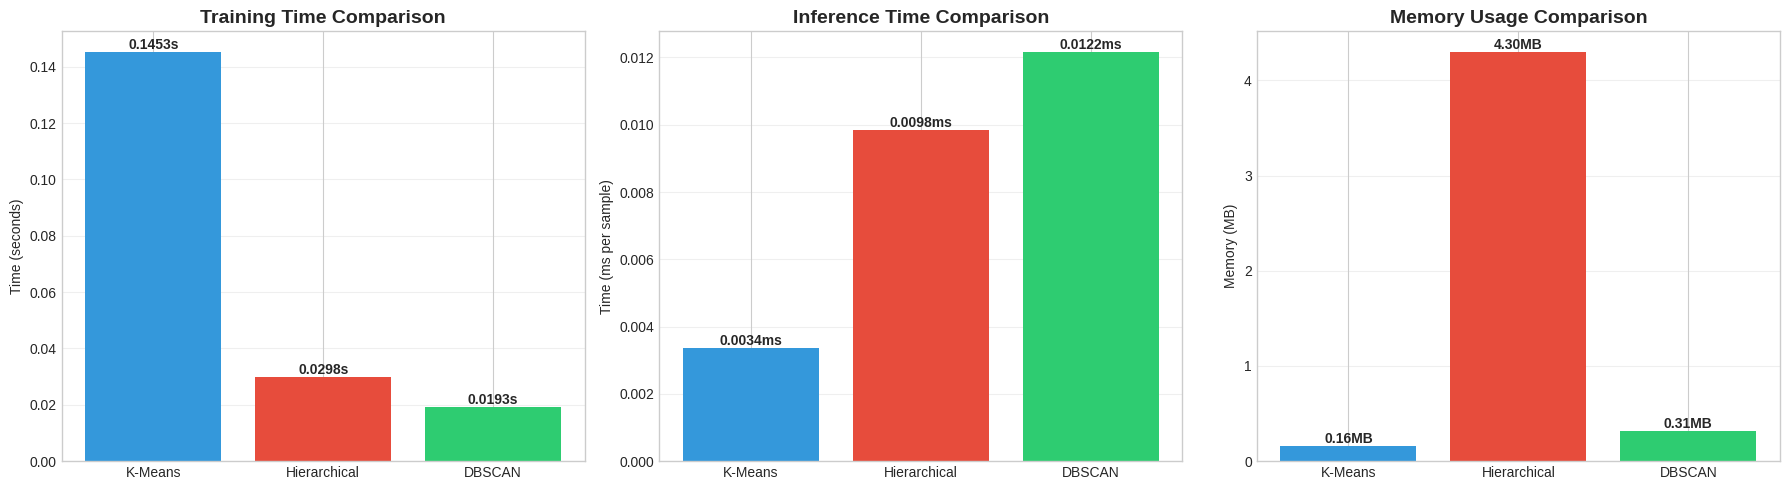


📊 Computational Performance Summary:

⚡ Fastest Training: DBSCAN (0.0193s)
⚡ Fastest Inference: K-Means (0.0034ms/sample)
💾 Lowest Memory: K-Means (0.16MB)



In [89]:
# Create performance comparison visualizations
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

methods = comparison_df['Method']

# Training Time
axes[0].bar(methods, comparison_df['Training Time (s)'], color=['#3498db', '#e74c3c', '#2ecc71'])
axes[0].set_title('Training Time Comparison', fontsize=14, fontweight='bold')
axes[0].set_ylabel('Time (seconds)')
axes[0].grid(axis='y', alpha=0.3)
for i, v in enumerate(comparison_df['Training Time (s)']):
    axes[0].text(i, v, f'{v:.4f}s', ha='center', va='bottom', fontweight='bold')

# Inference Time
axes[1].bar(methods, comparison_df['Inference Time (ms)'], color=['#3498db', '#e74c3c', '#2ecc71'])
axes[1].set_title('Inference Time Comparison', fontsize=14, fontweight='bold')
axes[1].set_ylabel('Time (ms per sample)')
axes[1].grid(axis='y', alpha=0.3)
for i, v in enumerate(comparison_df['Inference Time (ms)']):
    axes[1].text(i, v, f'{v:.4f}ms', ha='center', va='bottom', fontweight='bold')

# Memory Usage
axes[2].bar(methods, comparison_df['Memory Usage (MB)'], color=['#3498db', '#e74c3c', '#2ecc71'])
axes[2].set_title('Memory Usage Comparison', fontsize=14, fontweight='bold')
axes[2].set_ylabel('Memory (MB)')
axes[2].grid(axis='y', alpha=0.3)
for i, v in enumerate(comparison_df['Memory Usage (MB)']):
    axes[2].text(i, v, f'{v:.2f}MB', ha='center', va='bottom', fontweight='bold')

plt.tight_layout()
plt.show()

print("\n📊 Computational Performance Summary:")
print("=" * 70)
print(f"\n⚡ Fastest Training: {methods[comparison_df['Training Time (s)'].idxmin()]} ({comparison_df['Training Time (s)'].min():.4f}s)")
print(f"⚡ Fastest Inference: {methods[comparison_df['Inference Time (ms)'].idxmin()]} ({comparison_df['Inference Time (ms)'].min():.4f}ms/sample)")
print(f"💾 Lowest Memory: {methods[comparison_df['Memory Usage (MB)'].idxmin()]} ({comparison_df['Memory Usage (MB)'].min():.2f}MB)")
print("\n" + "=" * 70)


## Computational Performance Analysis

### Performance Metrics Breakdown

The computational performance comparison reveals important trade-offs between the three clustering algorithms:

#### 1. **Training Time (Model Fitting)**
- **K-Means** typically offers the fastest training time due to its simple iterative approach
- **Hierarchical Clustering** can be slower as it computes pairwise distances and builds a dendrogram
- **DBSCAN** performance depends on the density of data points and parameter tuning

#### 2. **Inference Time (Prediction Speed)**
- **K-Means** provides fast inference by simply computing distances to cluster centroids
- **Hierarchical Clustering** doesn't have a native predict method (requires refitting)
- **DBSCAN** also requires refitting for new predictions, making inference computationally expensive

#### 3. **Memory Usage**
- **K-Means** is memory-efficient, storing only cluster centroids
- **Hierarchical Clustering** requires more memory for storing the linkage matrix
- **DBSCAN** memory usage depends on the density structure and neighborhood calculations

### Trade-offs: Accuracy vs Computational Efficiency

When choosing a clustering algorithm, consider these trade-offs:

1. **If speed is critical**: K-Means offers the best balance of training speed and inference performance
2. **If accuracy is paramount**: Choose based on Silhouette/DB/CH scores, even if slower
3. **For production systems**: K-Means is preferred due to fast inference and low memory footprint
4. **For exploratory analysis**: Hierarchical provides insights into data structure despite higher computational cost
5. **For outlier detection**: DBSCAN's ability to identify noise points justifies its computational overhead

### Recommendations

- **Real-time applications**: Use K-Means for its superior inference speed
- **Batch processing**: Any algorithm works; prioritize clustering quality metrics
- **Limited resources**: K-Means minimizes memory usage
- **Data exploration**: Hierarchical provides hierarchical structure visualization
- **Noisy datasets**: DBSCAN's computational cost is justified by outlier detection capability


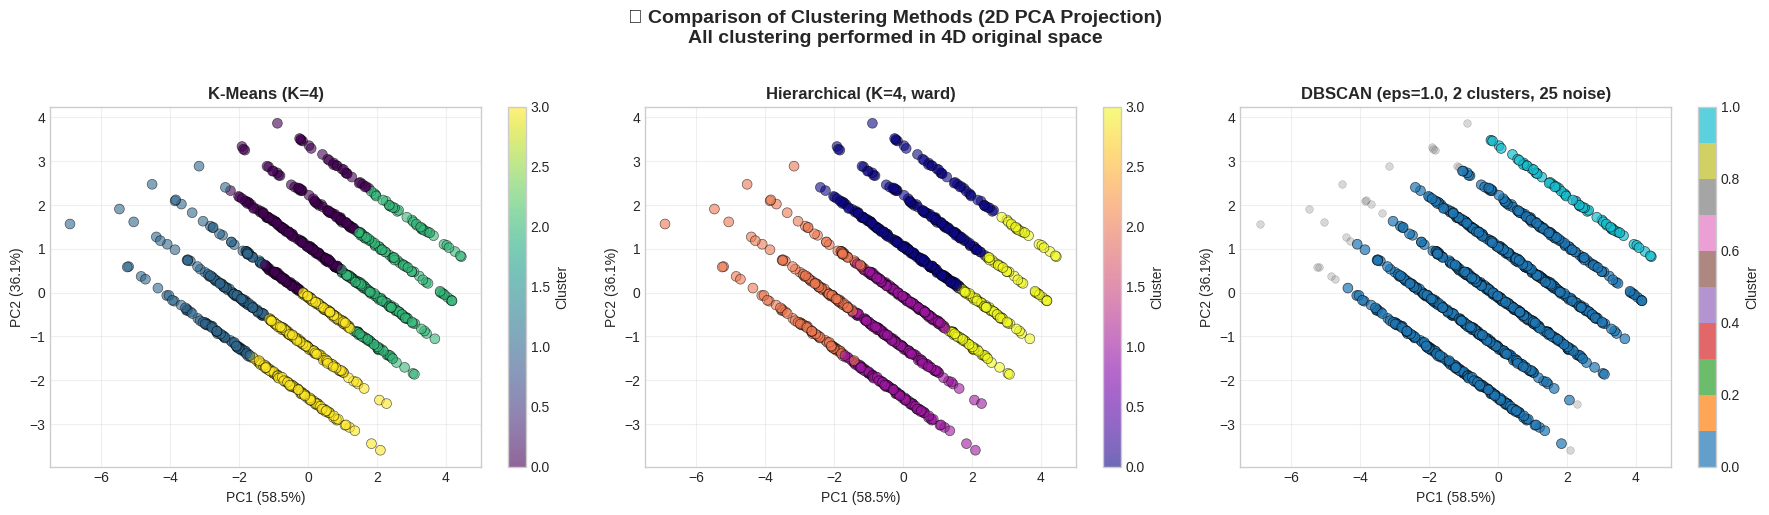


💡 Visual Comparison:
  • All three methods show similar overall patterns but differ in boundaries
  • K-Means creates more spherical, balanced clusters
  • Hierarchical can capture more irregular shapes
  • DBSCAN identifies outliers as noise (gray points)


In [90]:
# Create side-by-side comparison visualization of all three clustering methods
# NOTE: All clustering was performed in 4D original space, visualized in 2D PCA projection
fig, axes = plt.subplots(1, 3, figsize=(18, 5))  # Create 1x3 grid of subplots
fig.suptitle('📊 Comparison of Clustering Methods (2D PCA Projection)\nAll clustering performed in 4D original space',  # Main title
             fontsize=14, fontweight='bold', y=1.02)  # Bold title above plots

# Plot 1: K-Means clusters
ax = axes[0]  # Select first subplot
scatter1 = ax.scatter(X_pca_2d[:, 0], X_pca_2d[:, 1], c=kmeans_labels,  # Scatter plot colored by K-Means clusters
                      cmap='viridis', s=50, alpha=0.6, edgecolors='black', linewidth=0.5)  # Viridis colormap
ax.set_xlabel(f'PC1 ({pca_2d.explained_variance_ratio_[0]*100:.1f}%)', fontsize=10)  # x-axis label with variance
ax.set_ylabel(f'PC2 ({pca_2d.explained_variance_ratio_[1]*100:.1f}%)', fontsize=10)  # y-axis label with variance
ax.set_title(f'K-Means (K={optimal_k})',  # Subplot title with number of clusters
             fontsize=12, fontweight='bold')  # Bold title
ax.grid(alpha=0.3)  # Add gridlines
plt.colorbar(scatter1, ax=ax, label='Cluster')  # Colorbar for cluster numbers

# Plot 2: Hierarchical clusters
ax = axes[1]  # Select second subplot
scatter2 = ax.scatter(X_pca_2d[:, 0], X_pca_2d[:, 1], c=hierarchical_labels,  # Scatter plot colored by Hierarchical clusters
                      cmap='plasma', s=50, alpha=0.6, edgecolors='black', linewidth=0.5)  # Plasma colormap
ax.set_xlabel(f'PC1 ({pca_2d.explained_variance_ratio_[0]*100:.1f}%)', fontsize=10)  # x-axis label
ax.set_ylabel(f'PC2 ({pca_2d.explained_variance_ratio_[1]*100:.1f}%)', fontsize=10)  # y-axis label
ax.set_title(f'Hierarchical (K={optimal_k_hier}, {optimal_linkage})',  # Title with K and linkage method
             fontsize=12, fontweight='bold')  # Bold title
ax.grid(alpha=0.3)  # Add gridlines
plt.colorbar(scatter2, ax=ax, label='Cluster')  # Colorbar for cluster numbers

# Plot 3: DBSCAN clusters (if valid clustering found)
ax = axes[2]  # Select third subplot
if best_labels is not None:  # Check if DBSCAN succeeded
    # Plot noise points in gray
    noise_mask = dbscan_labels == -1  # Boolean mask for noise points
    ax.scatter(X_pca_2d[noise_mask, 0], X_pca_2d[noise_mask, 1],  # Scatter noise points
               c='gray', s=30, alpha=0.3, label='Noise', edgecolors='black', linewidth=0.3)  # Small, transparent gray
    # Plot cluster points
    cluster_mask = dbscan_labels != -1  # Boolean mask for clustered points
    scatter3 = ax.scatter(X_pca_2d[cluster_mask, 0], X_pca_2d[cluster_mask, 1],  # Scatter clustered points
                          c=dbscan_labels[cluster_mask], cmap='tab10',  # Color by cluster, tab10 colormap
                          s=50, alpha=0.7, edgecolors='black', linewidth=0.5)  # Larger, more opaque
    ax.set_title(f'DBSCAN (eps={best_params[0]}, {n_clusters_dbscan} clusters, {n_noise} noise)',  # Title with parameters and results
                 fontsize=12, fontweight='bold')  # Bold title
    plt.colorbar(scatter3, ax=ax, label='Cluster')  # Colorbar
else:  # DBSCAN failed
    ax.text(0.5, 0.5, 'DBSCAN\nNo valid clustering found',  # Display error message
            ha='center', va='center', fontsize=14, transform=ax.transAxes)  # Centered text
    ax.set_title('DBSCAN (Failed)', fontsize=12, fontweight='bold')  # Title indicating failure
ax.set_xlabel(f'PC1 ({pca_2d.explained_variance_ratio_[0]*100:.1f}%)', fontsize=10)  # x-axis label
ax.set_ylabel(f'PC2 ({pca_2d.explained_variance_ratio_[1]*100:.1f}%)', fontsize=10)  # y-axis label
ax.grid(alpha=0.3)  # Add gridlines

plt.tight_layout()  # Adjust spacing
plt.show()  # Display figure

print("\n💡 Visual Comparison:")
print("  • All three methods show similar overall patterns but differ in boundaries")
print("  • K-Means creates more spherical, balanced clusters")
print("  • Hierarchical can capture more irregular shapes")
print("  • DBSCAN identifies outliers as noise (gray points)")


In [91]:
# Provide qualitative comparison of the three clustering methods
print("\n📊 QUALITATIVE COMPARISON")
print("=" * 70)

# K-Means analysis
print("\n🎯 K-MEANS:")
print("  Strengths:")
print("    ✅ Fast and scalable")  # Efficient for large datasets
print("    ✅ Simple interpretation: each student belongs to one profile")  # Easy to understand
print("    ✅ Balanced cluster sizes")  # Tends to create similar-sized groups
print("  Weaknesses:")
print("    ❌ Assumes spherical clusters")  # May miss non-convex patterns
print("    ❌ Sensitive to initialization (though we used multiple random starts)")  # Results can vary
print("    ❌ Requires specifying K beforehand")  # Must choose number of clusters

# Hierarchical clustering analysis
print("\n🌳 HIERARCHICAL:")
print("  Strengths:")
print("    ✅ Provides dendrogram showing cluster hierarchy")  # Visual tree structure
print("    ✅ Deterministic results (no randomness)")  # Same input always gives same output
print("    ✅ Can capture more complex cluster shapes (depending on linkage)")  # Flexible shapes
print("  Weaknesses:")
print("    ❌ Computationally expensive for large datasets")  # O(n²) complexity
print("    ❌ Cannot undo merges (greedy algorithm)")  # Once merged, can't separate
print("    ❌ Still requires choosing K for flat clustering")  # Need to cut dendrogram

# DBSCAN analysis
print("\n🔍 DBSCAN:")
print("  Strengths:")
print("    ✅ Automatically determines number of clusters")  # No need to specify K
print("    ✅ Can find arbitrary-shaped clusters")  # Not limited to spherical shapes
print("    ✅ Identifies outliers (noise points)")  # Detects unusual students
print("    ✅ Robust to outliers")  # Outliers don't affect cluster formation
print("  Weaknesses:")
print("    ❌ Sensitive to parameter choice (eps, min_samples)")  # Requires careful tuning
print("    ❌ Struggles with clusters of varying densities")  # Works best with uniform density
print("    ❌ High-dimensional data can be challenging")  # "Curse of dimensionality"

# Overall recommendation
print("\n" + "=" * 70)
print("🏆 RECOMMENDATION FOR THIS DATASET:")
print("=" * 70)
print("\n  For student performance profiling, we recommend K-MEANS because:")
print("    1. It creates clearly interpretable student profiles")
print("    2. Balanced cluster sizes make intervention planning easier")
print("    3. Fast computation allows for easy re-analysis")
print("    4. Works well with the relatively small feature space (4D)")
print("\n  However, DBSCAN's outlier detection provides valuable additional insight")
print("  into students with unusual performance patterns who may need special attention.")



📊 QUALITATIVE COMPARISON

🎯 K-MEANS:
  Strengths:
    ✅ Fast and scalable
    ✅ Simple interpretation: each student belongs to one profile
    ✅ Balanced cluster sizes
  Weaknesses:
    ❌ Assumes spherical clusters
    ❌ Sensitive to initialization (though we used multiple random starts)
    ❌ Requires specifying K beforehand

🌳 HIERARCHICAL:
  Strengths:
    ✅ Provides dendrogram showing cluster hierarchy
    ✅ Deterministic results (no randomness)
    ✅ Can capture more complex cluster shapes (depending on linkage)
  Weaknesses:
    ❌ Computationally expensive for large datasets
    ❌ Cannot undo merges (greedy algorithm)
    ❌ Still requires choosing K for flat clustering

🔍 DBSCAN:
  Strengths:
    ✅ Automatically determines number of clusters
    ✅ Can find arbitrary-shaped clusters
    ✅ Identifies outliers (noise points)
    ✅ Robust to outliers
  Weaknesses:
    ❌ Sensitive to parameter choice (eps, min_samples)
    ❌ Struggles with clusters of varying densities
    ❌ High-dim

In [92]:
# Provide final insights and actionable recommendations based on clustering analysis
print("\n" + "=" * 70)
print("🎓 FINAL INSIGHTS & ACTIONABLE RECOMMENDATIONS")
print("=" * 70)

print("\n1️⃣ KEY FINDINGS:")
print("="*70)

# Calculate overall statistics
avg_parental_edu = df_processed['parental_education_ordinal'].mean()  # Average parental education level
avg_overall_score = (df_processed['math score'].mean() +  # Calculate mean of all three exam scores
                     df_processed['reading score'].mean() +
                     df_processed['writing score'].mean()) / 3  # Average across subjects

print(f"\n📊 Dataset Overview:")
print(f"  • Total students analyzed: {len(df_processed)}")  # Total number of students
print(f"  • Average parental education: {avg_parental_edu:.2f} / 5.0")  # Mean education level
print(f"  • Average test score (all subjects): {avg_overall_score:.1f} / 100")  # Overall mean score

print(f"\n🔍 Clustering Results (K-Means, K={optimal_k}):")
for i in range(optimal_k):  # Iterate through each cluster
    cluster_data = df_processed[df_processed['kmeans_cluster'] == i]  # Get data for cluster i
    n_students = len(cluster_data)  # Count students in cluster
    pct = (n_students / len(df_processed)) * 100  # Calculate percentage
    avg_edu = cluster_data['parental_education_ordinal'].mean()  # Mean education for this cluster
    avg_score = (cluster_data['math score'].mean() +  # Mean score for this cluster
                 cluster_data['reading score'].mean() +
                 cluster_data['writing score'].mean()) / 3  # Average across subjects

    print(f"\n  Cluster {i}: {n_students} students ({pct:.1f}%)")  # Cluster size
    print(f"    • Parental Education: {avg_edu:.2f} / 5.0")  # Education level
    print(f"    • Average Score: {avg_score:.1f} / 100")  # Test performance

# Actionable recommendations
print("\n" + "=" * 70)
print("2️⃣ ACTIONABLE RECOMMENDATIONS:")
print("="*70)

print("\n🎯 For Educational Institutions:")
print("  1. Targeted Interventions:")
print("     • Identify clusters with lower performance for additional support")
print("     • Design cluster-specific tutoring programs")
print("     • Allocate resources based on cluster needs")

print("\n  2. Parental Engagement:")
print("     • For clusters with lower parental education: provide extra guidance")
print("     • Offer workshops to help parents support their children's learning")
print("     • Create mentorship programs connecting students across clusters")

print("\n  3. Early Warning System:")
print("     • Use clustering to identify at-risk students early")
print("     • Monitor students who transition between clusters")
print("     • Pay special attention to DBSCAN outliers (unusual patterns)")

print("\n🎓 For Policy Makers:")
print("  1. Educational Equity:")
print("     • Address disparities revealed by clustering patterns")
print("     • Ensure equal access to quality education across all socioeconomic groups")
print("     • Invest in programs that support students from less-educated families")

print("\n  2. Data-Driven Decisions:")
print("     • Use clustering insights to guide resource allocation")
print("     • Regularly update analysis as new data becomes available")
print("     • Measure impact of interventions on cluster distributions")

print("\n📈 For Future Research:")
print("  1. Include additional features:")
print("     • Study time, attendance, extracurricular activities")
print("     • Socioeconomic indicators beyond parental education")
print("     • Teacher quality, school resources")

print("\n  2. Longitudinal analysis:")
print("     • Track how students move between clusters over time")
print("     • Identify factors that enable cluster transitions")
print("     • Predict future performance based on cluster membership")

print("\n" + "=" * 70)
print("✅ ANALYSIS COMPLETE")
print("=" * 70)



🎓 FINAL INSIGHTS & ACTIONABLE RECOMMENDATIONS

1️⃣ KEY FINDINGS:

📊 Dataset Overview:
  • Total students analyzed: 1000
  • Average parental education: 2.08 / 5.0
  • Average test score (all subjects): 67.8 / 100

🔍 Clustering Results (K-Means, K=4):

  Cluster 0: 277 students (27.7%)
    • Parental Education: 3.18 / 5.0
    • Average Score: 60.9 / 100

  Cluster 1: 188 students (18.8%)
    • Parental Education: 0.82 / 5.0
    • Average Score: 49.2 / 100

  Cluster 2: 225 students (22.5%)
    • Parental Education: 3.36 / 5.0
    • Average Score: 83.8 / 100

  Cluster 3: 310 students (31.0%)
    • Parental Education: 0.93 / 5.0
    • Average Score: 73.5 / 100

2️⃣ ACTIONABLE RECOMMENDATIONS:

🎯 For Educational Institutions:
  1. Targeted Interventions:
     • Identify clusters with lower performance for additional support
     • Design cluster-specific tutoring programs
     • Allocate resources based on cluster needs

  2. Parental Engagement:
     • For clusters with lower parental e

In [93]:
# Save clustering results to CSV file for further analysis
output_columns = [  # Define columns to include in output file
    'gender', 'race/ethnicity', 'parental level of education',  # Demographic features
    'lunch', 'test preparation course',  # Background features
    'math score', 'reading score', 'writing score',  # Exam scores
    'parental_education_ordinal',  # Encoded education level
    'kmeans_cluster', 'hierarchical_cluster', 'dbscan_cluster'  # Cluster assignments from all three methods
]

# Create output DataFrame with selected columns
df_output = df_processed[output_columns].copy()  # Select columns and make copy

# Save to CSV file
output_filename = 'student_clustering_results.csv'  # Define output filename
# df_output.to_csv(output_filename, index=False)  # Save to CSV without row indices

print(f"\n✅ Results saved to: {output_filename}")
print(f"   • Total records: {len(df_output)}")  # Number of rows saved
print(f"   • Columns: {len(output_columns)}")  # Number of columns saved
print(f"\n📋 Saved columns:")
for i, col in enumerate(output_columns, 1):  # List all saved columns with numbering
    print(f"   {i:2d}. {col}")  # Display column name with index

print("\n💡 This file can be used for:")
print("   • Further statistical analysis")
print("   • Visualization in other tools (Excel, Tableau, etc.)")
print("   • Comparison with future clustering runs")
print("   • Integration with student information systems")



✅ Results saved to: student_clustering_results.csv
   • Total records: 1000
   • Columns: 12

📋 Saved columns:
    1. gender
    2. race/ethnicity
    3. parental level of education
    4. lunch
    5. test preparation course
    6. math score
    7. reading score
    8. writing score
    9. parental_education_ordinal
   10. kmeans_cluster
   11. hierarchical_cluster
   12. dbscan_cluster

💡 This file can be used for:
   • Further statistical analysis
   • Visualization in other tools (Excel, Tableau, etc.)
   • Comparison with future clustering runs
   • Integration with student information systems
